## Building a Tiny Knowledge Graph with BERT and Graph Convolutions
This notebook is the source of the code to build and test the graph described in the article


In [27]:
import argparse
import io
import json
import os

from google.cloud import language
import numpy
import six
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_lg")

In [338]:
import nltk
from nltk.stem import WordNetLemmatizer

In [339]:
lemmatizer = WordNetLemmatizer()

The following is a simple function for cleaning and extracting sentences.   it was pulled from the web.  not sure of provenance.

In [2]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

# invoking the google entity extractor
to use it you must set up a google cloud account and sign up for the language.googleapis.com service.  You will also need your google credential set  up correctly.  in writing the article and debugging this notebook,  i have spent $26.   so if you have a free google cloud account it won't cost much.



In [3]:
from google.cloud import language_v1
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_file('key.json')
language_client = language_v1.LanguageServiceClient(credentials=creds,)

def classify(text, verbose=True):
    """Classify the input text into categories. """
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    encoding_type = language_v1.EncodingType.UTF8
    response = language_client.analyze_entities(document = document,encoding_type = encoding_type)
    return response

import requests
import wikipedia
def findWikiData(itemurl):
    st = itemurl.find('wiki/')
    item = itemurl[st+5:]
    #print(item)
    s= "https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&titles=%s&format=json"%(item)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    #print('rr=', rr)
    ans = rr.find('wikibase_item')
    answer = rr[ans+16:]
    e = answer.find('"')
    return item, answer[:e]

This function grabs the instanceOf data (P31) from wikidata.  it returns an empty string if it fails to find anything.  it is basically scraping the json to find the information.  not very elegant.

In [4]:
def getInstanceOfId(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    try:
        j = json.loads(rr)
        k = rr.find('P31')
        if k > 0:
            l = rr[k:].find('"id":')
            if l > 0:
                s = rr[k+l+5:k+l+23]
                t = s.find('}')
                id = s[1:t-1]
                x = id.find('$')
                if x < 0:
                    return id
                else:
                    return id[:x]
            else:
                return ''
        else:
            return ''
    except:
        return ''
    
    

In [ ]:
getInstanceOfId('Q678023')

This is another wikidata scrape to find the name of an object given it's wikidataID

In [5]:
def getNameFromWikiID(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    if r.status_code == 429:
        time.sleep(8)
        r = requests.get(s)
    rr = r.content.decode("utf-8")
    s = rr.find('"value":')
    rrr= rr[s+8:s+50]
    t = rrr.find('}')
    return rrr[1:t-1]

In [6]:
getNameFromWikiID("Q55814")

'extinction event'

In [7]:
def getDescription(wikiId):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiId)
    r = requests.get(s)
    if r.status_code == 429:
      time.sleep(8)
      r = requests.get(s)

    rr =r.content.decode("utf-8")
    i = rr.find("descriptions")
    if i < 0:
        return ''
    else:
        rrr = rr[i:]
        #print(rrr)
        j = rrr.find('"value":')
        if j >0:
            #print(j)
            k = rrr.find("}")
            return(rrr[j+8: k])
        else:
            return ''

In [ ]:
getDescription("Q55814")

This function extracts entities from a sentence.   if it is a wikipedia entity  it pulls some wikidata.

In [371]:
def entityExtractorBlock(sents):
    ents = []
    x = classify(sents)
    for ent in x.entities:
        print('--->', ent.name)
        print(ent)
        if ent.metadata['wikipedia_url'] != '' or len(str.split(ent.name))> 1:
            wikipage = ent.metadata['wikipedia_url']
            if wikipage != '':
                name, wikidataId = findWikiData(wikipage)
                name = lemmatizer.lemmatize(name)
                ents.append((name, wikidataId, wikipage))

            else:
                wikidataId = "none"
                #print(name, wikidataId, wikipage)
                name = lemmatizer.lemmatize(ent.name)
                ents.append((name, wikidataId, wikipage))
        elif(not ent.name.lower() in STOP_WORDS and not ent.name.lower()[:-1] in STOP_WORDS):
            name = lemmatizer.lemmatize(ent.name)
            ents.append((name, "none", ''))
        
    return ents

In [9]:
import networkx as nx

The entity extractor creates a list that consists of a list of all of the entities and the last item in the list is the sentence.   

In [10]:
def entityExtractor(sent):
    ents = []
    newents = entityExtractorBlock(sent)
    if newents != []:
        entitem = []
        for x in newents:
            entitem.append({'entity': x})
        entitem.append({'context': sent})
        ents = ents + entitem
    #print(entitem)
    return ents


In [125]:
def get_ents(sent):
    doc = nlp(sent)
    parts_of_speech = ["NOUN", "PROPN"] #Categories of Keywords/Phrases to consider as entities
    ents = []
    at_least_1 = 0
    for token in doc:
        if token.pos_ in parts_of_speech and token.is_stop is False and token.is_punct is False:
            at_least_1 = 1
            ents.append((token.lemma_,'none', ''))
    if(not at_least_1):
        ents.append(('none', 'none', ''))
    return ents
            
    

In [62]:
def get_nouns(sent):
    doc = nlp(sent)
    parts_of_speech = ["NOUN", "PROPN"] #Categories of Keywords/Phrases to consider as entities
    ents = []
    at_least_1 = 0
    for token in doc:
        if token.pos_ in parts_of_speech and token.is_stop is False and token.is_punct is False:
            at_least_1 = 1
            ents.append({'entity': (token.lemma_,'none', '')})
    if(not at_least_1):
        ents.append({'entity': ('none', 'none', '')})
    ents.append({'context': sent})
    return ents
            
    

## add a new file to the graph.
because the articles are named as ArtN to add a new article you need to know the number of articles currently in the graph.  that is art_cnt.

for each sentence in the article it invokes the entity extractor.  with the list of entities it creates the entity nodes for each.   for those entities that are in wikipedia it create a list of "instanceOf" entities (lightgray in color).  it finally creates an article node.   When this is all done it adds the edges as needed. 

In [63]:
def addFile(art_cnt, G, filename):
    items = open(filename+'.txt', 'r').read()
    print(items)
    sents = items.split("\n")
    print(sents)
    #split_into_sentences(items)
    for sent in sents:
        print(sent)
        ents = entityExtractor(sent)
        print("Entities:")
        print(ents)
        if(ents == []):
            ents = get_nouns(sent)
            print("New:",ents)
        all_nodes = []
        nodes = []
        instances = []
        ent_list = []
        for e in ents:
            if e.get('entity') != None:
                ent_list.append(e['entity'][0])
                #this is an entity for this node
                lab = e['entity'][2]
                name = e['entity'][0]
                wikiID = e['entity'][1]
                st = lab.find('wiki/')
                if st <0: #Is a noun phrase
                    item = name
                    #print('Item=', item)
                    G.add_node(item, flavor='entity', url='none', wikiID = 'noID', color = 'lightgreen')
                    #print("just made ", G.node[item])
                    G.nodes[item]['instanceof'] = []
                    G.nodes[item]['subclassof'] = []
                    G.nodes[item]['description'] = ''
                    nodes.append(item)

                else:
                    item = lab[st+5:]
                    #print("item=", item)
                    #wikiID = findWikiData(lab)[1]
                    G.add_node(item, flavor='entity', url=lab, wikiID = wikiID, color = 'lightblue') #wikipedia
                    #print("just smade ", item, G.nodes[item])
                    instID = getInstanceOfId(wikiID)
                    if instID != '':
                        inst_list = [(instID, getNameFromWikiID(instID))]
                        #print([wikiID, (instID, getNameFromWikiID(instID))])
                    else:
                        inst_list = []
                    clas_list = []#isASubclassOf(wikiID)
                    G.nodes[item]['instanceof'] = inst_list
                    instances = instances + inst_list
                    G.nodes[item]['subclassof'] = clas_list        
                    #classes = classes + clas_list
                    G.nodes[item]['description'] = getDescription(wikiID)
                    #print(findWikiData(lab))
                    nodes.append(item)
            if e.get('context') != None:
                # this is a new article
                newart = 'Art'+str(art_cnt)
                G.add_node(newart, flavor='article', source=filename, context=e['context'], color='lightyellow')
                G.nodes[newart]['ent-list'] = ent_list
                #print(newart,G.nodes[newart])
                art_cnt = art_cnt+1
                for z in nodes:
                    G.add_edge(newart,z )
                all_nodes = all_nodes + nodes
                nodes = []
        instance_set = set(instances)
        instances = list(instance_set)
        if instances != []:
            print('instances ====', instances)
        #now make items for these instances
        for i in instances:
            G.add_node(i[1], flavor='entity', url='notknown', wikiID = i[0], color = 'lightgray')
            G.nodes[i[1]]['description'] = getDescription(i[0])
            G.nodes[i[1]]['instanceof'] = []
            G.nodes[i[1]]['subclassof'] = []
        #now add edges from the instance to the new entity
        all_nodes_set = set(all_nodes)
        all_nodes =  list(all_nodes_set)
        for n in all_nodes:
            if G.nodes[n]['instanceof'] != []:
                elist = G.nodes[n]['instanceof']
                for e in elist:
                    G.add_edge(n, e[1])
    print(art_cnt)
    return art_cnt

## Importing Data

In [500]:
f = open("Paragraphs.json","r",encoding="utf8")
Paragraphs = json.load(f)
print(len(Paragraphs))

456


In [233]:
Para_Num = int(input("Enter the Paragraph number you want "))

Enter the Paragraph number you want1


In [237]:
for sent in range(len(Paragraphs[Para_Num])):
    name = "Data/Para" + str(Para_Num) + "Sent" + str(sent+1) +".txt"
    test_f = open(name,"w+")
    test_f.write(Paragraphs[Para_Num][sent])
    test_f.close()


In [263]:
f = open("Questions.json","r",encoding="utf8")
data_qs = json.load(f)
print(len(data_qs))

456


In [267]:
Questions = data_qs[Para_Num]
Num_of_Qs = len(Questions)

In [266]:
f = open("Answers.json","r",encoding="utf8")
answer_qs = json.load(f)
print(len(answer_qs))

456


In [274]:
Answer_Para = answer_qs[Para_Num]

In [485]:
Paragraphs[16][3] = "He moved quickly to eliminate his strongest rivals, crushing them in 1600 at the great Battle of Sekigahara, near modern Nagoya." 

## Building our Graph

In [501]:
for Para_Num in range(414,len(Paragraphs)):
    G = nx.Graph()
    art_cnt = 0
    for sent in range(len(Paragraphs[Para_Num])):
        name = "Data/Para" + str(Para_Num) + "Sent" + str(sent+1) +".txt"
        test_f = open(name,"w+")
        print(Paragraphs[Para_Num][sent])
        test_f.write(Paragraphs[Para_Num][sent])
        test_f.close()
        name = "Data/Para" + str(Para_Num) + "Sent" + str(sent+1)
        art_cnt = addFile(art_cnt, G, name)
    graph_name = "Graphs/Para" + str(Para_Num)
    nx.write_gpickle(G, graph_name)


#G = nx.read_gpickle(graph_name)


RTSH is the public radio and TV broadcaster of Albania, founded by King Zog in 1938.
RTSH is the public radio and TV broadcaster of Albania, founded by King Zog in 1938.
['RTSH is the public radio and TV broadcaster of Albania, founded by King Zog in 1938.']
RTSH is the public radio and TV broadcaster of Albania, founded by King Zog in 1938.
---> RTSH
name: "RTSH"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/09h0vh"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/RTSH"
}
salience: 0.3927253
mentions {
  text {
    content: "RTSH"
  }
  type_: PROPER
}

---> radio
name: "radio"
type_: OTHER
salience: 0.23116848
mentions {
  text {
    content: "radio"
    begin_offset: 19
  }
  type_: COMMON
}

---> TV broadcaster
name: "TV broadcaster"
type_: ORGANIZATION
salience: 0.2050276
mentions {
  text {
    content: "TV broadcaster"
    begin_offset: 29
  }
  type_: COMMON
}

---> Albania
name: "Albania"
type_: LOCATION
metadata {
  key: "mid"
  value: "/

---> seven
name: "seven"
type_: NUMBER
metadata {
  key: "value"
  value: "7"
}
mentions {
  text {
    content: "seven"
    begin_offset: 70
  }
}

Entities:
[{'entity': ('service broadcasts radio programmes', 'none', '')}, {'entity': ('medium wave', 'none', '')}, {'entity': ('language', 'none', '')}, {'entity': ('short wave', 'none', '')}, {'entity': ('Albanian_language', 'Q8748', 'https://en.wikipedia.org/wiki/Albanian_language')}, {'entity': ('seven', 'none', '')}, {'context': 'The international service broadcasts radio programmes in Albanian and seven other languages via medium wave (AM) and short wave (SW).'}]
instances ==== [('Q34770', 'language')]
4
The international service has used the theme from the song "Keputa nje gjethe dafine" as its signature tune.
The international service has used the theme from the song "Keputa nje gjethe dafine" as its signature tune.
['The international service has used the theme from the song "Keputa nje gjethe dafine" as its signature tune.']
The

instances ==== [('Q15265344', 'broadcaster')]
7
According to the Albanian Media Authority, AMA, Albania has an estimated 257 media outlets, including 66 radio stations and 67 television stations, with three national, 62 local and more than 50 cable TV stations.
According to the Albanian Media Authority, AMA, Albania has an estimated 257 media outlets, including 66 radio stations and 67 television stations, with three national, 62 local and more than 50 cable TV stations.
['According to the Albanian Media Authority, AMA, Albania has an estimated 257 media outlets, including 66 radio stations and 67 television stations, with three national, 62 local and more than 50 cable TV stations.']
According to the Albanian Media Authority, AMA, Albania has an estimated 257 media outlets, including 66 radio stations and 67 television stations, with three national, 62 local and more than 50 cable TV stations.
---> Albanian Media Authority
name: "Albanian Media Authority"
type_: ORGANIZATION
salience:

---> land
name: "land"
type_: LOCATION
salience: 0.73712355
mentions {
  text {
    content: "land"
    begin_offset: 5
  }
  type_: COMMON
}

---> habitats
name: "habitats"
type_: OTHER
salience: 0.26287645
mentions {
  text {
    content: "habitats"
    begin_offset: 22
  }
  type_: COMMON
}

Entities:
[{'entity': ('land', 'none', '')}, {'entity': ('habitat', 'none', '')}, {'context': 'When land is cleared, habitats are lost.'}]
1
It may be cleared for agriculture.
It may be cleared for agriculture.
['It may be cleared for agriculture.']
It may be cleared for agriculture.
---> agriculture
name: "agriculture"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "agriculture"
    begin_offset: 22
  }
  type_: COMMON
}

Entities:
[{'entity': ('agriculture', 'none', '')}, {'context': 'It may be cleared for agriculture.'}]
2
It may also be used for building new homes or businesses.
It may also be used for building new homes or businesses.
['It may also be used for building new home

---> home
name: "home"
type_: LOCATION
salience: 0.37631118
mentions {
  text {
    content: "home"
    begin_offset: 16
  }
  type_: COMMON
}

---> plants
name: "plants"
type_: LOCATION
salience: 0.35206783
mentions {
  text {
    content: "plants"
    begin_offset: 29
  }
  type_: COMMON
}

---> animals
name: "animals"
type_: OTHER
salience: 0.271621
mentions {
  text {
    content: "animals"
    begin_offset: 40
  }
  type_: COMMON
}

Entities:
[{'entity': ('home', 'none', '')}, {'entity': ('plant', 'none', '')}, {'entity': ('animal', 'none', '')}, {'context': ' They also were home to many plants and animals.'}]
12
 Prairies were wonderful places.
 Prairies were wonderful places.
[' Prairies were wonderful places.']
 Prairies were wonderful places.
---> Prairies
name: "Prairies"
type_: ORGANIZATION
salience: 0.6223327
mentions {
  text {
    content: "Prairies"
    begin_offset: 1
  }
  type_: COMMON
}

---> places
name: "places"
type_: LOCATION
salience: 0.3776673
mentions {
  text

---> pilot
name: "pilot"
type_: OTHER
salience: 0.58150464
mentions {
  text {
    content: "pilot"
    begin_offset: 22
  }
  type_: COMMON
}

---> emergency frequency
name: "emergency frequency"
type_: OTHER
salience: 0.4184954
mentions {
  text {
    content: "emergency frequency"
    begin_offset: 35
  }
  type_: COMMON
}

Entities:
[{'entity': ('pilot', 'none', '')}, {'entity': ('emergency frequency', 'none', '')}, {'context': 'He reached out to the pilot on the emergency frequency.'}]
4
Though there was no response, he kept trying to contact the aircraft.
Though there was no response, he kept trying to contact the aircraft.
['Though there was no response, he kept trying to contact the aircraft.']
Though there was no response, he kept trying to contact the aircraft.
---> response
name: "response"
type_: OTHER
salience: 0.60727364
mentions {
  text {
    content: "response"
    begin_offset: 20
  }
  type_: COMMON
}

---> aircraft
name: "aircraft"
type_: OTHER
salience: 0.39272636


---> route
name: "route"
type_: OTHER
salience: 0.4568524
mentions {
  text {
    content: "route"
    begin_offset: 38
  }
  type_: COMMON
}

---> sector
name: "sector"
type_: OTHER
salience: 0.3171277
mentions {
  text {
    content: "sector"
    begin_offset: 73
  }
  type_: COMMON
}

---> airspace
name: "airspace"
type_: LOCATION
salience: 0.22601987
mentions {
  text {
    content: "airspace"
    begin_offset: 82
  }
  type_: COMMON
}

Entities:
[{'entity': ('route', 'none', '')}, {'entity': ('sector', 'none', '')}, {'entity': ('airspace', 'none', '')}, {'context': " He became even more concerned as its route changed, moving into another sector's airspace."}]
10
 Controllers immediately began to move aircraft out of its path, and asked other aircraft in the vicinity to look for American 11.
 Controllers immediately began to move aircraft out of its path, and asked other aircraft in the vicinity to look for American 11.
[' Controllers immediately began to move aircraft out of its p

---> moves
name: "moves"
type_: OTHER
salience: 0.528767
mentions {
  text {
    content: "moves"
    begin_offset: 24
  }
  type_: COMMON
}

---> airplane
name: "airplane"
type_: OTHER
salience: 0.471233
mentions {
  text {
    content: "airplane"
    begin_offset: 64
  }
  type_: COMMON
}

Entities:
[{'entity': ('airplane', 'none', '')}, {'context': " If you try to make any moves, you'll endanger yourself and the airplane."}]
18
When Alexander destroyed Tyre, most of the towns on the route to Egypt quickly capitulated.
When Alexander destroyed Tyre, most of the towns on the route to Egypt quickly capitulated.
['When Alexander destroyed Tyre, most of the towns on the route to Egypt quickly capitulated.']
When Alexander destroyed Tyre, most of the towns on the route to Egypt quickly capitulated.
---> Alexander
name: "Alexander"
type_: PERSON
salience: 0.36691087
mentions {
  text {
    content: "Alexander"
    begin_offset: 5
  }
  type_: PROPER
}

---> towns
name: "towns"
type_: LOCAT

Entities:
[{'entity': ('resistance', 'none', '')}, {'entity': ('Alexander', 'none', '')}, {'entity': ('Gaza_Strip', 'Q39760', 'https://en.wikipedia.org/wiki/Gaza_Strip')}, {'context': 'However, Alexander met with resistance at Gaza.'}]
instances ==== [('Q2577883', 'occupied territory')]
4
The stronghold was heavily fortified and built on a hill, requiring a siege.
The stronghold was heavily fortified and built on a hill, requiring a siege.
['The stronghold was heavily fortified and built on a hill, requiring a siege.']
The stronghold was heavily fortified and built on a hill, requiring a siege.
---> stronghold
name: "stronghold"
type_: LOCATION
salience: 0.6856492
mentions {
  text {
    content: "stronghold"
    begin_offset: 4
  }
  type_: COMMON
}

---> hill
name: "hill"
type_: LOCATION
salience: 0.22473614
mentions {
  text {
    content: "hill"
    begin_offset: 52
  }
  type_: COMMON
}

---> siege
name: "siege"
type_: EVENT
salience: 0.08961464
mentions {
  text {
    content: "s

---> Amun
name: "Amun"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0sjj"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Amun"
}
salience: 0.4018641
mentions {
  text {
    content: "Amun"
    begin_offset: 36
  }
  type_: PROPER
}
mentions {
  text {
    content: "deity"
    begin_offset: 30
  }
  type_: COMMON
}

---> son
name: "son"
type_: PERSON
salience: 0.2761395
mentions {
  text {
    content: "son"
    begin_offset: 19
  }
  type_: COMMON
}

---> Oracle
name: "Oracle"
type_: ORGANIZATION
salience: 0.10763548
mentions {
  text {
    content: "Oracle"
    begin_offset: 48
  }
  type_: PROPER
}

---> desert
name: "desert"
type_: LOCATION
salience: 0.09635649
mentions {
  text {
    content: "desert"
    begin_offset: 83
  }
  type_: COMMON
}

---> Libyan
name: "Libyan"
type_: LOCATION
salience: 0.08171614
mentions {
  text {
    content: "Libyan"
    begin_offset: 76
  }
  type_: PROPER
}

---> Siwa Oasis
name: "Siwa Oasis"
type_: LOCATION
metad

---> Java
name: "Java"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/07sbkfb"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Java_(programming_language)"
}
salience: 0.06657159
mentions {
  text {
    content: "Java"
    begin_offset: 105
  }
  type_: PROPER
}

---> Malays
name: "Malays"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/01pn8r"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malays_(ethnic_group)"
}
salience: 0.050435126
mentions {
  text {
    content: "Malays"
    begin_offset: 138
  }
  type_: PROPER
}

---> Melaka
name: "Melaka"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/05fsj1"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malacca_City"
}
salience: 0.035472006
mentions {
  text {
    content: "Melaka"
    begin_offset: 165
  }
  type_: PROPER
}

---> Dutch
name: "Dutch"
type_: PERSON
salience: 0.022315387
mentions {
  text {
    content: "Dutch"
    begin_offset: 

---> islands
name: "islands"
type_: LOCATION
salience: 0.04050146
mentions {
  text {
    content: "islands"
    begin_offset: 181
  }
  type_: COMMON
}

---> Singapore
name: "Singapore"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06t2t"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Singapore"
}
salience: 0.034307163
mentions {
  text {
    content: "Singapore"
    begin_offset: 146
  }
  type_: PROPER
}

---> peninsula
name: "peninsula"
type_: LOCATION
salience: 0.025559722
mentions {
  text {
    content: "peninsula"
    begin_offset: 122
  }
  type_: COMMON
}

---> Riau
name: "Riau"
type_: LOCATION
salience: 0.024128893
mentions {
  text {
    content: "Riau"
    begin_offset: 176
  }
  type_: PROPER
}

Entities:
[{'entity': ('Malays_(ethnic_group)', 'Q142702', 'https://en.wikipedia.org/wiki/Malays_(ethnic_group)')}, {'entity': ('Portuguese_language', 'Q5146', 'https://en.wikipedia.org/wiki/Portuguese_language')}, {'entity': ('business', 'none'

---> Europeans
name: "Europeans"
type_: PERSON
salience: 0.16444367
mentions {
  text {
    content: "Europeans"
    begin_offset: 53
  }
  type_: PROPER
}

Entities:
[{'entity': ('Dutch', 'none', '')}, {'entity': ('buffer', 'none', '')}, {'entity': ('Johor', 'Q183032', 'https://en.wikipedia.org/wiki/Johor')}, {'entity': ('Europeans', 'none', '')}, {'context': 'For the Dutch, Johor provided a buffer against other Europeans.'}]
instances ==== [('Q15063586', 'state of Malaysia')]
8
Meanwhile, fresh blood came in with the migration into the southern interior of hardy Minangkabau farmers from Sumatra, while tough Bugis warriors from the east Indonesian Celebes (Sulawesi) roved the length and breadth of the peninsula.
Meanwhile, fresh blood came in with the migration into the southern interior of hardy Minangkabau farmers from Sumatra, while tough Bugis warriors from the east Indonesian Celebes (Sulawesi) roved the length and breadth of the peninsula.
['Meanwhile, fresh blood came in with t

---> Nine States
name: "Nine States"
type_: LOCATION
salience: 0.1782689
mentions {
  text {
    content: "States"
    begin_offset: 24
  }
  type_: PROPER
}
mentions {
  text {
    content: "Nine States"
    begin_offset: 64
  }
  type_: PROPER
}

---> Negeri Sembilan
name: "Negeri Sembilan"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0211kz"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Negeri_Sembilan"
}
salience: 0.07660906
mentions {
  text {
    content: "Negeri Sembilan"
    begin_offset: 46
  }
  type_: PROPER
}

---> capital
name: "capital"
type_: LOCATION
salience: 0.06384953
mentions {
  text {
    content: "capital"
    begin_offset: 100
  }
  type_: COMMON
}

---> Nine
name: "Nine"
type_: NUMBER
metadata {
  key: "value"
  value: "9"
}
mentions {
  text {
    content: "Nine"
    begin_offset: 64
  }
}

Entities:
[{'entity': ('confederation', 'none', '')}, {'entity': ('Seremban', 'Q847610', 'https://en.wikipedia.org/wiki/Seremban')}, {

---> Selangor
name: "Selangor"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01jc9d"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Selangor"
}
salience: 0.014201512
mentions {
  text {
    content: "Selangor"
    begin_offset: 182
  }
  type_: PROPER
}

---> 18
name: "18"
type_: NUMBER
metadata {
  key: "value"
  value: "18"
}
mentions {
  text {
    content: "18"
    begin_offset: 72
  }
}

Entities:
[{'entity': ('Dutch', 'none', '')}, {'entity': ('advantage', 'none', '')}, {'entity': ('vacuum', 'none', '')}, {'entity': ('Maluku_Islands', 'Q3827', 'https://en.wikipedia.org/wiki/Maluku_Islands')}, {'entity': ('Java_(programming_language)', 'Q251', 'https://en.wikipedia.org/wiki/Java_(programming_language)')}, {'entity': ('power', 'none', '')}, {'entity': ('Buginese_people', 'Q1002570', 'https://en.wikipedia.org/wiki/Buginese_people')}, {'entity': ('Kedah', 'Q188947', 'https://en.wikipedia.org/wiki/Kedah')}, {'entity': ('Perak', 'none', '')}, {'entit

---> East India Company
name: "East India Company"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0bvz6"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/East_India_Company"
}
salience: 0.50417846
mentions {
  text {
    content: "East India Company"
    begin_offset: 48
  }
  type_: PROPER
}
mentions {
  text {
    content: "EIC"
    begin_offset: 68
  }
  type_: PROPER
}

---> British
name: "British"
type_: LOCATION
salience: 0.23088752
mentions {
  text {
    content: "British"
    begin_offset: 5
  }
  type_: PROPER
}

---> auspices
name: "auspices"
type_: OTHER
salience: 0.15529686
mentions {
  text {
    content: "auspices"
    begin_offset: 32
  }
  type_: COMMON
}

---> noses
name: "noses"
type_: OTHER
salience: 0.076963745
mentions {
  text {
    content: "noses"
    begin_offset: 103
  }
  type_: COMMON
}

---> North Borneo
name: "North Borneo"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/022njx"
}
metadata {
  key: "wikipedia_url"

---> John Moore
name: "John Moore"
type_: PERSON
metadata {
  key: "mid"
  value: "/g/11gj19_psw"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/John_Moore_(photographer)"
}
salience: 0.7515378
mentions {
  text {
    content: "John Moore"
    begin_offset: 122
  }
  type_: PROPER
}
mentions {
  text {
    content: "staff photographer"
    begin_offset: 103
  }
  type_: COMMON
}

---> CNN.com Live
name: "CNN.com Live"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0gsgr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/CNN"
}
salience: 0.05424937
mentions {
  text {
    content: "streaming news service"
    begin_offset: 151
  }
  type_: COMMON
}
mentions {
  text {
    content: "CNN.com Live"
    begin_offset: 175
  }
  type_: PROPER
}
mentions {
  text {
    content: "CNN"
    begin_offset: 138
  }
  type_: PROPER
}

---> crowd
name: "crowd"
type_: PERSON
salience: 0.035926167
mentions {
  text {
    content: "crowd"
 

Entities:
[{'entity': ('Rawalpindi General Hospital', 'none', '')}, {'entity': ('Zulfikar_Ali_Bhutto', 'Q131355', 'https://en.wikipedia.org/wiki/Zulfikar_Ali_Bhutto')}, {'context': 'Bhutto was rushed to Rawalpindi General Hospital, where she was pronounced dead.'}]
instances ==== [('Q5', 'human')]
8
Moore said he had been following Bhutto's story since her return to Pakistan in October.
Moore said he had been following Bhutto's story since her return to Pakistan in October.
["Moore said he had been following Bhutto's story since her return to Pakistan in October."]
Moore said he had been following Bhutto's story since her return to Pakistan in October.
---> Moore
name: "Moore"
type_: PERSON
salience: 0.68898416
mentions {
  text {
    content: "Moore"
  }
  type_: PROPER
}

---> story
name: "story"
type_: OTHER
salience: 0.13199484
mentions {
  text {
    content: "story"
    begin_offset: 42
  }
  type_: COMMON
}

---> Bhutto
name: "Bhutto"
type_: PERSON
metadata {
  key: "mid"
  valu

---> rally
name: "rally"
type_: EVENT
salience: 0.7704413
mentions {
  text {
    content: "rally"
    begin_offset: 48
  }
  type_: COMMON
}

---> Rawalpindi
name: "Rawalpindi"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01yf40"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Rawalpindi"
}
salience: 0.14982086
mentions {
  text {
    content: "Rawalpindi"
    begin_offset: 37
  }
  type_: PROPER
}

---> parkground
name: "parkground"
type_: LOCATION
salience: 0.07973784
mentions {
  text {
    content: "parkground"
    begin_offset: 75
  }
  type_: COMMON
}

---> 8,000
name: "8,000"
type_: NUMBER
metadata {
  key: "value"
  value: "8000"
}
mentions {
  text {
    content: "8,000"
    begin_offset: 19
  }
}

---> 5,000
name: "5,000"
type_: NUMBER
metadata {
  key: "value"
  value: "5000"
}
mentions {
  text {
    content: "5,000"
    begin_offset: 9
  }
}

Entities:
[{'entity': ('rally', 'none', '')}, {'entity': ('Rawalpindi', 'Q93230', 'https://en.w

---> pedestrians
name: "pedestrians"
type_: PERSON
salience: 0.16651504
mentions {
  text {
    content: "pedestrians"
    begin_offset: 44
  }
  type_: COMMON
}

---> pistol
name: "pistol"
type_: PERSON
salience: 0.14885914
mentions {
  text {
    content: "pistol"
    begin_offset: 164
  }
  type_: COMMON
}

---> hail
name: "hail"
type_: OTHER
salience: 0.083813384
mentions {
  text {
    content: "hail"
    begin_offset: 116
  }
  type_: COMMON
}

---> police
name: "police"
type_: PERSON
salience: 0.083813384
mentions {
  text {
    content: "police"
    begin_offset: 97
  }
  type_: COMMON
}

---> bullet
name: "bullet"
type_: OTHER
salience: 0.0828263
mentions {
  text {
    content: "bullet"
    begin_offset: 65
  }
  type_: COMMON
}

---> fragment
name: "fragment"
type_: OTHER
salience: 0.0828263
mentions {
  text {
    content: "fragment"
    begin_offset: 75
  }
  type_: COMMON
}

---> wounds
name: "wounds"
type_: OTHER
salience: 0.0828263
mentions {
  text {
    content: "woun

instances ==== [('Q208511', 'global city'), ('Q5', 'human')]
3
All injuries were caused by police, he said Saturday.
All injuries were caused by police, he said Saturday.
['All injuries were caused by police, he said Saturday.']
All injuries were caused by police, he said Saturday.
---> injuries
name: "injuries"
type_: OTHER
salience: 0.75744206
mentions {
  text {
    content: "injuries"
    begin_offset: 4
  }
  type_: COMMON
}

---> police
name: "police"
type_: PERSON
salience: 0.24255793
mentions {
  text {
    content: "police"
    begin_offset: 28
  }
  type_: COMMON
}

Entities:
[{'entity': ('injury', 'none', '')}, {'entity': ('police', 'none', '')}, {'context': 'All injuries were caused by police, he said Saturday.'}]
4
One officer shot nine rounds and another shot seven.
One officer shot nine rounds and another shot seven.
['One officer shot nine rounds and another shot seven.']
One officer shot nine rounds and another shot seven.
---> officer
name: "officer"
type_: PERSON
sal

---> men
name: "men"
type_: PERSON
salience: 0.492745
mentions {
  text {
    content: "men"
    begin_offset: 6
  }
  type_: COMMON
}

---> harassment complaints
name: "harassment complaints"
type_: OTHER
salience: 0.25065455
mentions {
  text {
    content: "harassment complaints"
    begin_offset: 20
  }
  type_: COMMON
}

---> each other
name: "each other"
type_: PERSON
salience: 0.16492964
mentions {
  text {
    content: "each other"
    begin_offset: 50
  }
  type_: COMMON
}

---> Kelly
name: "Kelly"
type_: PERSON
salience: 0.09167079
mentions {
  text {
    content: "Kelly"
    begin_offset: 76
  }
  type_: PROPER
}

---> April 2011
name: "April 2011"
type_: DATE
metadata {
  key: "month"
  value: "4"
}
metadata {
  key: "year"
  value: "2011"
}
mentions {
  text {
    content: "April 2011"
    begin_offset: 64
  }
}

---> 2011
name: "2011"
type_: NUMBER
metadata {
  key: "value"
  value: "2011"
}
mentions {
  text {
    content: "2011"
    begin_offset: 70
  }
}

Entities:
[{'

---> evidence
name: "evidence"
type_: OTHER
salience: 0.22901133
mentions {
  text {
    content: "evidence"
    begin_offset: 8
  }
  type_: COMMON
}

---> people
name: "people"
type_: PERSON
salience: 0.22901133
mentions {
  text {
    content: "people"
    begin_offset: 27
  }
  type_: COMMON
}

---> one
name: "one"
type_: OTHER
salience: 0.07638279
mentions {
  text {
    content: "one"
    begin_offset: 86
  }
  type_: COMMON
}

---> sites
name: "sites"
type_: OTHER
salience: 0.06468296
mentions {
  text {
    content: "sites"
    begin_offset: 123
  }
  type_: COMMON
}

---> Formentera
name: "Formentera"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0dhh4"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Formentera"
}
salience: 0.059825614
mentions {
  text {
    content: "Formentera"
    begin_offset: 158
  }
  type_: PROPER
}

---> island
name: "island"
type_: LOCATION
salience: 0.059501525
mentions {
  text {
    content: "island"
    begin_of

---> Ebysos
name: "Ebysos"
type_: PERSON
salience: 0.17510618
mentions {
  text {
    content: "Ebysos"
    begin_offset: 21
  }
  type_: PROPER
}

---> Ebusus
name: "Ebusus"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0h2c3"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Ibiza"
}
salience: 0.1304042
mentions {
  text {
    content: "Ebusus"
    begin_offset: 50
  }
  type_: PROPER
}

---> Romans
name: "Romans"
type_: PERSON
salience: 0.12143249
mentions {
  text {
    content: "Romans"
    begin_offset: 33
  }
  type_: PROPER
}

---> Moors
name: "Moors"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0c8r3"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Moors"
}
salience: 0.0848149
mentions {
  text {
    content: "Moors"
    begin_offset: 66
  }
  type_: PROPER
}

---> Yebisah
name: "Yebisah"
type_: PERSON
metadata {
  key: "mid"
  value: "/g/11c1nhk5n2"
}
salience: 0.05976799
mentions {
  text {
    content:

---> industry
name: "industry"
type_: OTHER
salience: 0.044768278
mentions {
  text {
    content: "industry"
    begin_offset: 111
  }
  type_: COMMON
}

---> source
name: "source"
type_: OTHER
salience: 0.02833308
mentions {
  text {
    content: "source"
    begin_offset: 88
  }
  type_: COMMON
}

Entities:
[{'entity': ('interest', 'none', '')}, {'entity': ('salt flats', 'none', '')}, {'entity': ('Ibiza', 'Q52631', 'https://en.wikipedia.org/wiki/Ibiza')}, {'entity': ('industry', 'none', '')}, {'entity': ('source', 'none', '')}, {'context': 'Their interest in Ibiza lay partly in its vast salt flats, which to this day remain the source of a profitable industry.'}]
instances ==== [('Q23442', 'island')]
8
They capitalized on the natural resources by using the salt to cure fish, which they exported to their home country.
They capitalized on the natural resources by using the salt to cure fish, which they exported to their home country.
['They capitalized on the natural resources by using

---> Windmills
name: "Windmills"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/0bxdx"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Windmill"
}
salience: 0.0083969645
mentions {
  text {
    content: "Windmills"
    begin_offset: 185
  }
  type_: PROPER
}

Entities:
[{'entity': ('Carthaginians', 'none', '')}, {'entity': ('island', 'none', '')}, {'entity': ('place', 'none', '')}, {'entity': ('citizen', 'none', '')}, {'entity': ('splendour', 'none', '')}, {'entity': ('thousand', 'none', '')}, {'entity': ('necropolis', 'none', '')}, {'entity': ('Puig des Molins', 'none', '')}, {'entity': ("Ville_haute_d'Ibiza", '', "https://fr.wikipedia.org/wiki/Ville_haute_d'Ibiza")}, {'entity': ('Hill', 'none', '')}, {'entity': ('Old Town', 'none', '')}, {'entity': ('Ibiza_(town)', 'Q473914', 'https://en.wikipedia.org/wiki/Ibiza_(town)')}, {'entity': ('Windmill', 'Q38720', 'https://en.wikipedia.org/wiki/Windmill')}, {'context': ' The Carthaginians also considered the is

---> inroads
name: "inroads"
type_: OTHER
salience: 0.3248877
mentions {
  text {
    content: "inroads"
    begin_offset: 25
  }
  type_: COMMON
}

---> historians
name: "historians"
type_: PERSON
salience: 0.2803123
mentions {
  text {
    content: "historians"
    begin_offset: 48
  }
  type_: COMMON
}

---> Ibiza
name: "Ibiza"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0h2c3"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Ibiza"
}
salience: 0.17268646
mentions {
  text {
    content: "Ibiza"
    begin_offset: 67
  }
  type_: PROPER
}

---> autonomy
name: "autonomy"
type_: OTHER
salience: 0.168146
mentions {
  text {
    content: "autonomy"
    begin_offset: 155
  }
  type_: COMMON
}

---> Rome
name: "Rome"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06c62"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Rome"
}
salience: 0.053967543
mentions {
  text {
    content: "Rome"
    begin_offset: 110
  }
  type_: 

---> Indianapolis Center
name: "Indianapolis Center"
type_: ORGANIZATION
salience: 0.28784856
mentions {
  text {
    content: "Indianapolis Center"
    begin_offset: 3
  }
  type_: PROPER
}

---> aircraft
name: "aircraft"
type_: OTHER
salience: 0.15296458
mentions {
  text {
    content: "aircraft"
    begin_offset: 51
  }
  type_: COMMON
}

---> managers
name: "managers"
type_: PERSON
salience: 0.13235521
mentions {
  text {
    content: "managers"
    begin_offset: 65
  }
  type_: COMMON
}

---> controller
name: "controller"
type_: OTHER
salience: 0.09315677
mentions {
  text {
    content: "controller"
    begin_offset: 82
  }
  type_: COMMON
}

---> southwest
name: "southwest"
type_: LOCATION
salience: 0.08677588
mentions {
  text {
    content: "southwest"
    begin_offset: 144
  }
  type_: COMMON
}

---> west
name: "west"
type_: OTHER
salience: 0.08677588
mentions {
  text {
    content: "west"
    begin_offset: 135
  }
  type_: COMMON
}

---> American
name: "American"
type_: LO

---> Command Center
name: "Command Center"
type_: ORGANIZATION
salience: 0.40551236
mentions {
  text {
    content: "Command Center"
    begin_offset: 13
  }
  type_: COMMON
}

---> headquarters
name: "headquarters"
type_: LOCATION
salience: 0.15636167
mentions {
  text {
    content: "headquarters"
    begin_offset: 78
  }
  type_: COMMON
}

---> Flight 77
name: "Flight 77"
type_: OTHER
salience: 0.13635506
mentions {
  text {
    content: "Flight 77"
    begin_offset: 36
  }
  type_: PROPER
}

---> FAA
name: "FAA"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/02_hj"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Federal_Aviation_Administration"
}
salience: 0.094559394
mentions {
  text {
    content: "FAA"
    begin_offset: 74
  }
  type_: PROPER
}

---> radar targets
name: "radar targets"
type_: OTHER
salience: 0.07787804
mentions {
  text {
    content: "radar targets"
    begin_offset: 166
  }
  type_: COMMON
}

---> bulletin
name: "bulleti

---> Boston Center
name: "Boston Center"
type_: LOCATION
salience: 0.09157382
mentions {
  text {
    content: "Boston Center"
    begin_offset: 32
  }
  type_: PROPER
}

---> hijacker
name: "hijacker"
type_: PERSON
salience: 0.09022886
mentions {
  text {
    content: "hijacker"
    begin_offset: 85
  }
  type_: COMMON
}

---> New England Region
name: "New England Region"
type_: LOCATION
salience: 0.06350454
mentions {
  text {
    content: "New England Region"
    begin_offset: 54
  }
  type_: PROPER
}

---> planes
name: "planes"
type_: OTHER
salience: 0.051679187
mentions {
  text {
    content: "planes"
    begin_offset: 138
  }
  type_: COMMON
}

---> American 11
name: "American 11"
type_: OTHER
salience: 0.019697022
mentions {
  text {
    content: "American 11"
    begin_offset: 103
  }
  type_: PROPER
}

---> 11
name: "11"
type_: NUMBER
metadata {
  key: "value"
  value: "11"
}
mentions {
  text {
    content: "11"
    begin_offset: 112
  }
}

Entities:
[{'entity': ('official',

---> control facility
name: "control facility"
type_: OTHER
salience: 0.15967126
mentions {
  text {
    content: "control facility"
    begin_offset: 41
  }
  type_: COMMON
}

---> targets
name: "targets"
type_: OTHER
salience: 0.07984105
mentions {
  text {
    content: "targets"
    begin_offset: 112
  }
  type_: COMMON
}

---> controllers
name: "controllers"
type_: PERSON
salience: 0.05745799
mentions {
  text {
    content: "controllers"
    begin_offset: 80
  }
  type_: COMMON
}

---> 21
name: "21"
type_: NUMBER
metadata {
  key: "value"
  value: "21"
}
mentions {
  text {
    content: "21"
    begin_offset: 6
  }
}

---> 9
name: "9"
type_: NUMBER
metadata {
  key: "value"
  value: "9"
}
mentions {
  text {
    content: "9"
    begin_offset: 4
  }
}

Entities:
[{'entity': ('Dulles_International_Airport', 'Q466835', 'https://en.wikipedia.org/wiki/Dulles_International_Airport')}, {'entity': ('control facility', 'none', '')}, {'entity': ('target', 'none', '')}, {'entity': ('controll

---> rest
name: "rest"
type_: OTHER
salience: 0.06148037
mentions {
  text {
    content: "rest"
    begin_offset: 158
  }
  type_: COMMON
}

---> opposite
name: "opposite"
type_: OTHER
salience: 0.060751643
mentions {
  text {
    content: "opposite"
    begin_offset: 107
  }
  type_: COMMON
}

---> Portugal
name: "Portugal"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/05r4w"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Portugal"
}
salience: 0.05918147
mentions {
  text {
    content: "Portugal"
    begin_offset: 54
  }
  type_: PROPER
}
mentions {
  text {
    content: "Portuguese"
    begin_offset: 72
  }
  type_: PROPER
}

---> country
name: "country"
type_: LOCATION
salience: 0.04343269
mentions {
  text {
    content: "country"
    begin_offset: 170
  }
  type_: COMMON
}

---> region
name: "region"
type_: LOCATION
salience: 0.032114495
mentions {
  text {
    content: "region"
    begin_offset: 121
  }
  type_: COMMON
}

Entities:
[{'entity'

instances ==== [('Q4445055', 'subregion of Portugal')]
5
And beaches.
And beaches.
['And beaches.']
And beaches.
---> beaches
name: "beaches"
type_: LOCATION
salience: 1.0
mentions {
  text {
    content: "beaches"
    begin_offset: 4
  }
  type_: COMMON
}

Entities:
[{'entity': ('beach', 'none', '')}, {'context': 'And beaches.'}]
6
Think Algarve and the mind pictures long, glorious stretches of golden sands, secluded coves framed by odd ochre-colored rock formations, and deep green waters.
Think Algarve and the mind pictures long, glorious stretches of golden sands, secluded coves framed by odd ochre-colored rock formations, and deep green waters.
['Think Algarve and the mind pictures long, glorious stretches of golden sands, secluded coves framed by odd ochre-colored rock formations, and deep green waters.']
Think Algarve and the mind pictures long, glorious stretches of golden sands, secluded coves framed by odd ochre-colored rock formations, and deep green waters.
---> Algarve
name

---> resort area
name: "resort area"
type_: LOCATION
salience: 0.031763736
mentions {
  text {
    content: "resort area"
    begin_offset: 165
  }
  type_: COMMON
}

---> sunshine
name: "sunshine"
type_: OTHER
salience: 0.020079693
mentions {
  text {
    content: "sunshine"
    begin_offset: 108
  }
  type_: COMMON
}

---> 250
name: "250"
type_: NUMBER
metadata {
  key: "value"
  value: "250"
}
mentions {
  text {
    content: "250"
    begin_offset: 96
  }
}

---> one
name: "one"
type_: NUMBER
metadata {
  key: "value"
  value: "1"
}
mentions {
  text {
    content: "one"
    begin_offset: 53
  }
}

Entities:
[{'entity': ('climate', 'none', '')}, {'entity': ('world', 'none', '')}, {'entity': ('kindest', 'none', '')}, {'entity': ('Portugal', 'Q45', 'https://en.wikipedia.org/wiki/Portugal')}, {'entity': ('resort area', 'none', '')}, {'entity': ('sunshine', 'none', '')}, {'entity': ('250', 'none', '')}, {'context': ' Its consistent climate is the best in Portugal, and one of the kindes

---> package vacations
name: "package vacations"
type_: OTHER
salience: 0.2890807
mentions {
  text {
    content: "package vacations"
    begin_offset: 72
  }
  type_: COMMON
}
mentions {
  text {
    content: "reasons"
    begin_offset: 105
  }
  type_: COMMON
}

---> Sports
name: "Sports"
type_: OTHER
salience: 0.21401629
mentions {
  text {
    content: "Sports"
    begin_offset: 1
  }
  type_: COMMON
}

---> beaches
name: "beaches"
type_: LOCATION
salience: 0.21401629
mentions {
  text {
    content: "beaches"
    begin_offset: 9
  }
  type_: COMMON
}

---> weather
name: "weather"
type_: OTHER
salience: 0.088890254
mentions {
  text {
    content: "weather"
    begin_offset: 32
  }
  type_: COMMON
}

---> rest
name: "rest"
type_: PERSON
salience: 0.084069185
mentions {
  text {
    content: "rest"
    begin_offset: 158
  }
  type_: COMMON
}

---> Algarve
name: "Algarve"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01gg84"
}
metadata {
  key: "wikipedia_url"
  value: "https

---> cliffs
name: "cliffs"
type_: LOCATION
salience: 0.30758223
mentions {
  text {
    content: "cliffs"
    begin_offset: 45
  }
  type_: COMMON
}

---> rock stacks
name: "rock stacks"
type_: OTHER
salience: 0.1584237
mentions {
  text {
    content: "rock stacks"
    begin_offset: 71
  }
  type_: COMMON
}

Entities:
[{'entity': ('West', 'Q679', 'https://en.wikipedia.org/wiki/West')}, {'entity': ('cliff', 'none', '')}, {'entity': ('rock stacks', 'none', '')}, {'context': " West is where you'll find the famous orange cliffs and surreal eroded rock stacks."}]
instances ==== [('Q23718', 'cardinal direction')]
18
The digestive system is the body system that digests food.
The digestive system is the body system that digests food.
['The digestive system is the body system that digests food.']
The digestive system is the body system that digests food.
---> digestive system
name: "digestive system"
type_: OTHER
salience: 0.90786797
mentions {
  text {
    content: "digestive system"
    begi

---> stomach
name: "stomach"
type_: OTHER
salience: 0.39483985
mentions {
  text {
    content: "stomach"
    begin_offset: 7
  }
  type_: COMMON
}

---> digestion
name: "digestion"
type_: OTHER
salience: 0.24427181
mentions {
  text {
    content: "digestion"
    begin_offset: 16
  }
  type_: COMMON
}

---> amount
name: "amount"
type_: OTHER
salience: 0.16358262
mentions {
  text {
    content: "amount"
    begin_offset: 48
  }
  type_: COMMON
}

---> nutrients
name: "nutrients"
type_: OTHER
salience: 0.087272
mentions {
  text {
    content: "nutrients"
    begin_offset: 72
  }
  type_: COMMON
}

---> place
name: "place"
type_: OTHER
salience: 0.070648
mentions {
  text {
    content: "place"
    begin_offset: 88
  }
  type_: COMMON
}

---> absorption
name: "absorption"
type_: OTHER
salience: 0.039385717
mentions {
  text {
    content: "absorption"
    begin_offset: 58
  }
  type_: COMMON
}

Entities:
[{'entity': ('stomach', 'none', '')}, {'entity': ('digestion', 'none', '')}, {'ent

---> college
name: "college"
type_: OTHER
salience: 0.78354007
mentions {
  text {
    content: "college"
    begin_offset: 15
  }
  type_: COMMON
}

---> doctor
name: "doctor"
type_: PERSON
salience: 0.2164599
mentions {
  text {
    content: "doctor"
    begin_offset: 51
  }
  type_: COMMON
}

Entities:
[{'entity': ('college', 'none', '')}, {'entity': ('doctor', 'none', '')}, {'context': '"When I was in college, I thought I wanted to be a doctor," she said.'}]
4
"I found I didn't want to do that and realized an interest in psychology.
"I found I didn't want to do that and realized an interest in psychology.
['"I found I didn\'t want to do that and realized an interest in psychology.']
"I found I didn't want to do that and realized an interest in psychology.
---> interest
name: "interest"
type_: OTHER
salience: 0.58387023
mentions {
  text {
    content: "interest"
    begin_offset: 50
  }
  type_: COMMON
}

---> psychology
name: "psychology"
type_: OTHER
salience: 0.41612974
mentions

---> 59
name: "59"
type_: NUMBER
metadata {
  key: "value"
  value: "59"
}
mentions {
  text {
    content: "59"
    begin_offset: 47
  }
}

---> 66
name: "66"
type_: NUMBER
metadata {
  key: "value"
  value: "66"
}
mentions {
  text {
    content: "66"
    begin_offset: 27
  }
}

Entities:
[{'entity': ('resident', 'none', '')}, {'entity': ('Carter Bond', 'none', '')}, {'entity': ('Carol Bond', 'none', '')}, {'entity': ('Gastonia,_North_Carolina', 'Q943775', 'https://en.wikipedia.org/wiki/Gastonia,_North_Carolina')}, {'entity': ('59', 'none', '')}, {'entity': ('66', 'none', '')}, {'context': ' Her parents, Carter Bond, 66, and Carol Bond, 59, are still residents of Gastonia.'}]
instances ==== [('Q1093829', 'city of the United States')]
11
 From Hunter Huss, she moved on to pursue a degree at Pfeiffer University in Misenheimer.
 From Hunter Huss, she moved on to pursue a degree at Pfeiffer University in Misenheimer.
[' From Hunter Huss, she moved on to pursue a degree at Pfeiffer Univer

---> Public Defender Corp.
name: "Public Defender Corp."
type_: ORGANIZATION
salience: 0.13220574
mentions {
  text {
    content: "Public Defender Corp."
    begin_offset: 97
  }
  type_: PROPER
}

---> career
name: "career"
type_: OTHER
salience: 0.09866128
mentions {
  text {
    content: "career"
    begin_offset: 87
  }
  type_: COMMON
}

---> Princeton
name: "Princeton"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0ljsz"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Princeton,_New_Jersey"
}
salience: 0.093163714
mentions {
  text {
    content: "Princeton"
    begin_offset: 122
  }
  type_: PROPER
}

---> 1992
name: "1992"
type_: DATE
metadata {
  key: "year"
  value: "1992"
}
mentions {
  text {
    content: "1992"
    begin_offset: 62
  }
}

---> 1992
name: "1992"
type_: NUMBER
metadata {
  key: "value"
  value: "1992"
}
mentions {
  text {
    content: "1992"
    begin_offset: 62
  }
}

Entities:
[{'entity': ('law degree', 'none', '')}, {'

---> style
name: "style"
type_: OTHER
salience: 0.2741373
mentions {
  text {
    content: "style"
    begin_offset: 29
  }
  type_: COMMON
}

---> influences
name: "influences"
type_: OTHER
salience: 0.25593382
mentions {
  text {
    content: "influences"
    begin_offset: 67
  }
  type_: COMMON
}

---> forms
name: "forms"
type_: OTHER
salience: 0.19607712
mentions {
  text {
    content: "forms"
    begin_offset: 103
  }
  type_: COMMON
}

---> Italian
name: "Italian"
type_: LOCATION
salience: 0.15550633
mentions {
  text {
    content: "Italian"
    begin_offset: 59
  }
  type_: PROPER
}

---> Northern
name: "Northern"
type_: LOCATION
salience: 0.118345454
mentions {
  text {
    content: "Northern"
    begin_offset: 94
  }
  type_: PROPER
}

---> five
name: "five"
type_: NUMBER
metadata {
  key: "value"
  value: "5"
}
mentions {
  text {
    content: "five"
    begin_offset: 14
  }
}

Entities:
[{'entity': ('style', 'none', '')}, {'entity': ('influence', 'none', '')}, {'entity': (

instances ==== [('Q5', 'human')]
7
However, his training in Wolgemut's studio, which made many carved and painted altarpieces and both designed and cut woodblocks for woodcut, evidently gave him great understanding of what the technique could be made to produce, and how to work with block cutters.
However, his training in Wolgemut's studio, which made many carved and painted altarpieces and both designed and cut woodblocks for woodcut, evidently gave him great understanding of what the technique could be made to produce, and how to work with block cutters.
["However, his training in Wolgemut's studio, which made many carved and painted altarpieces and both designed and cut woodblocks for woodcut, evidently gave him great understanding of what the technique could be made to produce, and how to work with block cutters."]
However, his training in Wolgemut's studio, which made many carved and painted altarpieces and both designed and cut woodblocks for woodcut, evidently gave him great und

---> effect
name: "effect"
type_: OTHER
salience: 0.030689612
mentions {
  text {
    content: "effect"
    begin_offset: 189
  }
  type_: COMMON
}

---> development
name: "development"
type_: OTHER
salience: 0.016924774
mentions {
  text {
    content: "development"
    begin_offset: 125
  }
  type_: COMMON
}

---> procedure
name: "procedure"
type_: OTHER
salience: 0.016924774
mentions {
  text {
    content: "procedure"
    begin_offset: 155
  }
  type_: COMMON
}

---> September 1
name: "September 1"
type_: DATE
metadata {
  key: "day"
  value: "1"
}
metadata {
  key: "month"
  value: "9"
}
mentions {
  text {
    content: "September 1"
    begin_offset: 196
  }
}

---> 1
name: "1"
type_: NUMBER
metadata {
  key: "value"
  value: "1"
}
mentions {
  text {
    content: "1"
    begin_offset: 206
  }
}

Entities:
[{'entity': ('CNN', 'Q48340', 'https://en.wikipedia.org/wiki/CNN')}, {'entity': ('Women', 'none', '')}, {'entity': ('law', 'none', '')}, {'entity': ('abortion', 'none', '')}, {

---> doctor
name: "doctor"
type_: PERSON
salience: 0.2846477
mentions {
  text {
    content: "doctor"
    begin_offset: 4
  }
  type_: COMMON
}

---> manner
name: "manner"
type_: OTHER
salience: 0.09145955
mentions {
  text {
    content: "manner"
    begin_offset: 45
  }
  type_: COMMON
}

---> sonogram images
name: "sonogram images"
type_: WORK_OF_ART
salience: 0.06326707
mentions {
  text {
    content: "sonogram images"
    begin_offset: 126
  }
  type_: COMMON
}

---> results
name: "results"
type_: OTHER
salience: 0.0625146
mentions {
  text {
    content: "results"
    begin_offset: 111
  }
  type_: COMMON
}

---> layperson
name: "layperson"
type_: PERSON
salience: 0.0625146
mentions {
  text {
    content: "layperson"
    begin_offset: 72
  }
  type_: COMMON
}

---> explanation
name: "explanation"
type_: OTHER
salience: 0.0625146
mentions {
  text {
    content: "explanation"
    begin_offset: 92
  }
  type_: COMMON
}

---> dimensions
name: "dimensions"
type_: OTHER
salience: 0

---> legislation
name: "legislation"
type_: WORK_OF_ART
salience: 0.29407582
mentions {
  text {
    content: "legislation"
    begin_offset: 51
  }
  type_: COMMON
}

---> Lucy Nashed
name: "Lucy Nashed"
type_: PERSON
metadata {
  key: "mid"
  value: "/g/11c73g60jr"
}
salience: 0.06473513
mentions {
  text {
    content: "deputy press secretary"
    begin_offset: 200
  }
  type_: COMMON
}
mentions {
  text {
    content: "Lucy Nashed"
    begin_offset: 224
  }
  type_: PROPER
}

---> efforts
name: "efforts"
type_: OTHER
salience: 0.06338192
mentions {
  text {
    content: "efforts"
    begin_offset: 83
  }
  type_: COMMON
}

---> life
name: "life"
type_: OTHER
salience: 0.04995647
mentions {
  text {
    content: "life"
    begin_offset: 102
  }
  type_: COMMON
}

---> Texans
name: "Texans"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/07b_l"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Texas"
}
salience: 0.03624308
mentions {
  text {
    content:

---> prestige
name: "prestige"
type_: OTHER
salience: 0.058371168
mentions {
  text {
    content: "prestige"
    begin_offset: 102
  }
  type_: COMMON
}

---> momentum
name: "momentum"
type_: OTHER
salience: 0.057679866
mentions {
  text {
    content: "momentum"
    begin_offset: 92
  }
  type_: COMMON
}

---> support
name: "support"
type_: OTHER
salience: 0.053695336
mentions {
  text {
    content: "support"
    begin_offset: 123
  }
  type_: COMMON
}

---> enthusiasm
name: "enthusiasm"
type_: OTHER
salience: 0.040753018
mentions {
  text {
    content: "enthusiasm"
    begin_offset: 199
  }
  type_: COMMON
}

---> population
name: "population"
type_: PERSON
salience: 0.040753018
mentions {
  text {
    content: "population"
    begin_offset: 177
  }
  type_: COMMON
}

---> Iranian
name: "Iranian"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/03shp"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Iran"
}
salience: 0.03453291
mentions {
  text {
  

instances ==== [('Q3624078', 'sovereign state')]
3
Opponents of today's rulers have few, if any, ways to participate in the existing political system.
Opponents of today's rulers have few, if any, ways to participate in the existing political system.
["Opponents of today's rulers have few, if any, ways to participate in the existing political system."]
Opponents of today's rulers have few, if any, ways to participate in the existing political system.
---> Opponents
name: "Opponents"
type_: PERSON
salience: 0.4420421
mentions {
  text {
    content: "Opponents"
  }
  type_: COMMON
}

---> rulers
name: "rulers"
type_: PERSON
salience: 0.20594299
mentions {
  text {
    content: "rulers"
    begin_offset: 21
  }
  type_: COMMON
}

---> few
name: "few"
type_: OTHER
salience: 0.14294785
mentions {
  text {
    content: "few"
    begin_offset: 33
  }
  type_: COMMON
}

---> ways
name: "ways"
type_: OTHER
salience: 0.13508894
mentions {
  text {
    content: "ways"
    begin_offset: 46
  }
  

---> drain
name: "drain"
type_: OTHER
salience: 0.26731938
mentions {
  text {
    content: "drain"
    begin_offset: 58
  }
  type_: COMMON
}

---> oil revenues
name: "oil revenues"
type_: OTHER
salience: 0.2643255
mentions {
  text {
    content: "oil revenues"
    begin_offset: 31
  }
  type_: COMMON
}

---> development projects
name: "development projects"
type_: OTHER
salience: 0.24699304
mentions {
  text {
    content: "development projects"
    begin_offset: 87
  }
  type_: COMMON
}

---> entitlement programs
name: "entitlement programs"
type_: OTHER
salience: 0.13525967
mentions {
  text {
    content: "entitlement programs"
    begin_offset: 142
  }
  type_: COMMON
}

---> population growth
name: "population growth"
type_: OTHER
salience: 0.08610241
mentions {
  text {
    content: "population growth"
    begin_offset: 113
  }
  type_: COMMON
}

---> 1980
name: "1980"
type_: NUMBER
metadata {
  key: "value"
  value: "1980"
}
mentions {
  text {
    content: "1980"
    begin_o

---> states
name: "states"
type_: LOCATION
salience: 0.253498
mentions {
  text {
    content: "states"
    begin_offset: 72
  }
  type_: COMMON
}

---> sectors
name: "sectors"
type_: OTHER
salience: 0.2506589
mentions {
  text {
    content: "sectors"
    begin_offset: 55
  }
  type_: COMMON
}

---> spirit
name: "spirit"
type_: OTHER
salience: 0.23422258
mentions {
  text {
    content: "spirit"
    begin_offset: 112
  }
  type_: COMMON
}

---> free enterprise
name: "free enterprise"
type_: OTHER
salience: 0.17996994
mentions {
  text {
    content: "free enterprise"
    begin_offset: 151
  }
  type_: COMMON
}

---> understanding
name: "understanding"
type_: OTHER
salience: 0.0816506
mentions {
  text {
    content: "understanding"
    begin_offset: 134
  }
  type_: COMMON
}

Entities:
[{'entity': ('state', 'none', '')}, {'entity': ('sector', 'none', '')}, {'entity': ('spirit', 'none', '')}, {'entity': ('free enterprise', 'none', '')}, {'entity': ('understanding', 'none', '')}, {'cont

---> productivity
name: "productivity"
type_: OTHER
salience: 0.061674755
mentions {
  text {
    content: "productivity"
    begin_offset: 167
  }
  type_: COMMON
}

---> opportunity
name: "opportunity"
type_: OTHER
salience: 0.039089233
mentions {
  text {
    content: "opportunity"
    begin_offset: 120
  }
  type_: COMMON
}

Entities:
[{'entity': ('repression', 'none', '')}, {'entity': ('isolation', 'none', '')}, {'entity': ('country', 'none', '')}, {'entity': ('woman', 'none', '')}, {'entity': ('Muslims', 'Q47740', 'https://en.wikipedia.org/wiki/Muslims')}, {'entity': ('productivity', 'none', '')}, {'entity': ('opportunity', 'none', '')}, {'context': ' Furthermore, the repression and isolation of women in many Muslim countries have not only seriously limited individual opportunity but also crippled overall economic productivity.'}]
instances ==== [('Q4392985', 'religious identity')]
17
 By the 1990s, high birthrates and declining rates of infant mortality had produced a common pro

---> form
name: "form"
type_: OTHER
salience: 0.67978185
mentions {
  text {
    content: "form"
    begin_offset: 5
  }
  type_: COMMON
}

---> energy travels
name: "energy travels"
type_: OTHER
salience: 0.24029468
mentions {
  text {
    content: "energy travels"
    begin_offset: 13
  }
  type_: COMMON
}

---> space
name: "space"
type_: LOCATION
salience: 0.07992347
mentions {
  text {
    content: "space"
    begin_offset: 36
  }
  type_: COMMON
}

Entities:
[{'entity': ('energy travels', 'none', '')}, {'entity': ('space', 'none', '')}, {'context': 'This form of energy travels through space.'}]
5
Electromagnetic energy includes the light we see.
Electromagnetic energy includes the light we see.
['Electromagnetic energy includes the light we see.']
Electromagnetic energy includes the light we see.
---> energy
name: "energy"
type_: OTHER
salience: 0.7560829
mentions {
  text {
    content: "energy"
    begin_offset: 16
  }
  type_: COMMON
}

---> light
name: "light"
type_: OTHER
sal

instances ==== [('Q5', 'human')]
1
As we explained, both were involved during 1998 and 1999 in preparing to attack a ship off the coast of Yemen with a boatload of explosives.
As we explained, both were involved during 1998 and 1999 in preparing to attack a ship off the coast of Yemen with a boatload of explosives.
['As we explained, both were involved during 1998 and 1999 in preparing to attack a ship off the coast of Yemen with a boatload of explosives.']
As we explained, both were involved during 1998 and 1999 in preparing to attack a ship off the coast of Yemen with a boatload of explosives.
---> both
name: "both"
type_: PERSON
salience: 0.3219285
mentions {
  text {
    content: "both"
    begin_offset: 17
  }
  type_: COMMON
}

---> ship
name: "ship"
type_: OTHER
salience: 0.29093122
mentions {
  text {
    content: "ship"
    begin_offset: 82
  }
  type_: COMMON
}

---> boatload
name: "boatload"
type_: OTHER
salience: 0.1595449
mentions {
  text {
    content: "boatload"
    beg

---> U.S. Navy
name: "U.S. Navy"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/07wg3"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States_Navy"
}
salience: 0.093092345
mentions {
  text {
    content: "U.S. Navy"
    begin_offset: 118
  }
  type_: PROPER
}

---> explosives
name: "explosives"
type_: OTHER
salience: 0.069530874
mentions {
  text {
    content: "explosives"
    begin_offset: 96
  }
  type_: COMMON
}

---> USS Cole
name: "USS Cole"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/07vty"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/USS_Cole_bombing"
}
salience: 0.0656656
mentions {
  text {
    content: "USS Cole"
    begin_offset: 143
  }
  type_: PROPER
}

---> October 12,2000
name: "October 12,2000"
type_: DATE
metadata {
  key: "day"
  value: "12"
}
metadata {
  key: "month"
  value: "10"
}
metadata {
  key: "year"
  value: "2000"
}
mentions {
  text {
    content: "October 12,2000"
    be

---> Nashiri
name: "Nashiri"
type_: ORGANIZATION
salience: 0.5487147
mentions {
  text {
    content: "Nashiri"
  }
  type_: PROPER
}

---> field commander
name: "field commander"
type_: PERSON
salience: 0.26352462
mentions {
  text {
    content: "field commander"
    begin_offset: 16
  }
  type_: COMMON
}

---> Yemen
name: "Yemen"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01z88t"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Yemen"
}
salience: 0.10726904
mentions {
  text {
    content: "Yemen"
    begin_offset: 61
  }
  type_: PROPER
}

---> operation
name: "operation"
type_: OTHER
salience: 0.08049164
mentions {
  text {
    content: "operation"
    begin_offset: 48
  }
  type_: COMMON
}

Entities:
[{'entity': ('Nashiri', 'none', '')}, {'entity': ('field commander', 'none', '')}, {'entity': ('Yemen', 'Q805', 'https://en.wikipedia.org/wiki/Yemen')}, {'entity': ('operation', 'none', '')}, {'context': 'Nashiri was the field commander and manage

---> Bangkok
name: "Bangkok"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0fn2g"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Bangkok"
}
salience: 0.15176229
mentions {
  text {
    content: "Bangkok"
    begin_offset: 47
  }
  type_: PROPER
}
mentions {
  text {
    content: "Bangkok"
    begin_offset: 110
  }
  type_: PROPER
}

---> money
name: "money"
type_: OTHER
salience: 0.13287653
mentions {
  text {
    content: "money"
    begin_offset: 27
  }
  type_: COMMON
}

---> Khallad
name: "Khallad"
type_: PERSON
salience: 0.06350346
mentions {
  text {
    content: "Khallad"
    begin_offset: 62
  }
  type_: PROPER
}

---> Khallad
name: "Khallad"
type_: OTHER
salience: 0.06275271
mentions {
  text {
    content: "Khallad"
    begin_offset: 36
  }
  type_: PROPER
}

---> Kuala Lumpur
name: "Kuala Lumpur"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/049d1"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Kuala_Lum

---> U.S.
name: "U.S."
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09c7w0"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States"
}
salience: 0.028755121
mentions {
  text {
    content: "U.S."
    begin_offset: 99
  }
  type_: PROPER
}

Entities:
[{'entity': ('attack', 'none', '')}, {'entity': ('instruction', 'none', '')}, {'entity': ('warship', 'none', '')}, {'entity': ('Abd_al-Rahim_al-Nashiri', 'Q2820903', 'https://en.wikipedia.org/wiki/Abd_al-Rahim_al-Nashiri')}, {'entity': ('Nibras', 'none', '')}, {'entity': ('port', 'none', '')}, {'entity': ('Khamri', 'none', '')}, {'entity': ('Aden', 'Q131694', 'https://en.wikipedia.org/wiki/Aden')}, {'entity': ('United_States', 'Q30', 'https://en.wikipedia.org/wiki/United_States')}, {'context': ' Prior to departing, Nashiri gave Nibras and Khamri instructions to execute the attack on the next U.S.warship that entered the port of Aden.'}]
instances ==== [('Q486972', 'human settlement'), ('Q30', 'Unit

---> Merle Black
name: "Merle Black"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/06yvxp"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Merle_Black"
}
salience: 0.8895139
mentions {
  text {
    content: "Merle Black"
    begin_offset: 107
  }
  type_: PROPER
}
mentions {
  text {
    content: "political science professor"
    begin_offset: 79
  }
  type_: COMMON
}

---> anybody
name: "anybody"
type_: PERSON
salience: 0.09294096
mentions {
  text {
    content: "anybody"
    begin_offset: 34
  }
  type_: COMMON
}

---> Emory University
name: "Emory University"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0bqxw"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Emory_University"
}
salience: 0.017545113
mentions {
  text {
    content: "Emory University"
    begin_offset: 62
  }
  type_: PROPER
}

Entities:
[{'entity': ('Merle_Black', 'Q6819669', 'https://en.wikipedia.org/wiki/Merle_Black')}, {'entity': ('anybody',

---> lawyers
name: "lawyers"
type_: PERSON
salience: 0.51619613
mentions {
  text {
    content: "lawyers"
    begin_offset: 7
  }
  type_: COMMON
}

---> responsibility
name: "responsibility"
type_: OTHER
salience: 0.22186877
mentions {
  text {
    content: "responsibility"
    begin_offset: 22
  }
  type_: COMMON
}

---> everyone
name: "everyone"
type_: PERSON
salience: 0.18307044
mentions {
  text {
    content: "everyone"
    begin_offset: 55
  }
  type_: COMMON
}

---> quality representation
name: "quality representation"
type_: OTHER
salience: 0.078864634
mentions {
  text {
    content: "quality representation"
    begin_offset: 118
  }
  type_: COMMON
}

Entities:
[{'entity': ('lawyer', 'none', '')}, {'entity': ('responsibility', 'none', '')}, {'entity': ('quality representation', 'none', '')}, {'context': ' We as lawyers have a responsibility to make sure that everyone, regardless of whether they can afford it or not, has quality representation.'}]
13
 And if we don't do that

---> movie
name: "movie"
type_: WORK_OF_ART
salience: 0.44190332
mentions {
  text {
    content: "movie"
    begin_offset: 4
  }
  type_: COMMON
}

---> Mahender
name: "Mahender"
type_: PERSON
salience: 0.42031777
mentions {
  text {
    content: "Mahender"
    begin_offset: 22
  }
  type_: PROPER
}

---> way
name: "way"
type_: OTHER
salience: 0.061715722
mentions {
  text {
    content: "way"
    begin_offset: 82
  }
  type_: COMMON
}

---> railway station
name: "railway station"
type_: LOCATION
salience: 0.057597637
mentions {
  text {
    content: "railway station"
    begin_offset: 51
  }
  type_: COMMON
}

---> waiting room
name: "waiting room"
type_: LOCATION
salience: 0.018465556
mentions {
  text {
    content: "waiting room"
    begin_offset: 93
  }
  type_: COMMON
}

Entities:
[{'entity': ('movie', 'none', '')}, {'entity': ('Mahender', 'none', '')}, {'entity': ('way', 'none', '')}, {'entity': ('railway station', 'none', '')}, {'entity': ('waiting room', 'none', '')}, {'conte

---> poetry
name: "poetry"
type_: WORK_OF_ART
salience: 0.6134518
mentions {
  text {
    content: "poetry"
    begin_offset: 71
  }
  type_: COMMON
}

---> Maya
name: "Maya"
type_: PERSON
salience: 0.38654822
mentions {
  text {
    content: "Maya"
    begin_offset: 20
  }
  type_: PROPER
}
mentions {
  text {
    content: "Maya"
    begin_offset: 31
  }
  type_: PROPER
}

Entities:
[{'entity': ('poetry', 'none', '')}, {'context': ' He returns to tell Maya , but Maya has disappeared , leaving him some poetry .'}]
11
 Mahender then marries Sudha and is quite happy , but the sudden return of Maya causes tensions in their married life .
 Mahender then marries Sudha and is quite happy , but the sudden return of Maya causes tensions in their married life .
[' Mahender then marries Sudha and is quite happy , but the sudden return of Maya causes tensions in their married life .']
 Mahender then marries Sudha and is quite happy , but the sudden return of Maya causes tensions in their married 

---> decision
name: "decision"
type_: OTHER
salience: 0.37843677
mentions {
  text {
    content: "one"
    begin_offset: 57
  }
  type_: COMMON
}
mentions {
  text {
    content: "decision"
    begin_offset: 131
  }
  type_: COMMON
}

---> developments
name: "developments"
type_: EVENT
salience: 0.21004087
mentions {
  text {
    content: "developments"
    begin_offset: 11
  }
  type_: COMMON
}

---> Marty
name: "Marty"
type_: PERSON
salience: 0.15910347
mentions {
  text {
    content: "Marty"
    begin_offset: 123
  }
  type_: PROPER
}

---> thoughts
name: "thoughts"
type_: OTHER
salience: 0.06017535
mentions {
  text {
    content: "thoughts"
    begin_offset: 81
  }
  type_: COMMON
}

---> sort
name: "sort"
type_: OTHER
salience: 0.05538003
mentions {
  text {
    content: "sort"
    begin_offset: 97
  }
  type_: COMMON
}

---> Institute
name: "Institute"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/01q2mr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wiki

---> matter
name: "matter"
type_: OTHER
salience: 0.08217866
mentions {
  text {
    content: "matter"
    begin_offset: 127
  }
  type_: COMMON
}

---> people
name: "people"
type_: PERSON
salience: 0.054768357
mentions {
  text {
    content: "people"
    begin_offset: 152
  }
  type_: COMMON
}

---> Delafield
name: "Delafield"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01mnzd"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Delafield,_Wisconsin"
}
salience: 0.032689437
mentions {
  text {
    content: "Delafield"
    begin_offset: 142
  }
  type_: PROPER
}

---> four
name: "four"
type_: NUMBER
metadata {
  key: "value"
  value: "4"
}
mentions {
  text {
    content: "four"
    begin_offset: 137
  }
}

Entities:
[{'entity': ('light', 'none', '')}, {'entity': ('happening', 'none', '')}, {'entity': ('college', 'none', '')}, {'entity': ('question', 'none', '')}, {'entity': ('Institute', 'Q1664720', 'https://en.wikipedia.org/wiki/Institute')}, {'entit

---> blood
name: "blood"
type_: OTHER
salience: 0.86631405
mentions {
  text {
    content: "blood"
    begin_offset: 5
  }
  type_: COMMON
}

---> blood cells
name: "blood cells"
type_: OTHER
salience: 0.13368596
mentions {
  text {
    content: "blood cells"
    begin_offset: 23
  }
  type_: COMMON
}

Entities:
[{'entity': ('blood', 'none', '')}, {'entity': ('blood cells', 'none', '')}, {'context': 'Your blood carries red blood cells.'}]
7
The main job of red blood cells is to carry oxygen throughout your body.
The main job of red blood cells is to carry oxygen throughout your body.
['The main job of red blood cells is to carry oxygen throughout your body.']
The main job of red blood cells is to carry oxygen throughout your body.
---> job
name: "job"
type_: OTHER
salience: 0.4486773
mentions {
  text {
    content: "job"
    begin_offset: 9
  }
  type_: COMMON
}

---> red blood cells
name: "red blood cells"
type_: OTHER
salience: 0.27131465
mentions {
  text {
    content: "red blood

Entities:
[]
New: [{'entity': ('none', 'none', '')}, {'context': "She wasn't sure if she would be any good."}]
5
She really wanted to play on a team and wear a real uniform.
She really wanted to play on a team and wear a real uniform.
['She really wanted to play on a team and wear a real uniform.']
She really wanted to play on a team and wear a real uniform.
---> uniform
name: "uniform"
type_: OTHER
salience: 0.5525616
mentions {
  text {
    content: "uniform"
    begin_offset: 52
  }
  type_: COMMON
}

---> team
name: "team"
type_: ORGANIZATION
salience: 0.44743842
mentions {
  text {
    content: "team"
    begin_offset: 31
  }
  type_: COMMON
}

Entities:
[{'entity': ('uniform', 'none', '')}, {'entity': ('team', 'none', '')}, {'context': 'She really wanted to play on a team and wear a real uniform.'}]
6
She couldn't wait to get to the park and test out her bat.
She couldn't wait to get to the park and test out her bat.
["She couldn't wait to get to the park and test out her bat."]


---> Joe
name: "Joe"
type_: PERSON
salience: 0.6949471
mentions {
  text {
    content: "Joe"
  }
  type_: PROPER
}

---> farm
name: "farm"
type_: LOCATION
salience: 0.18170108
mentions {
  text {
    content: "farm"
    begin_offset: 14
  }
  type_: COMMON
}

---> things
name: "things"
type_: OTHER
salience: 0.123351775
mentions {
  text {
    content: "things"
    begin_offset: 31
  }
  type_: COMMON
}

Entities:
[{'entity': ('Joe', 'none', '')}, {'entity': ('farm', 'none', '')}, {'entity': ('thing', 'none', '')}, {'context': 'Joe loves the farm and all the things he gets to play around and play on.'}]
2
One day, Joe's father told him not to get near a tractor that was sitting in the field.
One day, Joe's father told him not to get near a tractor that was sitting in the field.
["One day, Joe's father told him not to get near a tractor that was sitting in the field."]
One day, Joe's father told him not to get near a tractor that was sitting in the field.
---> Joe
name: "Joe"
type_: PE

---> arm
name: "arm"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "arm"
    begin_offset: 44
  }
  type_: COMMON
}

Entities:
[{'entity': ('arm', 'none', '')}, {'context': ' When he did that, he fell off and hurt his arm.'}]
12
 Joe was in pain and his father came running to check on him and picked him up and sat him on a bench and asked him why he did that.
 Joe was in pain and his father came running to check on him and picked him up and sat him on a bench and asked him why he did that.
[' Joe was in pain and his father came running to check on him and picked him up and sat him on a bench and asked him why he did that.']
 Joe was in pain and his father came running to check on him and picked him up and sat him on a bench and asked him why he did that.
---> Joe
name: "Joe"
type_: PERSON
salience: 0.7507729
mentions {
  text {
    content: "Joe"
    begin_offset: 1
  }
  type_: PROPER
}

---> pain
name: "pain"
type_: OTHER
salience: 0.15904011
mentions {
  text {
    con

instances ==== [('Q5107', 'continent')]
4
Scientists noticed these same features.
Scientists noticed these same features.
['Scientists noticed these same features.']
Scientists noticed these same features.
---> Scientists
name: "Scientists"
type_: PERSON
salience: 0.8837491
mentions {
  text {
    content: "Scientists"
  }
  type_: COMMON
}

---> features
name: "features"
type_: OTHER
salience: 0.116250865
mentions {
  text {
    content: "features"
    begin_offset: 30
  }
  type_: COMMON
}

Entities:
[{'entity': ('Scientists', 'none', '')}, {'entity': ('feature', 'none', '')}, {'context': 'Scientists noticed these same features.'}]
5
It caused them to start asking questions.
It caused them to start asking questions.
['It caused them to start asking questions.']
It caused them to start asking questions.
---> questions
name: "questions"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "questions"
    begin_offset: 31
  }
  type_: COMMON
}

Entities:
[{'entity': ('question', 

---> rocks
name: "rocks"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "rocks"
    begin_offset: 22
  }
  type_: COMMON
}

Entities:
[{'entity': ('rock', 'none', '')}, {'context': ' He proposed that the rocks then drifted apart.'}]
16
 One part went with North America.
 One part went with North America.
[' One part went with North America.']
 One part went with North America.
---> part
name: "part"
type_: OTHER
salience: 0.8906928
mentions {
  text {
    content: "part"
    begin_offset: 5
  }
  type_: COMMON
}

---> North America
name: "North America"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/059g4"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/North_America"
}
salience: 0.109307244
mentions {
  text {
    content: "North America"
    begin_offset: 20
  }
  type_: PROPER
}

---> One
name: "One"
type_: NUMBER
metadata {
  key: "value"
  value: "1"
}
mentions {
  text {
    content: "One"
    begin_offset: 1
  }
}

Entities:
[{'enti

instances ==== [('Q15063586', 'state of Malaysia'), ('Q41710', 'ethnic group')]
3
(The Dayaks practiced head-hunting, a ritual that was believed to bring spiritual energy to their communities.
(The Dayaks practiced head-hunting, a ritual that was believed to bring spiritual energy to their communities.
['(The Dayaks practiced head-hunting, a ritual that was believed to bring spiritual energy to their communities.']
(The Dayaks practiced head-hunting, a ritual that was believed to bring spiritual energy to their communities.
---> Dayaks
name: "Dayaks"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/016x0f"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Dayak_people"
}
salience: 0.5768766
mentions {
  text {
    content: "Dayaks"
    begin_offset: 5
  }
  type_: PROPER
}

---> ritual
name: "ritual"
type_: OTHER
salience: 0.2299331
mentions {
  text {
    content: "ritual"
    begin_offset: 38
  }
  type_: COMMON
}

---> head-hunting
name: "head-hunting"
ty

instances ==== [('Q5', 'human'), ('Q3624078', 'sovereign state')]
7
He had been an audacious cavalry officer in the Anglo-Burmese wars and now exploited the situation for his own benefit.
He had been an audacious cavalry officer in the Anglo-Burmese wars and now exploited the situation for his own benefit.
['He had been an audacious cavalry officer in the Anglo-Burmese wars and now exploited the situation for his own benefit.']
He had been an audacious cavalry officer in the Anglo-Burmese wars and now exploited the situation for his own benefit.
---> cavalry officer
name: "cavalry officer"
type_: PERSON
salience: 0.7928638
mentions {
  text {
    content: "cavalry officer"
    begin_offset: 25
  }
  type_: COMMON
}

---> wars
name: "wars"
type_: OTHER
salience: 0.08143553
mentions {
  text {
    content: "wars"
    begin_offset: 62
  }
  type_: COMMON
}

---> Burmese
name: "Burmese"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/01xrrm"
}
metadata {
  key: "wikipedia_url"
  value

---> counter-attack
name: "counter-attack"
type_: EVENT
salience: 0.43206114
mentions {
  text {
    content: "counter-attack"
    begin_offset: 5
  }
  type_: COMMON
}

---> warriors
name: "warriors"
type_: PERSON
salience: 0.18503919
mentions {
  text {
    content: "warriors"
    begin_offset: 31
  }
  type_: COMMON
}

---> Dayak
name: "Dayak"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/016x0f"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Dayak_people"
}
salience: 0.113050476
mentions {
  text {
    content: "Dayak"
    begin_offset: 25
  }
  type_: PROPER
}

---> Chinese
name: "Chinese"
type_: LOCATION
salience: 0.07839815
mentions {
  text {
    content: "Chinese"
    begin_offset: 50
  }
  type_: PROPER
}

---> Bau
name: "Bau"
type_: LOCATION
salience: 0.07212581
mentions {
  text {
    content: "Bau"
    begin_offset: 65
  }
  type_: PROPER
}

---> border
name: "border"
type_: LOCATION
salience: 0.06456783
mentions {
  text {
    content: "b

---> leaders
name: "leaders"
type_: PERSON
salience: 0.38768625
mentions {
  text {
    content: "leaders"
    begin_offset: 18
  }
  type_: COMMON
}

---> Dayak
name: "Dayak"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/016x0f"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Dayak_people"
}
salience: 0.1958016
mentions {
  text {
    content: "Dayak"
    begin_offset: 12
  }
  type_: PROPER
}

---> council
name: "council"
type_: ORGANIZATION
salience: 0.12990959
mentions {
  text {
    content: "council"
    begin_offset: 42
  }
  type_: COMMON
}

---> practice
name: "practice"
type_: OTHER
salience: 0.09056901
mentions {
  text {
    content: "practice"
    begin_offset: 88
  }
  type_: COMMON
}

---> tribe
name: "tribe"
type_: OTHER
salience: 0.06348871
mentions {
  text {
    content: "tribe"
    begin_offset: 131
  }
  type_: COMMON
}

---> another
name: "another"
type_: OTHER
salience: 0.06348871
mentions {
  text {
    content: "another"
    beg

---> self-indulgences
name: "self-indulgences"
type_: OTHER
salience: 0.41045696
mentions {
  text {
    content: "self-indulgences"
    begin_offset: 13
  }
  type_: COMMON
}

---> Bernardo Flynn
name: "Bernardo Flynn"
type_: PERSON
salience: 0.2110304
mentions {
  text {
    content: "Bernardo Flynn"
    begin_offset: 138
  }
  type_: PROPER
}
mentions {
  text {
    content: "one"
    begin_offset: 154
  }
  type_: COMMON
}

---> man
name: "man"
type_: PERSON
salience: 0.068607435
mentions {
  text {
    content: "man"
    begin_offset: 60
  }
  type_: COMMON
}

---> mindsmith
name: "mindsmith"
type_: OTHER
salience: 0.068607435
mentions {
  text {
    content: "mindsmith"
    begin_offset: 86
  }
  type_: COMMON
}

---> more
name: "more"
type_: OTHER
salience: 0.047170106
mentions {
  text {
    content: "more"
    begin_offset: 171
  }
  type_: COMMON
}

---> wipe
name: "wipe"
type_: OTHER
salience: 0.04332899
mentions {
  text {
    content: "wipe"
    begin_offset: 110
  }
  typ

Entities:
[]
New: [{'entity': ('none', 'none', '')}, {'context': ' I might, however, rent it."'}]
12
 I think she only heard the last words of my speech.
 I think she only heard the last words of my speech.
[' I think she only heard the last words of my speech.']
 I think she only heard the last words of my speech.
---> words
name: "words"
type_: OTHER
salience: 0.5654921
mentions {
  text {
    content: "words"
    begin_offset: 33
  }
  type_: COMMON
}

---> speech
name: "speech"
type_: WORK_OF_ART
salience: 0.43450794
mentions {
  text {
    content: "speech"
    begin_offset: 45
  }
  type_: COMMON
}

Entities:
[{'entity': ('word', 'none', '')}, {'entity': ('speech', 'none', '')}, {'context': ' I think she only heard the last words of my speech.'}]
13
 "You will?"
 "You will?"
[' "You will?"']
 "You will?"
Entities:
[]
New: [{'entity': ('none', 'none', '')}, {'context': ' "You will?"'}]
14
 "It amuses me.
 "It amuses me.
[' "It amuses me.']
 "It amuses me.
Entities:
[]
New: [{'enti

instances ==== [('Q1250464', 'realm'), ('Q843', 'Pakistan'), ('Q668', 'India'), ('Q3624078', 'sovereign state'), ('Q889', 'Afghanistan')]
1
There on the newly formed Silk Road Greek culture apparently hybridized with Indian, and especially Buddhist culture.
There on the newly formed Silk Road Greek culture apparently hybridized with Indian, and especially Buddhist culture.
['There on the newly formed Silk Road Greek culture apparently hybridized with Indian, and especially Buddhist culture.']
There on the newly formed Silk Road Greek culture apparently hybridized with Indian, and especially Buddhist culture.
---> culture
name: "culture"
type_: OTHER
salience: 0.32177174
mentions {
  text {
    content: "culture"
    begin_offset: 42
  }
  type_: COMMON
}

---> Greek
name: "Greek"
type_: LOCATION
salience: 0.17091398
mentions {
  text {
    content: "Greek"
    begin_offset: 36
  }
  type_: PROPER
}

---> Silk Road
name: "Silk Road"
type_: LOCATION
salience: 0.17091398
mentions {
  text

---> statues
name: "statues"
type_: WORK_OF_ART
salience: 0.09776154
mentions {
  text {
    content: "statues"
    begin_offset: 127
  }
  type_: COMMON
}

---> Buddhists
name: "Buddhists"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/092bf5"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Buddhism"
}
salience: 0.0952689
mentions {
  text {
    content: "Buddhists"
    begin_offset: 66
  }
  type_: PROPER
}

---> Greek
name: "Greek"
type_: LOCATION
salience: 0.05883725
mentions {
  text {
    content: "Greek"
    begin_offset: 121
  }
  type_: PROPER
}

---> Apollo
name: "Apollo"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/0hd7"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Apollo"
}
salience: 0.041502696
mentions {
  text {
    content: "Apollo"
    begin_offset: 138
  }
  type_: PROPER
}

Entities:
[{'entity': ('portrayal', 'none', '')}, {'entity': ('Gautama_Buddha', 'Q9441', 'https://en.wikipedia.org/wiki/Gautama_

instances ==== [('Q179461', 'religious text'), ('Q748', 'Buddhism')]
7
The process of Hellenization extended to the sciences, where ideas from Greek astronomy filtered eastward and had profoundly influenced Indian astronomy by the early centuries AD.
The process of Hellenization extended to the sciences, where ideas from Greek astronomy filtered eastward and had profoundly influenced Indian astronomy by the early centuries AD.
['The process of Hellenization extended to the sciences, where ideas from Greek astronomy filtered eastward and had profoundly influenced Indian astronomy by the early centuries AD.']
The process of Hellenization extended to the sciences, where ideas from Greek astronomy filtered eastward and had profoundly influenced Indian astronomy by the early centuries AD.
---> sciences
name: "sciences"
type_: OTHER
salience: 0.3325762
mentions {
  text {
    content: "sciences"
    begin_offset: 45
  }
  type_: COMMON
}

---> process
name: "process"
type_: OTHER
salience: 0

instances ==== [('Q1250464', 'realm'), ('Q668', 'India'), ('Q839954', 'archaeological site'), ('Q889', 'Afghanistan'), ('Q34770', 'language')]
9
 The Yavanajataka and Paulisa Siddhanta texts in particular show Greek influence.
 The Yavanajataka and Paulisa Siddhanta texts in particular show Greek influence.
[' The Yavanajataka and Paulisa Siddhanta texts in particular show Greek influence.']
 The Yavanajataka and Paulisa Siddhanta texts in particular show Greek influence.
---> Yavanajataka
name: "Yavanajataka"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0cl47k"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Yavanajataka"
}
salience: 0.5708202
mentions {
  text {
    content: "Yavanajataka"
    begin_offset: 5
  }
  type_: PROPER
}

---> influence
name: "influence"
type_: OTHER
salience: 0.20168947
mentions {
  text {
    content: "influence"
    begin_offset: 71
  }
  type_: COMMON
}

---> Paulisa Siddhanta
name: "Paulisa Siddhanta"
type_: PERSON
met

instances ==== [('Q3504248', 'inner planet')]
4
Orion comes loaded with superlatives.
Orion comes loaded with superlatives.
['Orion comes loaded with superlatives.']
Orion comes loaded with superlatives.
---> Orion
name: "Orion"
type_: PERSON
salience: 0.86733836
mentions {
  text {
    content: "Orion"
  }
  type_: PROPER
}

---> superlatives
name: "superlatives"
type_: OTHER
salience: 0.13266163
mentions {
  text {
    content: "superlatives"
    begin_offset: 24
  }
  type_: COMMON
}

Entities:
[{'entity': ('Orion', 'none', '')}, {'entity': ('superlative', 'none', '')}, {'context': 'Orion comes loaded with superlatives.'}]
5
It boasts the largest heat shield ever built and a computer 400 times faster than the ones on the space shuttles.
It boasts the largest heat shield ever built and a computer 400 times faster than the ones on the space shuttles.
['It boasts the largest heat shield ever built and a computer 400 times faster than the ones on the space shuttles.']
It boasts the larg

---> Mark Geyer
name: "Mark Geyer"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/06t95c"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Mark_Geyer"
}
salience: 0.4966617
mentions {
  text {
    content: "Mark Geyer"
    begin_offset: 121
  }
  type_: PROPER
}
mentions {
  text {
    content: "Program Manager"
    begin_offset: 105
  }
  type_: COMMON
}

---> spacecraft completion work
name: "spacecraft completion work"
type_: OTHER
salience: 0.31763858
mentions {
  text {
    content: "spacecraft completion work"
    begin_offset: 49
  }
  type_: COMMON
}

---> statement
name: "statement"
type_: WORK_OF_ART
salience: 0.13468912
mentions {
  text {
    content: "statement"
    begin_offset: 142
  }
  type_: COMMON
}

---> Orion
name: "Orion"
type_: PERSON
salience: 0.0510106
mentions {
  text {
    content: "Orion"
    begin_offset: 99
  }
  type_: PROPER
}

Entities:
[{'entity': ('Mark_Geyer', 'Q16196951', 'https://en.wikipedia.org/wiki/Mark_Geyer')}, 

---> service module
name: "service module"
type_: OTHER
salience: 0.5133327
mentions {
  text {
    content: "service module"
    begin_offset: 17
  }
  type_: COMMON
}

---> rocket
name: "rocket"
type_: OTHER
salience: 0.3225663
mentions {
  text {
    content: "rocket"
    begin_offset: 80
  }
  type_: COMMON
}

---> United Launch Alliance Delta IV Heavy
name: "United Launch Alliance Delta IV Heavy"
type_: ORGANIZATION
salience: 0.16410099
mentions {
  text {
    content: "United Launch Alliance Delta IV Heavy"
    begin_offset: 42
  }
  type_: PROPER
}

Entities:
[{'entity': ('service module', 'none', '')}, {'entity': ('rocket', 'none', '')}, {'entity': ('United Launch Alliance Delta IV Heavy', 'none', '')}, {'context': ' Attached to the service module will be a United Launch Alliance Delta IV Heavy rocket.'}]
16
 For the first time since the space shuttle's debut launch in 1981, the crew compartment will ride on the tip of the rocket rather than hanging onto its side, evoking the c

---> plants
name: "plants"
type_: LOCATION
salience: 0.58326596
mentions {
  text {
    content: "plants"
    begin_offset: 5
  }
  type_: COMMON
}

---> change
name: "change"
type_: OTHER
salience: 0.21623261
mentions {
  text {
    content: "change"
    begin_offset: 27
  }
  type_: COMMON
}

---> length
name: "length"
type_: OTHER
salience: 0.20050144
mentions {
  text {
    content: "length"
    begin_offset: 41
  }
  type_: COMMON
}

Entities:
[{'entity': ('plant', 'none', '')}, {'entity': ('change', 'none', '')}, {'entity': ('length', 'none', '')}, {'context': 'Many plants respond to the change in the length of the day.'}]
6
As days grow shorter, some plants respond by going dormant.
As days grow shorter, some plants respond by going dormant.
['As days grow shorter, some plants respond by going dormant.']
As days grow shorter, some plants respond by going dormant.
---> plants
name: "plants"
type_: LOCATION
salience: 1.0
mentions {
  text {
    content: "plants"
    begin_offset: 

instances ==== [('Q20937557', 'series'), ('Q831663', 'military campaign'), ('Q29', 'Spain'), ('Q4392985', 'religious identity')]
1
After the recovery of Jerusalem in 1099, it took four hundred years of sieges and battles, treaties, betrayals, and yet more battles, before Christian kings and warlords succeeded in subduing the Moors.
After the recovery of Jerusalem in 1099, it took four hundred years of sieges and battles, treaties, betrayals, and yet more battles, before Christian kings and warlords succeeded in subduing the Moors.
['After the recovery of Jerusalem in 1099, it took four hundred years of sieges and battles, treaties, betrayals, and yet more battles, before Christian kings and warlords succeeded in subduing the Moors.']
After the recovery of Jerusalem in 1099, it took four hundred years of sieges and battles, treaties, betrayals, and yet more battles, before Christian kings and warlords succeeded in subduing the Moors.
---> recovery
name: "recovery"
type_: EVENT
salience:

---> defenders
name: "defenders"
type_: PERSON
salience: 0.41145825
mentions {
  text {
    content: "defenders"
    begin_offset: 4
  }
  type_: COMMON
}

---> walls
name: "walls"
type_: OTHER
salience: 0.17884283
mentions {
  text {
    content: "walls"
    begin_offset: 35
  }
  type_: COMMON
}

---> city
name: "city"
type_: LOCATION
salience: 0.13164008
mentions {
  text {
    content: "city"
    begin_offset: 83
  }
  type_: COMMON
}

---> Palma
name: "Palma"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0jwz5"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Palma_de_Mallorca"
}
salience: 0.1097416
mentions {
  text {
    content: "Palma"
    begin_offset: 44
  }
  type_: PROPER
}

---> island
name: "island"
type_: LOCATION
salience: 0.088632904
mentions {
  text {
    content: "island"
    begin_offset: 135
  }
  type_: COMMON
}

---> resistance
name: "resistance"
type_: OTHER
salience: 0.039842173
mentions {
  text {
    content: "resistance"
 

---> tranquility
name: "tranquility"
type_: OTHER
salience: 0.45624843
mentions {
  text {
    content: "tranquility"
    begin_offset: 13
  }
  type_: COMMON
}

---> island
name: "island"
type_: LOCATION
salience: 0.21537541
mentions {
  text {
    content: "island"
    begin_offset: 4
  }
  type_: COMMON
}

---> series
name: "series"
type_: WORK_OF_ART
salience: 0.057305805
mentions {
  text {
    content: "series"
    begin_offset: 87
  }
  type_: COMMON
}

---> humiliations
name: "humiliations"
type_: OTHER
salience: 0.057305805
mentions {
  text {
    content: "humiliations"
    begin_offset: 97
  }
  type_: COMMON
}

---> Alfonso III
name: "Alfonso III"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0jtzm"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Alfonso_III_of_Asturias"
}
salience: 0.052279826
mentions {
  text {
    content: "Alfonso III"
    begin_offset: 49
  }
  type_: PROPER
}

---> nobles
name: "nobles"
type_: PERSON
salience: 0.04358

---> San
name: "San"
type_: PERSON
salience: 0.19907224
mentions {
  text {
    content: "San"
    begin_offset: 91
  }
  type_: PROPER
}

Entities:
[{'entity': ('HSC_Jaume_II', 'Q5635915', 'https://en.wikipedia.org/wiki/HSC_Jaume_II')}, {'entity': ('Independent Kingdom of Mallorca', 'none', '')}, {'entity': ('James_III_of_Majorca', 'Q727402', 'https://en.wikipedia.org/wiki/James_III_of_Majorca')}, {'entity': ('San', 'none', '')}, {'context': ' At first this resulted in an Independent Kingdom of Mallorca, under Jaume II, followed by San and Jaume III.'}]
instances ==== [('Q5', 'human'), ('Q1617851', 'high-speed craft')]
12
 But family rivalry triggered the overthrow of Jaume III by his cousin Pedro IV, who then seized the Balearics for Aragn.
 But family rivalry triggered the overthrow of Jaume III by his cousin Pedro IV, who then seized the Balearics for Aragn.
[' But family rivalry triggered the overthrow of Jaume III by his cousin Pedro IV, who then seized the Balearics for Aragn.']

instances ==== [('Q515', 'city'), ('Q41710', 'ethnic group'), ('Q3046146', 'married couple'), ('Q34763', 'peninsula'), ('Q29', 'Spain'), ('Q831663', 'military campaign')]
15
 However, the centralized kingdom failed to incorporate the Balearics politically or economically.
 However, the centralized kingdom failed to incorporate the Balearics politically or economically.
[' However, the centralized kingdom failed to incorporate the Balearics politically or economically.']
 However, the centralized kingdom failed to incorporate the Balearics politically or economically.
---> kingdom
name: "kingdom"
type_: LOCATION
salience: 0.87376165
mentions {
  text {
    content: "kingdom"
    begin_offset: 26
  }
  type_: COMMON
}

---> Balearics
name: "Balearics"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0dvkx"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Balearic_Islands"
}
salience: 0.12623835
mentions {
  text {
    content: "Balearics"
    begin_offset: 

---> man
name: "man"
type_: PERSON
salience: 0.63812643
mentions {
  text {
    content: "man"
    begin_offset: 10
  }
  type_: COMMON
}

---> line
name: "line"
type_: OTHER
salience: 0.09349678
mentions {
  text {
    content: "line"
    begin_offset: 21
  }
  type_: COMMON
}

---> questions
name: "questions"
type_: OTHER
salience: 0.06532731
mentions {
  text {
    content: "questions"
    begin_offset: 62
  }
  type_: COMMON
}

---> railing
name: "railing"
type_: EVENT
salience: 0.06456769
mentions {
  text {
    content: "railing"
    begin_offset: 45
  }
  type_: COMMON
}

---> judge
name: "judge"
type_: PERSON
salience: 0.060182914
mentions {
  text {
    content: "judge"
    begin_offset: 90
  }
  type_: COMMON
}

---> assistant district attorney
name: "assistant district attorney"
type_: PERSON
salience: 0.04586416
mentions {
  text {
    content: "assistant district attorney"
    begin_offset: 136
  }
  type_: COMMON
}

---> court attendant
name: "court attendant"
type_: PERS

---> woman
name: "woman"
type_: PERSON
salience: 0.8350296
mentions {
  text {
    content: "woman"
    begin_offset: 28
  }
  type_: COMMON
}

---> front
name: "front"
type_: OTHER
salience: 0.11348387
mentions {
  text {
    content: "front"
    begin_offset: 69
  }
  type_: COMMON
}

---> hands
name: "hands"
type_: OTHER
salience: 0.051486522
mentions {
  text {
    content: "hands"
    begin_offset: 60
  }
  type_: COMMON
}

Entities:
[{'entity': ('woman', 'none', '')}, {'entity': ('hand', 'none', '')}, {'context': ' A thin, washed-out, pretty woman stood up, and clasped her hands in front of her.'}]
11
 "Has this man been a good husband to you, madam?" asked the young judge.
 "Has this man been a good husband to you, madam?" asked the young judge.
[' "Has this man been a good husband to you, madam?" asked the young judge.']
 "Has this man been a good husband to you, madam?" asked the young judge.
---> husband
name: "husband"
type_: PERSON
salience: 0.9320726
mentions {
  text {
  

---> animation
name: "animation"
type_: OTHER
salience: 0.6863112
mentions {
  text {
    content: "animation"
    begin_offset: 55
  }
  type_: COMMON
}

---> diagram
name: "diagram"
type_: OTHER
salience: 0.3136888
mentions {
  text {
    content: "diagram"
    begin_offset: 43
  }
  type_: COMMON
}

Entities:
[{'entity': ('animation', 'none', '')}, {'entity': ('diagram', 'none', '')}, {'context': 'You can see how it occurs in the following diagram and animation.'}]
5
You have no doubt seen lightning in a rainstorm.
You have no doubt seen lightning in a rainstorm.
['You have no doubt seen lightning in a rainstorm.']
You have no doubt seen lightning in a rainstorm.
---> lightning
name: "lightning"
type_: OTHER
salience: 0.36997622
mentions {
  text {
    content: "lightning"
    begin_offset: 23
  }
  type_: COMMON
}

---> doubt
name: "doubt"
type_: OTHER
salience: 0.3659102
mentions {
  text {
    content: "doubt"
    begin_offset: 12
  }
  type_: COMMON
}

---> rainstorm
name: "rain

---> electrons
name: "electrons"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "electrons"
    begin_offset: 16
  }
  type_: COMMON
}

Entities:
[{'entity': ('electron', 'none', '')}, {'context': ' Eventually the electrons are discharged.'}]
16
 This is what we see as lightning.
 This is what we see as lightning.
[' This is what we see as lightning.']
 This is what we see as lightning.
---> lightning
name: "lightning"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "lightning"
    begin_offset: 24
  }
  type_: COMMON
}

Entities:
[{'entity': ('lightning', 'none', '')}, {'context': ' This is what we see as lightning.'}]
17
 You can watch an awesome slow-motion lightning strike below.
 You can watch an awesome slow-motion lightning strike below.
[' You can watch an awesome slow-motion lightning strike below.']
 You can watch an awesome slow-motion lightning strike below.
---> lightning strike
name: "lightning strike"
type_: EVENT
salience: 1.0
mentions {
  text 

---> Opposition
name: "Opposition"
type_: OTHER
salience: 0.3163997
mentions {
  text {
    content: "Opposition"
  }
  type_: COMMON
}

---> organization
name: "organization"
type_: ORGANIZATION
salience: 0.3163997
mentions {
  text {
    content: "organization"
    begin_offset: 18
  }
  type_: COMMON
}

---> aid attorneys
name: "aid attorneys"
type_: PERSON
salience: 0.0971645
mentions {
  text {
    content: "aid attorneys"
    begin_offset: 148
  }
  type_: COMMON
}

---> restrictions
name: "restrictions"
type_: OTHER
salience: 0.09604323
mentions {
  text {
    content: "restrictions"
    begin_offset: 77
  }
  type_: COMMON
}

---> PL
name: "PL"
type_: LOCATION
salience: 0.05741121
mentions {
  text {
    content: "PL"
    begin_offset: 91
  }
  type_: PROPER
}

---> Congress
name: "Congress"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/07t31"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States_Congress"
}
salience: 0.056732178
m

instances ==== [('Q637846', 'upper house')]
6
The money would go to help states, such as Michigan and Ohio, that lost money when the organization redistributed its funding based on census counts made in 2000 of poor households.
The money would go to help states, such as Michigan and Ohio, that lost money when the organization redistributed its funding based on census counts made in 2000 of poor households.
['The money would go to help states, such as Michigan and Ohio, that lost money when the organization redistributed its funding based on census counts made in 2000 of poor households.']
The money would go to help states, such as Michigan and Ohio, that lost money when the organization redistributed its funding based on census counts made in 2000 of poor households.
---> states
name: "states"
type_: LOCATION
salience: 0.30248782
mentions {
  text {
    content: "states"
    begin_offset: 27
  }
  type_: COMMON
}

---> money
name: "money"
type_: OTHER
salience: 0.26845863
mentions {
  

---> 1974
name: "1974"
type_: DATE
metadata {
  key: "year"
  value: "1974"
}
mentions {
  text {
    content: "1974"
    begin_offset: 156
  }
}

---> 1960
name: "1960"
type_: NUMBER
metadata {
  key: "value"
  value: "1960"
}
mentions {
  text {
    content: "1960"
    begin_offset: 103
  }
}

---> 1974
name: "1974"
type_: NUMBER
metadata {
  key: "value"
  value: "1974"
}
mentions {
  text {
    content: "1974"
    begin_offset: 156
  }
}

---> 93
name: "93"
type_: NUMBER
metadata {
  key: "value"
  value: "93"
}
mentions {
  text {
    content: "93"
    begin_offset: 165
  }
}

---> 355
name: "355"
type_: NUMBER
metadata {
  key: "value"
  value: "355"
}
mentions {
  text {
    content: "355"
    begin_offset: 168
  }
}

Entities:
[{'entity': ('government', 'none', '')}, {'entity': ('program', 'none', '')}, {'entity': ('poor', 'none', '')}, {'entity': ('assistance', 'none', '')}, {'entity': ('Premier_League', 'Q9448', 'https://en.wikipedia.org/wiki/Premier_League')}, {'entity': ('L

---> lawyers
name: "lawyers"
type_: PERSON
salience: 0.5072987
mentions {
  text {
    content: "lawyers"
    begin_offset: 13
  }
  type_: COMMON
}

---> money
name: "money"
type_: OTHER
salience: 0.15320827
mentions {
  text {
    content: "money"
    begin_offset: 33
  }
  type_: COMMON
}

---> activities
name: "activities"
type_: OTHER
salience: 0.04392995
mentions {
  text {
    content: "activities"
    begin_offset: 90
  }
  type_: COMMON
}

---> class-action suits
name: "class-action suits"
type_: OTHER
salience: 0.039198898
mentions {
  text {
    content: "class-action suits"
    begin_offset: 134
  }
  type_: COMMON
}

---> demonstrations
name: "demonstrations"
type_: EVENT
salience: 0.039198898
mentions {
  text {
    content: "demonstrations"
    begin_offset: 181
  }
  type_: COMMON
}

---> legislatures
name: "legislatures"
type_: ORGANIZATION
salience: 0.038732685
mentions {
  text {
    content: "legislatures"
    begin_offset: 113
  }
  type_: COMMON
}

---> strikes
na

instances ==== [('Q30', 'United States of America')]
3
We should offer an example of moral leadership in the world, committed to treat people humanely, abide by the rule of law, and be generous and caring to our neighbors.
We should offer an example of moral leadership in the world, committed to treat people humanely, abide by the rule of law, and be generous and caring to our neighbors.
['We should offer an example of moral leadership in the world, committed to treat people humanely, abide by the rule of law, and be generous and caring to our neighbors.']
We should offer an example of moral leadership in the world, committed to treat people humanely, abide by the rule of law, and be generous and caring to our neighbors.
---> example
name: "example"
type_: OTHER
salience: 0.40318772
mentions {
  text {
    content: "example"
    begin_offset: 19
  }
  type_: COMMON
}

---> leadership
name: "leadership"
type_: OTHER
salience: 0.17616613
mentions {
  text {
    content: "leadership"
    

instances ==== [('Q30', 'United States of America')]
7
If we heed the views of thoughtful leaders in the Arab and Muslim world, a moderate consensus can be found.
If we heed the views of thoughtful leaders in the Arab and Muslim world, a moderate consensus can be found.
['If we heed the views of thoughtful leaders in the Arab and Muslim world, a moderate consensus can be found.']
If we heed the views of thoughtful leaders in the Arab and Muslim world, a moderate consensus can be found.
---> views
name: "views"
type_: OTHER
salience: 0.27339765
mentions {
  text {
    content: "views"
    begin_offset: 15
  }
  type_: COMMON
}

---> leaders
name: "leaders"
type_: PERSON
salience: 0.1899803
mentions {
  text {
    content: "leaders"
    begin_offset: 35
  }
  type_: COMMON
}

---> world
name: "world"
type_: LOCATION
salience: 0.17724602
mentions {
  text {
    content: "world"
    begin_offset: 66
  }
  type_: COMMON
}

---> consensus
name: "consensus"
type_: OTHER
salience: 0.13549344
m

---> principles
name: "principles"
type_: OTHER
salience: 0.054957718
mentions {
  text {
    content: "principles"
    begin_offset: 92
  }
  type_: COMMON
}

---> future
name: "future"
type_: OTHER
salience: 0.029554417
mentions {
  text {
    content: "future"
    begin_offset: 146
  }
  type_: COMMON
}

---> United States
name: "United States"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09c7w0"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States"
}
salience: 0.011091139
mentions {
  text {
    content: "United States"
    begin_offset: 108
  }
  type_: PROPER
}

Entities:
[{'entity': ('Recommendation', 'none', '')}, {'entity': ('government', 'none', '')}, {'entity': ('friend', 'none', '')}, {'entity': ('Muslims', 'Q47740', 'https://en.wikipedia.org/wiki/Muslims')}, {'entity': ('principle', 'none', '')}, {'entity': ('future', 'none', '')}, {'entity': ('United_States', 'Q30', 'https://en.wikipedia.org/wiki/United_States')}, {'context': '

---> world
name: "world"
type_: LOCATION
salience: 0.052796256
mentions {
  text {
    content: "world"
    begin_offset: 200
  }
  type_: COMMON
}

---> Arab
name: "Arab"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0xff"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Arabs"
}
salience: 0.04469045
mentions {
  text {
    content: "Arab"
    begin_offset: 184
  }
  type_: PROPER
}

---> staples
name: "staples"
type_: LOCATION
salience: 0.041921142
mentions {
  text {
    content: "staples"
    begin_offset: 143
  }
  type_: COMMON
}

---> Muslim
name: "Muslim"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/04y29"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Muslims"
}
salience: 0.03139573
mentions {
  text {
    content: "Muslim"
    begin_offset: 193
  }
  type_: PROPER
}

Entities:
[{'entity': ('fact', 'none', '')}, {'entity': ('conflict', 'none', '')}, {'entity': ('United_States', 'Q30', 'https://en.wikipedia.org/w

instances ==== [('Q5', 'human')]
2
Peck says bad feelings still linger among Ailies of the old program who feel left out.
Peck says bad feelings still linger among Ailies of the old program who feel left out.
['Peck says bad feelings still linger among Ailies of the old program who feel left out.']
Peck says bad feelings still linger among Ailies of the old program who feel left out.
---> Peck
name: "Peck"
type_: PERSON
salience: 0.46545783
mentions {
  text {
    content: "Peck"
  }
  type_: PROPER
}

---> feelings
name: "feelings"
type_: OTHER
salience: 0.32136333
mentions {
  text {
    content: "feelings"
    begin_offset: 14
  }
  type_: COMMON
}

---> Ailies
name: "Ailies"
type_: OTHER
salience: 0.13969366
mentions {
  text {
    content: "Ailies"
    begin_offset: 42
  }
  type_: PROPER
}

---> program
name: "program"
type_: OTHER
salience: 0.07348517
mentions {
  text {
    content: "program"
    begin_offset: 60
  }
  type_: COMMON
}

Entities:
[{'entity': ('Peck', 'none', '')

---> emphasis
name: "emphasis"
type_: OTHER
salience: 0.7896227
mentions {
  text {
    content: "emphasis"
    begin_offset: 6
  }
  type_: COMMON
}

---> clients
name: "clients"
type_: PERSON
salience: 0.09239723
mentions {
  text {
    content: "clients"
    begin_offset: 48
  }
  type_: COMMON
}

---> Dudovitz
name: "Dudovitz"
type_: PERSON
salience: 0.06546647
mentions {
  text {
    content: "Dudovitz"
    begin_offset: 101
  }
  type_: PROPER
}

---> services
name: "services"
type_: OTHER
salience: 0.052513562
mentions {
  text {
    content: "services"
    begin_offset: 82
  }
  type_: COMMON
}

Entities:
[{'entity': ('emphasis', 'none', '')}, {'entity': ('client', 'none', '')}, {'entity': ('Dudovitz', 'none', '')}, {'entity': ('service', 'none', '')}, {'context': ' "Our emphasis has been on having our potential clients know about us and deliver services to them," Dudovitz said.'}]
10
 "We have done that spectacularly."
 "We have done that spectacularly."
[' "We have done that 

---> self-help kiosk
name: "self-help kiosk"
type_: OTHER
salience: 0.02140283
mentions {
  text {
    content: "self-help kiosk"
    begin_offset: 154
  }
  type_: COMMON
}

---> Van Nuys
name: "Van Nuys"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0l1pj"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Van_Nuys"
}
salience: 0.020206198
mentions {
  text {
    content: "Van Nuys"
    begin_offset: 221
  }
  type_: PROPER
}

---> three
name: "three"
type_: NUMBER
metadata {
  key: "value"
  value: "3"
}
mentions {
  text {
    content: "three"
    begin_offset: 79
  }
}

Entities:
[{'entity': ('Dudovitz', 'none', '')}, {'entity': ('effort', 'none', '')}, {'entity': ('personnel', 'none', '')}, {'entity': ('clinic', 'none', '')}, {'entity': ('grant application', 'none', '')}, {'entity': ('center', 'none', '')}, {'entity': ('Pomona,_California', 'Q486868', 'https://en.wikipedia.org/wiki/Pomona,_California')}, {'entity': ('self-help kiosk', 'none', '')},

instances ==== [('Q13218391', 'charter city')]
18
Triumph and Disaster: The 20th century saw a stupendous release of energies that had been pent up for the 250 years of Tokugawa isolation.
Triumph and Disaster: The 20th century saw a stupendous release of energies that had been pent up for the 250 years of Tokugawa isolation.
['Triumph and Disaster: The 20th century saw a stupendous release of energies that had been pent up for the 250 years of Tokugawa isolation.']
Triumph and Disaster: The 20th century saw a stupendous release of energies that had been pent up for the 250 years of Tokugawa isolation.
---> Disaster
name: "Disaster"
type_: EVENT
salience: 0.34409815
mentions {
  text {
    content: "Disaster"
    begin_offset: 12
  }
  type_: COMMON
}

---> energies
name: "energies"
type_: OTHER
salience: 0.24436267
mentions {
  text {
    content: "energies"
    begin_offset: 67
  }
  type_: COMMON
}

---> Triumph
name: "Triumph"
type_: CONSUMER_GOOD
salience: 0.22236468
mentions {
  

instances ==== [('Q13341593', 'permanent member'), ('Q17', 'Japan')]
3
Merchant shipping doubled in size and increased its income ten-fold as the European fleets were destroyed.
Merchant shipping doubled in size and increased its income ten-fold as the European fleets were destroyed.
['Merchant shipping doubled in size and increased its income ten-fold as the European fleets were destroyed.']
Merchant shipping doubled in size and increased its income ten-fold as the European fleets were destroyed.
---> Merchant shipping
name: "Merchant shipping"
type_: OTHER
salience: 0.64007854
mentions {
  text {
    content: "Merchant shipping"
  }
  type_: COMMON
}

---> size
name: "size"
type_: OTHER
salience: 0.15150204
mentions {
  text {
    content: "size"
    begin_offset: 29
  }
  type_: COMMON
}

---> income
name: "income"
type_: OTHER
salience: 0.106953695
mentions {
  text {
    content: "income"
    begin_offset: 52
  }
  type_: COMMON
}

---> fleets
name: "fleets"
type_: OTHER
salience:

---> crest
name: "crest"
type_: LOCATION
salience: 0.3327568
mentions {
  text {
    content: "crest"
    begin_offset: 11
  }
  type_: COMMON
}

---> upsurge
name: "upsurge"
type_: OTHER
salience: 0.13938703
mentions {
  text {
    content: "upsurge"
    begin_offset: 34
  }
  type_: COMMON
}

---> combines
name: "combines"
type_: OTHER
salience: 0.097176395
mentions {
  text {
    content: "combines"
    begin_offset: 93
  }
  type_: COMMON
}

---> zaibatsu conglomerates
name: "zaibatsu conglomerates"
type_: ORGANIZATION
salience: 0.09604071
mentions {
  text {
    content: "zaibatsu conglomerates"
    begin_offset: 51
  }
  type_: COMMON
}

---> each
name: "each"
type_: PERSON
salience: 0.089487866
mentions {
  text {
    content: "each"
    begin_offset: 103
  }
  type_: COMMON
}

---> shipping
name: "shipping"
type_: OTHER
salience: 0.068120465
mentions {
  text {
    content: "shipping"
    begin_offset: 154
  }
  type_: COMMON
}

---> marketing
name: "marketing"
type_: OTHER
sal

---> Latin America
name: "Latin America"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/04pnx"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Latin_America"
}
salience: 0.018928476
mentions {
  text {
    content: "Latin America"
    begin_offset: 167
  }
  type_: PROPER
}

---> Europeans
name: "Europeans"
type_: LOCATION
salience: 0.011899311
mentions {
  text {
    content: "Europeans"
    begin_offset: 134
  }
  type_: PROPER
}

Entities:
[{'entity': ('Japan', 'Q17', 'https://en.wikipedia.org/wiki/Japan')}, {'entity': ('mission', 'none', '')}, {'entity': ('progress', 'none', '')}, {'entity': ('language', 'none', '')}, {'entity': ('neighbor', 'none', '')}, {'entity': ('Asia', 'Q48', 'https://en.wikipedia.org/wiki/Asia')}, {'entity': ('Africa', 'Q15', 'https://en.wikipedia.org/wiki/Africa')}, {'entity': ('United_States', 'Q30', 'https://en.wikipedia.org/wiki/United_States')}, {'entity': ('Latin_America', 'Q12585', 'https://en.wikipedia.org/wiki/Latin

---> groups
name: "groups"
type_: ORGANIZATION
salience: 0.19895835
mentions {
  text {
    content: "groups"
    begin_offset: 64
  }
  type_: COMMON
}

---> support
name: "support"
type_: OTHER
salience: 0.19667701
mentions {
  text {
    content: "support"
    begin_offset: 36
  }
  type_: COMMON
}

---> army
name: "army"
type_: ORGANIZATION
salience: 0.18349387
mentions {
  text {
    content: "army"
    begin_offset: 76
  }
  type_: COMMON
}

---> resistance
name: "resistance"
type_: OTHER
salience: 0.18349387
mentions {
  text {
    content: "resistance"
    begin_offset: 104
  }
  type_: COMMON
}

---> war
name: "war"
type_: EVENT
salience: 0.14026952
mentions {
  text {
    content: "war"
    begin_offset: 136
  }
  type_: COMMON
}

---> Chinese Nationalists
name: "Chinese Nationalists"
type_: PERSON
salience: 0.059548605
mentions {
  text {
    content: "Chinese Nationalists"
    begin_offset: 152
  }
  type_: PROPER
}

---> Tokyo
name: "Tokyo"
type_: LOCATION
metadata {
  key

---> Germany
name: "Germany"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0345h"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Germany"
}
salience: 0.0077844127
mentions {
  text {
    content: "Germany"
    begin_offset: 164
  }
  type_: PROPER
}

Entities:
[{'entity': ('Japan', 'Q17', 'https://en.wikipedia.org/wiki/Japan')}, {'entity': ('war', 'none', '')}, {'entity': ('Europe', 'Q46', 'https://en.wikipedia.org/wiki/Europe')}, {'entity': ('hand', 'none', '')}, {'entity': ('interference', 'none', '')}, {'entity': ('Soviet_Union', 'Q15180', 'https://en.wikipedia.org/wiki/Soviet_Union')}, {'entity': ('East_Asia', 'Q27231', 'https://en.wikipedia.org/wiki/East_Asia')}, {'entity': ('China', 'Q148', 'https://en.wikipedia.org/wiki/China')}, {'entity': ('defeat', 'none', '')}, {'entity': ('French_Indochina', 'Q185682', 'https://en.wikipedia.org/wiki/French_Indochina')}, {'entity': ('alliance', 'none', '')}, {'entity': ('France', 'Q142', 'https://en.wikipe

Entities:
[{'entity': ('grant', 'none', '')}, {'entity': ('victim', 'none', '')}, {'entity': ('job', 'none', '')}, {'entity': ('court proceedings', 'none', '')}, {'entity': ('action', 'none', '')}, {'entity': ('abuser', 'none', '')}, {'entity': ('Nikos_Xanthopoulos', 'Q7036712', 'https://en.wikipedia.org/wiki/Nikos_Xanthopoulos')}, {'context': "The grant also will help victims go through court proceedings after losing a job or being evicted because of an abuser's actions, Xanthopoulos said."}]
instances ==== [('Q5', 'human')]
1
"It's going to help the victims, but it's also going to help their children," he said.
"It's going to help the victims, but it's also going to help their children," he said.
['"It\'s going to help the victims, but it\'s also going to help their children," he said.']
"It's going to help the victims, but it's also going to help their children," he said.
---> victims
name: "victims"
type_: PERSON
salience: 0.87222606
mentions {
  text {
    content: "victims"
    b

---> Rick Staples
name: "Rick Staples"
type_: PERSON
metadata {
  key: "mid"
  value: "/g/11csqczqw1"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Rick_Staples"
}
salience: 0.2570131
mentions {
  text {
    content: "Rick Staples"
    begin_offset: 56
  }
  type_: PROPER
}
mentions {
  text {
    content: "Police Chief"
    begin_offset: 43
  }
  type_: COMMON
}

---> calls
name: "calls"
type_: OTHER
salience: 0.24354306
mentions {
  text {
    content: "calls"
    begin_offset: 20
  }
  type_: COMMON
}

---> police officers
name: "police officers"
type_: PERSON
salience: 0.14475906
mentions {
  text {
    content: "police officers"
    begin_offset: 116
  }
  type_: COMMON
}

---> increase
name: "increase"
type_: OTHER
salience: 0.12205655
mentions {
  text {
    content: "increase"
    begin_offset: 8
  }
  type_: COMMON
}

---> focus group
name: "focus group"
type_: ORGANIZATION
salience: 0.063061535
mentions {
  text {
    content: "focus group"
    b

---> force
name: "force"
type_: OTHER
salience: 0.8691191
mentions {
  text {
    content: "force"
    begin_offset: 10
  }
  type_: COMMON
}

---> floor
name: "floor"
type_: OTHER
salience: 0.1308809
mentions {
  text {
    content: "floor"
    begin_offset: 46
  }
  type_: COMMON
}

Entities:
[{'entity': ('force', 'none', '')}, {'entity': ('floor', 'none', '')}, {'context': ' The same force that causes it to fall to the floor.'}]
10
 The invisible force of gravity caused dust and gas particles to be pulled together.
 The invisible force of gravity caused dust and gas particles to be pulled together.
[' The invisible force of gravity caused dust and gas particles to be pulled together.']
 The invisible force of gravity caused dust and gas particles to be pulled together.
---> force
name: "force"
type_: OTHER
salience: 0.41576892
mentions {
  text {
    content: "force"
    begin_offset: 15
  }
  type_: COMMON
}

---> dust
name: "dust"
type_: OTHER
salience: 0.15227339
mentions {
  tex

---> Ana
name: "Ana"
type_: PERSON
salience: 0.6515739
mentions {
  text {
    content: "Ana"
  }
  type_: PROPER
}

---> best
name: "best"
type_: OTHER
salience: 0.21873082
mentions {
  text {
    content: "best"
    begin_offset: 32
  }
  type_: COMMON
}

---> spelling
name: "spelling"
type_: OTHER
salience: 0.12969528
mentions {
  text {
    content: "spelling"
    begin_offset: 53
  }
  type_: COMMON
}

Entities:
[{'entity': ('best', 'none', '')}, {'entity': ('spelling', 'none', '')}, {'context': 'Ana studied very hard to be the best she could be at spelling.'}]
5
Ana's best friend would help her study every day after school.
Ana's best friend would help her study every day after school.
["Ana's best friend would help her study every day after school."]
Ana's best friend would help her study every day after school.
---> Ana
name: "Ana"
type_: PERSON
salience: 0.56108934
mentions {
  text {
    content: "Ana"
  }
  type_: PROPER
}

---> best friend
name: "best friend"
type_: PERSON


---> Ana
name: "Ana"
type_: PERSON
salience: 0.5346932
mentions {
  text {
    content: "Ana"
    begin_offset: 1
  }
  type_: PROPER
}

---> microphone
name: "microphone"
type_: OTHER
salience: 0.26936078
mentions {
  text {
    content: "microphone"
    begin_offset: 20
  }
  type_: COMMON
}

---> word
name: "word"
type_: OTHER
salience: 0.19594602
mentions {
  text {
    content: "word"
    begin_offset: 68
  }
  type_: COMMON
}

Entities:
[{'entity': ('microphone', 'none', '')}, {'entity': ('word', 'none', '')}, {'context': ' Ana stepped to the microphone, thought really hard and spelled the word.'}]
14
 She waited and finally her teacher said "That is correct".
 She waited and finally her teacher said "That is correct".
[' She waited and finally her teacher said "That is correct".']
 She waited and finally her teacher said "That is correct".
---> teacher
name: "teacher"
type_: PERSON
salience: 1.0
mentions {
  text {
    content: "teacher"
    begin_offset: 28
  }
  type_: COMMON


---> life
name: "life"
type_: OTHER
salience: 0.77902263
mentions {
  text {
    content: "life"
    begin_offset: 8
  }
  type_: COMMON
}

---> limbo
name: "limbo"
type_: OTHER
salience: 0.22097735
mentions {
  text {
    content: "limbo"
    begin_offset: 16
  }
  type_: COMMON
}

Entities:
[{'entity': ('life', 'none', '')}, {'entity': ('limbo', 'none', '')}, {'context': 'Such is life in limbo.'}]
5
Nearly a year after Sept. 11, the Legal Aid Society-the lawyers for New York's poor and homeless-remains, well, homeless.
Nearly a year after Sept. 11, the Legal Aid Society-the lawyers for New York's poor and homeless-remains, well, homeless.
["Nearly a year after Sept. 11, the Legal Aid Society-the lawyers for New York's poor and homeless-remains, well, homeless."]
Nearly a year after Sept. 11, the Legal Aid Society-the lawyers for New York's poor and homeless-remains, well, homeless.
---> lawyers
name: "lawyers"
type_: PERSON
salience: 0.34572405
mentions {
  text {
    content: "lawye

instances ==== [('Q208511', 'global city'), ('Q408804', 'borough of New York City')]
9
 That's 8% of the 137,000 workers who lost their offices or access to them when the Twin Towers collapsed.
 That's 8% of the 137,000 workers who lost their offices or access to them when the Twin Towers collapsed.
[" That's 8% of the 137,000 workers who lost their offices or access to them when the Twin Towers collapsed."]
 That's 8% of the 137,000 workers who lost their offices or access to them when the Twin Towers collapsed.
---> workers
name: "workers"
type_: PERSON
salience: 0.60508895
mentions {
  text {
    content: "workers"
    begin_offset: 26
  }
  type_: COMMON
}

---> 8%
name: "8%"
type_: OTHER
salience: 0.14978835
mentions {
  text {
    content: "8%"
    begin_offset: 8
  }
  type_: COMMON
}

---> offices
name: "offices"
type_: LOCATION
salience: 0.1046589
mentions {
  text {
    content: "offices"
    begin_offset: 49
  }
  type_: COMMON
}

---> access
name: "access"
type_: OTHER
sali

13
 The civil division is spread among a few boroughs.
 The civil division is spread among a few boroughs.
[' The civil division is spread among a few boroughs.']
 The civil division is spread among a few boroughs.
---> division
name: "division"
type_: ORGANIZATION
salience: 0.65071195
mentions {
  text {
    content: "division"
    begin_offset: 11
  }
  type_: COMMON
}

---> boroughs
name: "boroughs"
type_: OTHER
salience: 0.34928805
mentions {
  text {
    content: "boroughs"
    begin_offset: 42
  }
  type_: COMMON
}

Entities:
[{'entity': ('division', 'none', '')}, {'entity': ('borough', 'none', '')}, {'context': ' The civil division is spread among a few boroughs.'}]
14
 Their papers and documents, some 20,000 boxes worth, are stuck in a storage facility in Linden, N.J. "I am counting the days till we can have all the parts back in one place," says Steven Banks, Legal Aid's associate attorney in chief.
 Their papers and documents, some 20,000 boxes worth, are stuck in a storage f

---> office
name: "office"
type_: ORGANIZATION
salience: 0.27244836
mentions {
  text {
    content: "office"
    begin_offset: 15
  }
  type_: COMMON
}

---> Brooklyn Heights
name: "Brooklyn Heights"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/03hnhj"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Brooklyn_Heights"
}
salience: 0.25466505
mentions {
  text {
    content: "Brooklyn Heights"
    begin_offset: 44
  }
  type_: PROPER
}

---> Legal Aid
name: "Legal Aid"
type_: OTHER
salience: 0.17668568
mentions {
  text {
    content: "Legal Aid"
    begin_offset: 5
  }
  type_: PROPER
}

---> workers
name: "workers"
type_: PERSON
salience: 0.08221048
mentions {
  text {
    content: "workers"
    begin_offset: 81
  }
  type_: COMMON
}

---> space
name: "space"
type_: LOCATION
salience: 0.07573657
mentions {
  text {
    content: "space"
    begin_offset: 111
  }
  type_: COMMON
}

---> Montague Street
name: "Montague Street"
type_: LOCATION
metadata {

instances ==== [('Q1413677', 'justice ministry')]
2
U.S. Rep. John Tanner announced Monday that the grant was awarded to West Tennessee Legal Services of Jackson.
U.S. Rep. John Tanner announced Monday that the grant was awarded to West Tennessee Legal Services of Jackson.
['U.S. Rep. John Tanner announced Monday that the grant was awarded to West Tennessee Legal Services of Jackson.']
U.S. Rep. John Tanner announced Monday that the grant was awarded to West Tennessee Legal Services of Jackson.
---> John Tanner
name: "John Tanner"
type_: PERSON
salience: 0.56713736
mentions {
  text {
    content: "John Tanner"
    begin_offset: 10
  }
  type_: PROPER
}
mentions {
  text {
    content: "Rep."
    begin_offset: 5
  }
  type_: COMMON
}

---> U.S.
name: "U.S."
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09c7w0"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States"
}
salience: 0.2555394
mentions {
  text {
    content: "U.S."
  }
  type_: PROPE

---> populations
name: "populations"
type_: OTHER
salience: 0.025029907
mentions {
  text {
    content: "populations"
    begin_offset: 113
  }
  type_: COMMON
}

Entities:
[{'entity': ('staff member', 'none', '')}, {'entity': ('organization', 'none', '')}, {'entity': ('Steven Xanthopoulos', 'none', '')}, {'entity': ('need', 'none', '')}, {'entity': ('organization', 'none', '')}, {'entity': ('Spanish_language', 'Q1321', 'https://en.wikipedia.org/wiki/Spanish_language')}, {'entity': ('Hispanic', 'Q1211934', 'https://en.wikipedia.org/wiki/Hispanic')}, {'entity': ('population', 'none', '')}, {'context': "The organization doesn't have a staff member who speaks Spanish and the need is increasing with growing Hispanic populations, said the organization's executive director Steven Xanthopoulos."}]
instances ==== [('Q33742', 'natural language'), ('Q11042', 'culture')]
6
He estimated the money will help handle at least another 180 cases next year.
He estimated the money will help handle at lea

---> representation
name: "representation"
type_: OTHER
salience: 0.257508
mentions {
  text {
    content: "representation"
    begin_offset: 14
  }
  type_: COMMON
}

---> divorce
name: "divorce"
type_: OTHER
salience: 0.257508
mentions {
  text {
    content: "divorce"
    begin_offset: 32
  }
  type_: COMMON
}

---> situations
name: "situations"
type_: OTHER
salience: 0.14446378
mentions {
  text {
    content: "situations"
    begin_offset: 137
  }
  type_: COMMON
}

---> Margaret Cole
name: "Margaret Cole"
type_: PERSON
salience: 0.11119781
mentions {
  text {
    content: "Margaret Cole"
    begin_offset: 154
  }
  type_: PROPER
}
mentions {
  text {
    content: "executive director"
    begin_offset: 169
  }
  type_: COMMON
}

---> child custody hearings
name: "child custody hearings"
type_: EVENT
salience: 0.10895716
mentions {
  text {
    content: "child custody hearings"
    begin_offset: 44
  }
  type_: COMMON
}

---> victims
name: "victims"
type_: PERSON
salience: 0.07524

Entities:
[{'entity': ('Colin_Powell', 'Q150851', 'https://en.wikipedia.org/wiki/Colin_Powell')}, {'entity': ('United_States', 'Q30', 'https://en.wikipedia.org/wiki/United_States')}, {'entity': ('foreign ministers', 'none', '')}, {'entity': ('meeting', 'none', '')}, {'entity': ('campaign', 'none', '')}, {'entity': ('terrorism', 'none', '')}, {'entity': ('Southeast_Asia', 'Q11708', 'https://en.wikipedia.org/wiki/Southeast_Asia')}, {'context': 'U.S. Secretary of State Colin Powell arrived here on Tuesday night for meetings with fellow foreign ministers aimed at solidifying a second front, in Southeast Asia, in the campaign against global terrorism.'}]
instances ==== [('Q30', 'United States of America'), ('Q5', 'human'), ('Q82794', 'geographic region')]
1
But he has had to balance that goal with longstanding concerns about human rights abuses in the region.
But he has had to balance that goal with longstanding concerns about human rights abuses in the region.
['But he has had to balance t

---> news conference
name: "news conference"
type_: EVENT
salience: 0.29128674
mentions {
  text {
    content: "news conference"
    begin_offset: 9
  }
  type_: COMMON
}

---> administration
name: "administration"
type_: ORGANIZATION
salience: 0.09156369
mentions {
  text {
    content: "administration"
    begin_offset: 67
  }
  type_: COMMON
}

---> military cooperation
name: "military cooperation"
type_: OTHER
salience: 0.082272306
mentions {
  text {
    content: "military cooperation"
    begin_offset: 112
  }
  type_: COMMON
}

---> world
name: "world"
type_: LOCATION
salience: 0.07568187
mentions {
  text {
    content: "world"
    begin_offset: 153
  }
  type_: COMMON
}

---> Powell
name: "Powell"
type_: PERSON
salience: 0.0715154
mentions {
  text {
    content: "Powell"
    begin_offset: 39
  }
  type_: PROPER
}

---> Singapore
name: "Singapore"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06t2t"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org

---> representatives
name: "representatives"
type_: PERSON
salience: 0.23838304
mentions {
  text {
    content: "representatives"
    begin_offset: 24
  }
  type_: COMMON
}

---> Powell
name: "Powell"
type_: PERSON
salience: 0.19177172
mentions {
  text {
    content: "Powell"
    begin_offset: 13
  }
  type_: PROPER
}

---> nations
name: "nations"
type_: LOCATION
salience: 0.09714775
mentions {
  text {
    content: "nations"
    begin_offset: 47
  }
  type_: COMMON
}

---> declaration
name: "declaration"
type_: WORK_OF_ART
salience: 0.06732995
mentions {
  text {
    content: "declaration"
    begin_offset: 119
  }
  type_: COMMON
}

---> terrorism
name: "terrorism"
type_: OTHER
salience: 0.066532545
mentions {
  text {
    content: "terrorism"
    begin_offset: 164
  }
  type_: COMMON
}

---> group
name: "group"
type_: ORGANIZATION
salience: 0.066532545
mentions {
  text {
    content: "group"
    begin_offset: 68
  }
  type_: COMMON
}

---> cooperation
name: "cooperation"
type_: O

---> Russia
name: "Russia"
type_: ORGANIZATION
salience: 0.037629247
mentions {
  text {
    content: "Russia"
    begin_offset: 103
  }
  type_: PROPER
}

---> Southeast Asia
name: "Southeast Asia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/073q1"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Southeast_Asia"
}
salience: 0.037179075
mentions {
  text {
    content: "Southeast Asia"
    begin_offset: 60
  }
  type_: PROPER
}

---> forum
name: "forum"
type_: EVENT
salience: 0.030927625
mentions {
  text {
    content: "forum"
    begin_offset: 178
  }
  type_: COMMON
}

---> China
name: "China"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/0d05w3"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/China"
}
salience: 0.025255034
mentions {
  text {
    content: "China"
    begin_offset: 86
  }
  type_: PROPER
}

---> part
name: "part"
type_: OTHER
salience: 0.02256935
mentions {
  text {
    content: "part"
    begin_

---> Powell
name: "Powell"
type_: PERSON
salience: 0.23873489
mentions {
  text {
    content: "Powell"
    begin_offset: 1
  }
  type_: PROPER
}

---> capital
name: "capital"
type_: LOCATION
salience: 0.18669839
mentions {
  text {
    content: "capital"
    begin_offset: 29
  }
  type_: COMMON
}

---> trip
name: "trip"
type_: EVENT
salience: 0.121038154
mentions {
  text {
    content: "trip"
    begin_offset: 92
  }
  type_: COMMON
}

---> Jakarta
name: "Jakarta"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/044rv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Jakarta"
}
salience: 0.07867635
mentions {
  text {
    content: "Jakarta"
    begin_offset: 38
  }
  type_: PROPER
}

---> Philippines
name: "Philippines"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/05v8c"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Philippines"
}
salience: 0.055686302
mentions {
  text {
    content: "Philippines"
    begin_offset:

---> Pentagon
name: "Pentagon"
type_: ORGANIZATION
salience: 0.7356379
mentions {
  text {
    content: "Pentagon"
    begin_offset: 23
  }
  type_: PROPER
}

---> counterterrorism fellowships
name: "counterterrorism fellowships"
type_: OTHER
salience: 0.15832803
mentions {
  text {
    content: "counterterrorism fellowships"
    begin_offset: 85
  }
  type_: COMMON
}

---> some
name: "some"
type_: PERSON
salience: 0.053886805
mentions {
  text {
    content: "some"
    begin_offset: 116
  }
  type_: COMMON
}

---> Indonesia
name: "Indonesia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/03ryn"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Indonesia"
}
salience: 0.052147277
mentions {
  text {
    content: "Indonesia"
    begin_offset: 142
  }
  type_: PROPER
}

---> $17 million
name: "$17 million"
type_: PRICE
metadata {
  key: "currency"
  value: "USD"
}
metadata {
  key: "value"
  value: "17000000.000000"
}
mentions {
  text {
    content: "$17 m

---> idea
name: "idea"
type_: OTHER
salience: 0.110281155
mentions {
  text {
    content: "idea"
    begin_offset: 66
  }
  type_: COMMON
}

---> ties
name: "ties"
type_: OTHER
salience: 0.09684519
mentions {
  text {
    content: "ties"
    begin_offset: 91
  }
  type_: COMMON
}

---> step
name: "step"
type_: OTHER
salience: 0.07365237
mentions {
  text {
    content: "step"
    begin_offset: 152
  }
  type_: COMMON
}

---> country
name: "country"
type_: LOCATION
salience: 0.051986262
mentions {
  text {
    content: "country"
    begin_offset: 177
  }
  type_: COMMON
}

---> Indonesia
name: "Indonesia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/03ryn"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Indonesia"
}
salience: 0.019483816
mentions {
  text {
    content: "Indonesia"
    begin_offset: 126
  }
  type_: PROPER
}

---> United States
name: "United States"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/09c7w0"
}
metadata {
  key: 

In [246]:
import matplotlib.pyplot as plt
%matplotlib inline
def showGraph(sg):
    options = {
        'node_size': 3000,
        'font_weight': 'bold',
         'edgecolors':'black',
        'width': 2,
    }
    labels = {}
    color = []
    for n in sg.nodes:
        d =sg.nodes[n]
        #print(d)
        color.append(d['color'])
        labels[n]=n
    
    #print(color)
        #print(sg.nodes[x]['url'])
        #labels[]
        
    plt.figure(3,figsize=(15,15)) 

    nx.draw(sg, labels = labels, node_color = color, **options)   

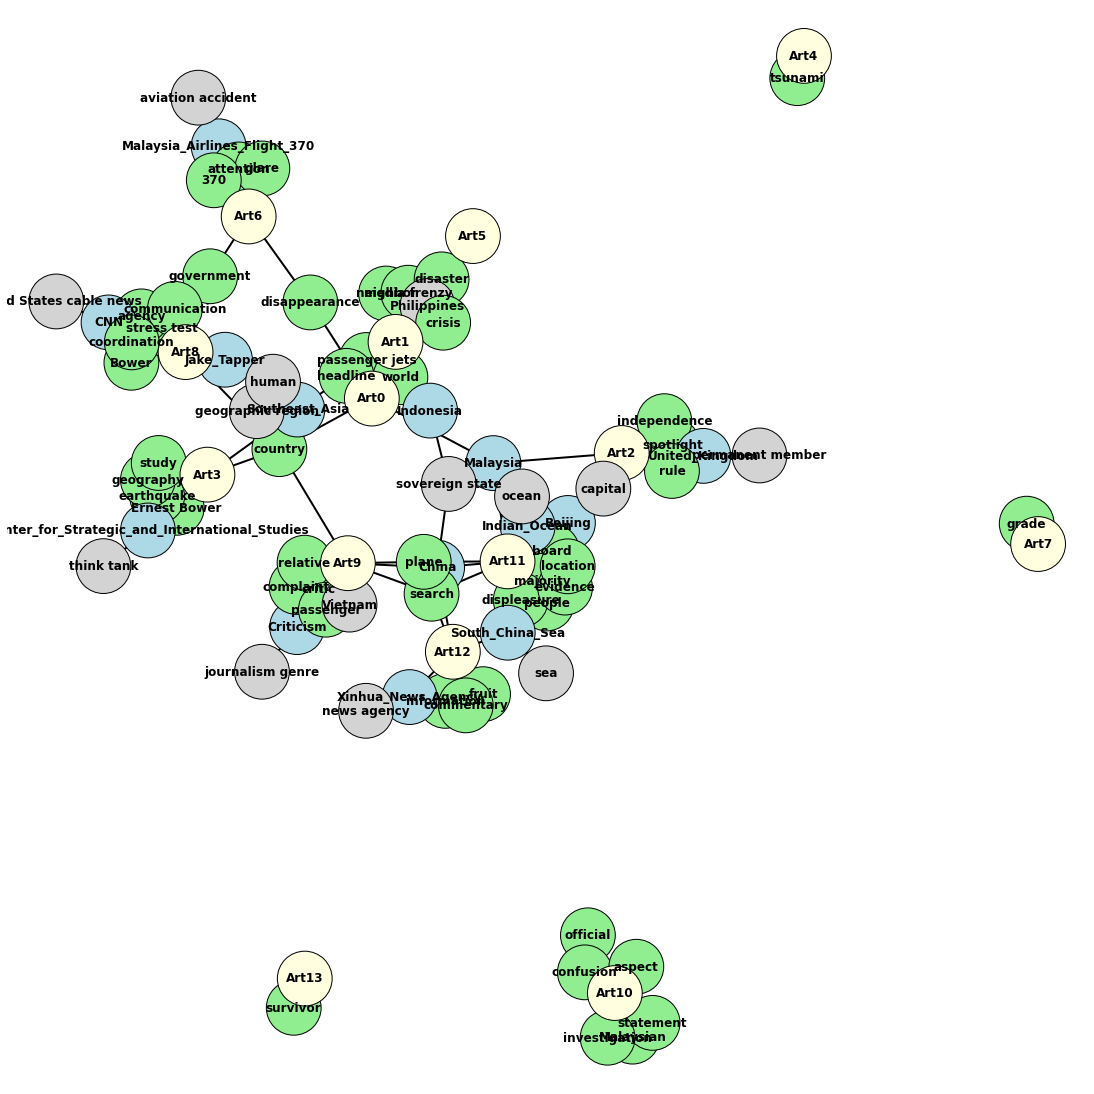

In [373]:
showGraph(G)

utilities to inspect graph nodes.

In [16]:
def showArticle(graph, name):
    print(name, graph.nodes[name]['context'])
    print('all edges from this node are:')
    for x in graph.edges():
        if x[1] == name:
            print(x, graph.nodes[x[0]]['url'], graph.nodes[x[0]]['wikiID'])
            

def showEntity(graph, name):
    instances = []
    classes = []
    print(name,' wikiID=', graph.nodes[name]['wikiID'], 'wikipedia url =', graph.nodes[name]['url'])
    print(graph.nodes[name]['description'])
    inst = graph.nodes[name]['instanceof'] 
    if inst != []:
        instances = instances +inst
        ilist = [i[1] for i in inst]
        print('is an instance of ', ilist)



In [ ]:
showEntity(G, 'campaign')

In [ ]:
showEntity(G, 'political party')

In [ ]:
showArticle(G,"Art2")

Some book keeping

In [406]:
instances = []
classes = []
lines = []
ent_cnt = 0
for nd in G.nodes:
    #print(G.nodes[nd])
    node = G.nodes[nd]
    if node['flavor'] == 'entity':
        ent_cnt +=1
        inst = node['instanceof']
        instances = instances + inst
        clas = node['subclassof']
        classes = classes + clas
    elif node['flavor'] == 'article':
        #print('doing art ',nd, node)
        lines.append([node['context'], nd])
instanceSet = set(instances)
instances = list(instanceSet)
classSet = set(classes)
classes = list(classSet)
print('instances =', len(instances))
print("---------------")
print('classes =', len(classes))
print('lines =', len(lines))
print('entities = ', ent_cnt)

instances = 12
---------------
classes = 0
lines = 14
entities =  77


In [407]:
sentences = [lines[i][0] for i in range(len(lines))]

In [408]:
keys = [lines[i][1] for i in range(len(lines))]

In [409]:
keys

['Art0',
 'Art1',
 'Art2',
 'Art3',
 'Art4',
 'Art5',
 'Art6',
 'Art7',
 'Art8',
 'Art9',
 'Art10',
 'Art11',
 'Art12',
 'Art13']

In [410]:
sentences

["Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.",
 'Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.',
 'But Malaysia has largely managed to stay out of the international spotlight since its independence from British colonial rule more than half a century ago.',
 '"It is one of these countries, because of its geography, that doesn\'t have earthquakes," said Ernest Bower, senior adviser for Southeast Asia studies at the Center for Strategic and International Studies.',
 '"It doesn\'t have tsunamis.',
 'It hasn\'t been tested with a disaster like this."',
 'The disappearance of Malaysia Airlines Flight 370 has thrust the government into the dazzling glare of worldwide attention.',
 "And it hasn't emerge

### WITH USE EMBEDDINGS

In [25]:
import tensorflow as tf
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

### Loading Existing Embeddings for Basic Find_Best

In [392]:
Para_Embeddings = np.load('Para_Embeddings.npy', allow_pickle=True)

In [401]:
Para_Embeddings[1]

<tf.Tensor: shape=(14, 512), dtype=float32, numpy=
array([[-0.00959086, -0.0010345 ,  0.04267713, ..., -0.05540119,
         0.06037474, -0.06003688],
       [-0.04056931,  0.08349683, -0.05298094, ...,  0.06060653,
         0.0668202 , -0.09637776],
       [ 0.06540245,  0.05321302,  0.01686131, ...,  0.0050138 ,
         0.03129216, -0.03308439],
       ...,
       [-0.04557766,  0.02251835,  0.02357472, ..., -0.03208205,
         0.01156668, -0.03285009],
       [-0.02995076, -0.10112616,  0.04577188, ..., -0.01937068,
         0.00235602, -0.04410262],
       [-0.02673139,  0.04535785, -0.08398245, ..., -0.03066632,
        -0.0305725 ,  0.03389304]], dtype=float32)>

In [394]:
Ques_Embeddings = np.load('Ques_Embeddings.npy', allow_pickle=True)

In [395]:
Ques_Embeddings[0]

<tf.Tensor: shape=(12, 512), dtype=float32, numpy=
array([[-0.02335444, -0.02437302, -0.08582116, ...,  0.05580284,
         0.01404525,  0.03490542],
       [ 0.06067836,  0.00770691,  0.02357497, ..., -0.0135384 ,
        -0.10253123,  0.05588945],
       [ 0.00332781,  0.03157982,  0.06085844, ...,  0.09408785,
        -0.02388284,  0.02756161],
       ...,
       [ 0.09039148, -0.03301139,  0.04262282, ...,  0.06946719,
        -0.07055496,  0.03527693],
       [ 0.04434222, -0.02122178,  0.02624882, ..., -0.00422733,
         0.00649624,  0.04344792],
       [ 0.01403348, -0.05871298, -0.02489756, ..., -0.04201954,
        -0.030848  ,  0.00154308]], dtype=float32)>

In [396]:
def find_in_keys(nodeid):
    for i in range(len(keys)):
        if nodeid == keys[i]:
            return i
    return -1


In [398]:
Para_Num

1

In [397]:
mar = Para_Embeddings[Para_Num]

### Para Based Accuracy: Mean of all accuracies

In [424]:
All_Para_Accuracies = [0 for x in range(len(Paragraphs))]

In [423]:
len(Paragraphs)

456

In [425]:
def get_accuracy(got_answers, correct_answers): #Lists Input
    number_matches = len(set(got_answers).intersection(set(correct_answers)))
    total_answers = len(got_answers)
    return number_matches/total_answers
    

## The function find_best
this function takes a sentence and look for the k closest matches based on proximity to the BERT model vectors stored in mar.   This uses dotproduct of normalized vectors which is the same as cosine distance.

In [399]:
def find_best_use(k, ques, show=True):
    print(mar.shape)
    v0 =  ques
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    if show:
        print('top ',k, ' related nodes' )
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    for i in range(k):
        node = keys[norms[i][1]]
        if show:
            print(node)
            print(sentences[norms[i][1]])
    return norms[0:k]

In [474]:
Paragraphs[1]

["Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.",
 'Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.',
 'But Malaysia has largely managed to stay out of the international spotlight since its independence from British colonial rule more than half a century ago.',
 '"It is one of these countries, because of its geography, that doesn\'t have earthquakes," said Ernest Bower, senior adviser for Southeast Asia studies at the Center for Strategic and International Studies.',
 '"It doesn\'t have tsunamis.',
 'It hasn\'t been tested with a disaster like this."',
 'The disappearance of Malaysia Airlines Flight 370 has thrust the government into the dazzling glare of worldwide attention.',
 "And it hasn't emerge

#### Testing with Qs from Dataset

In [428]:
Accuracy_for_Para = []
for i in range(Num_of_Qs):
    ques_num = i
    ques = Ques_Embeddings[Para_Num][ques_num]
    ques_text = data_qs[Para_Num][ques_num]
    print("Ques:", ques_text)
    Num_of_Ans = len(Answer_Para[i])
    Answers_Got = [x[1] for x in find_best_use(Num_of_Ans, ques)]
    Correct_Answers = Answer_Para[i]
    acrcy = get_accuracy(Answers_Got, Correct_Answers)
    print("Got:",Answers_Got)
    print("Correct",Correct_Answers)
    print("Accuracy:",acrcy)
    Accuracy_for_Para.append(acrcy)
mean_accuracy = np.mean(Accuracy_for_Para)
All_Para_Accuracies[Para_Num] = mean_accuracy
print(mean_accuracy)

Ques: What are two example of natural disasters that Malaysia does not experience?
(14, 512)
top  3  related nodes
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.
Art0
Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.
Art5
It hasn't been tested with a disaster like this."
Got: [1, 0, 5]
Correct [2, 3, 4]
Accuracy: 0.0
Ques: Why are Chinese and Vietnamese officials critical of the Malaysian response?
(14, 512)
top  4  related nodes
Art10
 Malaysian officials have created confusion by issuing contradictory statements on key aspects of the investigation.
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and a

### Basic Find Best overall accuracy

In [506]:
def find_best_use_all(mar, k, ques):
    print(mar.shape)
    v0 =  ques
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    return norms[0:k]

In [539]:
All_Para_Accuracies = [0 for x in range(100)]

In [540]:
Para_Answers = 0

In [541]:
for Para_Num in range(100):
    Accuracy_for_Para = []
    Answer_Para = answer_qs[Para_Num]
    para_factor = sum([len(x) for x in Answer_Para])
    Para_Answers+= para_factor
    Questions = data_qs[Para_Num]
    Num_of_Qs = len(Questions)
    for i in range(Num_of_Qs):
        mar = Para_Embeddings[Para_Num]
        ques_num = i
        ques = Ques_Embeddings[Para_Num][ques_num]
        ques_text = data_qs[Para_Num][ques_num]
        print("Ques:", ques_text)
        Num_of_Ans = len(Answer_Para[i])
        Answers_Got = [x[1] for x in find_best_use_all(mar, Num_of_Ans, ques)]
        Correct_Answers = Answer_Para[i]
        acrcy = get_accuracy(Answers_Got, Correct_Answers)
        print("Got:",Answers_Got)
        print("Correct",Correct_Answers)
        print("Accuracy:",acrcy)
        Accuracy_for_Para.append(acrcy)
    mean_accuracy = np.mean(Accuracy_for_Para)
    All_Para_Accuracies[Para_Num] = mean_accuracy*para_factor
    print(mean_accuracy)

Ques: Does the author claim the animated films message is that the NRA upholds racism?
(15, 512)
Got: [3, 2, 9, 1]
Correct [1, 2, 3, 5]
Accuracy: 0.75
Ques: Which key message(s) do(es) this passage say the critics ignored?
(15, 512)
Got: [6, 1]
Correct [2, 6]
Accuracy: 0.5
Ques: What type of the film is being discussed and what is on of the key messages?
(15, 512)
Got: [6, 1]
Correct [0, 5]
Accuracy: 0.0
Ques: Which type of rights are being discussed and promoted by which group?
(15, 512)
Got: [3, 2]
Correct [2, 3]
Accuracy: 1.0
Ques: In the author's mind, which characterization of the Buell school shooter is more appropriate? "Thug" or "Bastard"?
(15, 512)
Got: [7, 9, 8]
Correct [9, 11, 8]
Accuracy: 0.6666666666666666
Ques: Does the author know whether the 19th century NRA in southern states promoted gun rights for black people?
(15, 512)
Got: [3, 2]
Correct [3, 4]
Accuracy: 0.5
Ques: It is believed that which group tolerated crack sales raising what other questions>
(15, 512)
Got: [2

Got: [8, 7]
Correct [7, 8]
Accuracy: 1.0
Ques: What people are killed by trucks?
(17, 512)
Got: [14, 7, 2]
Correct [14, 2, 3]
Accuracy: 0.6666666666666666
Ques: How many times was the haunted Indian ground mentioned?
(17, 512)
Got: [1, 8, 11, 5]
Correct [0, 1, 2, 3]
Accuracy: 0.25
Ques: What was the rumor about the pet cemetery that Victor warned Louis about?
(17, 512)
Got: [5, 15]
Correct [1, 5]
Accuracy: 0.5
Ques: Who is the Creed family?
(17, 512)
Got: [0, 2, 1]
Correct [0, 2, 7]
Accuracy: 0.6666666666666666
Ques: How many truck accidents were there in the passage?
(17, 512)
Got: [14, 0, 2]
Correct [14, 2, 7]
Accuracy: 0.6666666666666666
Ques: What interaction do Louis and Victor have?
(17, 512)
Got: [5, 10, 11]
Correct [2, 3, 5]
Accuracy: 0.3333333333333333
Ques: Where was Gage killed by a truck?
(17, 512)
Got: [14, 7, 2]
Correct [0, 14, 7]
Accuracy: 0.6666666666666666
Ques: Who was hit by a truck?
(17, 512)
Got: [2, 14]
Correct [0, 1]
Accuracy: 0.0
Ques: What states are named in t

Got: [12, 6]
Correct [12, 6]
Accuracy: 1.0
Ques: How long from the time that the president was told a second plane hit the second tower, did it take for air sovereignty aircraft to be directed to battle stations
(19, 512)
Got: [6, 2]
Correct [2, 6]
Accuracy: 1.0
Ques: How long after the commander of NORAD directed all air sovereignty aircraft to battle stations did United 93 crash in Pennsylvania?
(19, 512)
Got: [2, 5]
Correct [2, 5]
Accuracy: 1.0
Ques: What commander is able to direct all airs sovereignty aircrafts
(19, 512)
Got: [2, 1]
Correct [0, 1]
Accuracy: 0.5
Ques: Who made a brief statement before going to the airport
(19, 512)
Got: [14, 17]
Correct [11, 14]
Accuracy: 0.5
Ques: Did The President see television coverage of the Delta 93 crash in Pennsylvania before leaving for the airport?
(19, 512)
Got: [5, 0, 6, 12]
Correct [12, 14, 16, 5]
Accuracy: 0.5
Ques: What were some of the President's first thoughts upon hearing of the attacks?
(19, 512)
Got: [16, 8, 0]
Correct [9, 10, 

Got: [11, 9, 0, 12]
Correct [10, 11, 12, 13]
Accuracy: 0.5
Ques: What happens to the living creature that fails to adapt to changes?
(15, 512)
Got: [4, 6, 7, 8]
Correct [4, 5, 6, 7]
Accuracy: 0.75
Ques: What happens when some living organism do not adapt to changes in the environment?
(15, 512)
Got: [4, 6, 0, 5]
Correct [4, 6, 7, 8]
Accuracy: 0.5
Ques: What two things can happen to living organisms when the environment changes?
(15, 512)
Got: [4, 6, 0]
Correct [4, 6, 7]
Accuracy: 0.6666666666666666
Ques: What are geologists?
(15, 512)
Got: [9, 11, 10]
Correct [9, 10, 11]
Accuracy: 1.0
Ques: Besides rocks, what else do geologists study to find clues to make sense of past events?
(15, 512)
Got: [9, 11, 10, 12]
Correct [9, 10, 11, 12]
Accuracy: 1.0
Ques: What do geologists study to give them clues about the Earth's past?
(15, 512)
Got: [9, 10, 11]
Correct [9, 10, 11]
Accuracy: 1.0
Ques: According to this passage, on what planet do mountains grow and wear away?
(15, 512)
Got: [2, 9]
Correc

Got: [12, 11]
Correct [11, 12]
Accuracy: 1.0
Ques: After the eviction of Penny Sweat, who was unaware of her rights?
(15, 512)
Got: [0, 7]
Correct [0, 1]
Accuracy: 0.5
Ques: What was the issue with Penny Sweat and Lee Kemp
(15, 512)
Got: [9, 4, 13]
Correct [0, 9, 2]
Accuracy: 0.3333333333333333
Ques: Which two people were unfairly evicted from there homes?
(15, 512)
Got: [10, 9]
Correct [0, 2]
Accuracy: 0.0
Ques: What was the rate of apartments Penny Sweat had to move to?
(15, 512)
Got: [0, 13]
Correct [0, 13]
Accuracy: 1.0
Ques: Who was evicted in addition to Penny Sweat?
(15, 512)
Got: [0, 9]
Correct [0, 2]
Accuracy: 0.5
Ques: What Penny Sweat and Lee Kemp were unaware about?
(15, 512)
Got: [4, 0]
Correct [0, 2]
Accuracy: 0.5
Ques: Who knew what Penny's rights were?
(15, 512)
Got: [0, 6]
Correct [5, 6]
Accuracy: 0.5
0.5069444444444444
Ques: When did Unit 93 drop?
(18, 512)
Got: [1, 11]
Correct [0, 1]
Accuracy: 0.5
Ques: How many seconds into decent was the second call?
(18, 512)
Got:

Got: [0, 7]
Correct [0, 1]
Accuracy: 0.5
Ques: What do we know about wind from the paragraph?
(12, 512)
Got: [6, 10]
Correct [0, 1]
Accuracy: 0.0
Ques: What is the vertical distance between a crest and a trough?
(12, 512)
Got: [2, 4]
Correct [2, 3]
Accuracy: 0.5
Ques: How do you calculate the height of a wave?
(12, 512)
Got: [2, 3, 5]
Correct [0, 1, 2]
Accuracy: 0.3333333333333333
Ques: What are a hurricane's winds like?
(12, 512)
Got: [9, 8]
Correct [10, 11]
Accuracy: 0.0
Ques: When concerning wave height, what are the highest and lowest points called?
(12, 512)
Got: [0, 3]
Correct [0, 1]
Accuracy: 0.5
Ques: What is the difference between wavelength and amplitude?
(12, 512)
Got: [5, 4]
Correct [3, 4]
Accuracy: 0.5
Ques: Other factors being equal, why would an ocean wave be larger if the wind were blowing 150 miles per hour than if it the wind were blowing 100 miles per hour?
(12, 512)
Got: [6, 7]
Correct [6, 7]
Accuracy: 1.0
0.33333333333333337
Ques: Did Joey and Max prefer playing at

Got: [8, 13, 2]
Correct [1, 2, 7]
Accuracy: 0.3333333333333333
Ques: Who made Joey?
(14, 512)
Got: [8, 13, 9]
Correct [0, 2, 7]
Accuracy: 0.0
Ques: Who does she keep in a plastic bag in her pocket?
(14, 512)
Got: [11, 12]
Correct [11, 7]
Accuracy: 0.5
Ques: What color was Marsha noodle friend when she first saw him?
(14, 512)
Got: [0, 3]
Correct [0, 2]
Accuracy: 0.5
Ques: What was the name of Marsha's noodle friend?
(14, 512)
Got: [3, 7]
Correct [6, 7]
Accuracy: 0.5
Ques: On what day of the week did Marsha meet Joey?
(14, 512)
Got: [9, 7]
Correct [3, 5]
Accuracy: 0.0
Ques: What color was Marsha's friend before turning dark brown?
(14, 512)
Got: [1, 2]
Correct [1, 2]
Accuracy: 1.0
Ques: What day of the week did Marsha meet her noodle friend?
(14, 512)
Got: [0, 3]
Correct [3, 4]
Accuracy: 0.5
Ques: What looked like a stickman to Marsha?
(14, 512)
Got: [6, 0]
Correct [5, 6]
Accuracy: 0.5
Ques: What color was Joey when Marsha used to put him under pillow?
(14, 512)
Got: [9, 10, 2]
Correct 

Got: [17, 5]
Correct [16, 17]
Accuracy: 0.5
Ques: How does Mr. Thorndike describe the weather of the day?
(20, 512)
Got: [5, 0, 10, 7]
Correct [11, 12, 3, 4]
Accuracy: 0.0
Ques: What was the weather like?
(20, 512)
Got: [3, 4, 11]
Correct [11, 3, 4]
Accuracy: 1.0
Ques: What is the name of the shy, silent stenographer about to be put in jail for theft?
(20, 512)
Got: [8, 9, 5]
Correct [9, 2, 8]
Accuracy: 0.6666666666666666
Ques: What did Mr. Thorndike want to do at the Court of General Sessions?
(20, 512)
Got: [17, 5, 10]
Correct [17, 18, 19]
Accuracy: 0.3333333333333333
Ques: Mr. Thorndike mentions impulses--what does he say?
(20, 512)
Got: [5, 10]
Correct [14, 15]
Accuracy: 0.0
0.38333333333333336
Ques: During the two trips taken to the Persian Gulf, the NSC spoke to officials from what country?
(18, 512)
Got: [16, 17]
Correct [16, 17]
Accuracy: 1.0
Ques: Who met with the US Ambassador to discuss giving up Bin Laden?
(18, 512)
Got: [4, 3]
Correct [3, 4]
Accuracy: 1.0
Ques: What event 

Got: [6, 5]
Correct [4, 5]
Accuracy: 0.5
Ques: The local bar paid $5 for what building?
(16, 512)
Got: [5, 12]
Correct [4, 5]
Accuracy: 0.5
Ques: How many years after buying buildings in Charleston and Georgetown did the NLAP buy again?
(16, 512)
Got: [2, 4]
Correct [2, 3]
Accuracy: 0.5
Ques: The local bar in Charleston County maintained which building of the NLAP in exchange for "legal services" to certain residences?
(16, 512)
Got: [6, 4]
Correct [4, 6]
Accuracy: 1.0
Ques: What building did the Charleston County Bar Association pay $5 for?
(16, 512)
Got: [12, 5]
Correct [4, 5]
Accuracy: 0.5
0.5454545454545454
Ques: From the time Atta and Omari boarded their flight in Portland, how long did it take them to reach Boston
(18, 512)
Got: [10, 14]
Correct [10, 14]
Accuracy: 1.0
Ques: How was Atta's and Omari's trip through airport security different?
(18, 512)
Got: [7, 10, 12]
Correct [10, 11, 12]
Accuracy: 0.6666666666666666
Ques: At what time did Atta end his call with Marwan Al Shehhi?


Got: [12, 15]
Correct [13, 14]
Accuracy: 0.0
Ques: What can happen if you place a cake in an oven and apply too much heat or set the oven heat too high?
(18, 512)
Got: [4, 7, 0]
Correct [4, 6, 7]
Accuracy: 0.6666666666666666
Ques: What causes things to burn?
(18, 512)
Got: [1, 6]
Correct [1, 2]
Accuracy: 0.5
Ques: What kind of changes can be caused by temperature?
(18, 512)
Got: [11, 3, 17]
Correct [11, 17, 3]
Accuracy: 1.0
Ques: What can heat cause?
(18, 512)
Got: [1, 2]
Correct [9, 8]
Accuracy: 0.0
Ques: Why do things burn?
(18, 512)
Got: [1, 6]
Correct [2, 3]
Accuracy: 0.0
Ques: What is the physical change in temperature we see during the summer and how does it occur?
(18, 512)
Got: [11, 17, 16]
Correct [12, 14, 15]
Accuracy: 0.0
Ques: What is are some physical changes caused by temperature?
(18, 512)
Got: [11, 3, 17]
Correct [15, 4, 6]
Accuracy: 0.0
Ques: What can cause a physical change to water?
(18, 512)
Got: [16, 11]
Correct [16, 17]
Accuracy: 0.5
Ques: Give two examples of how

Got: [4, 13]
Correct [11, 13]
Accuracy: 0.5
Ques: In 2001, the draft presidential directive circulated how many months after the leadership of Deputy Secretary Wolfowitz was confirmed?
(18, 512)
Got: [5, 17]
Correct [17, 5]
Accuracy: 1.0
Ques: Who thought that the Defense Department, before 9/11, was not organized adequately to deal with terrorist threats
(18, 512)
Got: [12, 14]
Correct [11, 12]
Accuracy: 0.5
Ques: What is the last name of the man who criticized the Defence Department for not being organized adequately prior to 9/11?
(18, 512)
Got: [12, 9]
Correct [11, 12]
Accuracy: 0.5
Ques: What is the last name of the American official who met with Crown Prince Abdullah twice prior to 9/11 to discuss topics like Iraq and Israeli-Palestinian violence?
(18, 512)
Got: [1, 2]
Correct [2, 3]
Accuracy: 0.5
Ques: What position was vacant from January 2001 and had not been replaced before 9/11?
(18, 512)
Got: [10, 0]
Correct [9, 10]
Accuracy: 0.5
Ques: What did the Secretary of State and th

Got: [7, 3]
Correct [2, 3]
Accuracy: 0.5
Ques: Who created the eastern transept?
(13, 512)
Got: [7, 6]
Correct [6, 7]
Accuracy: 1.0
Ques: What architectural style the Angel Choir belongs to?
(13, 512)
Got: [10, 11]
Correct [10, 11]
Accuracy: 1.0
Ques: Which feature of the mighty fane has rich arcading of Late Norman and Early English periods?
(13, 512)
Got: [3, 11]
Correct [1, 3]
Accuracy: 0.5
Ques: What object is contained within the fane and what is significant about the design of its center?
(13, 512)
Got: [2, 12]
Correct [1, 2]
Accuracy: 0.5
Ques: Which building's spires were removed in 1807?
(13, 512)
Got: [4, 5]
Correct [0, 4]
Accuracy: 0.5
Ques: Who is responsible for the rebuilding of the choir and eastern transept?
(13, 512)
Got: [6, 7]
Correct [5, 6]
Accuracy: 0.5
Ques: What is the church's most striking feature?
(13, 512)
Got: [12, 2]
Correct [0, 1]
Accuracy: 0.0
Ques: What is the style of the interior cathedral and why is there a problem with the choir?
(13, 512)
Got: [10, 

(18, 512)
Got: [0, 1]
Correct [0, 1]
Accuracy: 1.0
Ques: What is a magnetic force?
(18, 512)
Got: [1, 10]
Correct [0, 1]
Accuracy: 0.5
Ques: Does a magnet have to be touching an object to assert push or pull?
(18, 512)
Got: [11, 9, 0]
Correct [9, 10, 11]
Accuracy: 0.6666666666666666
Ques: What are a few examples of non-contact force?
(18, 512)
Got: [13, 15, 14]
Correct [10, 11, 15]
Accuracy: 0.3333333333333333
Ques: The force you exert on your bike pedals that causes change is called what?
(18, 512)
Got: [4, 13, 1]
Correct [4, 5, 6]
Accuracy: 0.3333333333333333
Ques: Name a few types of non contact force
(18, 512)
Got: [13, 15]
Correct [16, 1]
Accuracy: 0.0
Ques: What can magnets do?
(18, 512)
Got: [7, 0]
Correct [0, 1]
Accuracy: 0.5
Ques: How do magnets produce change?
(18, 512)
Got: [7, 0]
Correct [7, 8]
Accuracy: 0.5
Ques: What are non contact forces?
(18, 512)
Got: [13, 14]
Correct [13, 14]
Accuracy: 1.0
Ques: How do magnets exert force?
(18, 512)
Got: [0, 2]
Correct [10, 11]
Accur

Got: [5, 6]
Correct [5, 6]
Accuracy: 1.0
Ques: Where does the heat deep in the Earth try to go?
(17, 512)
Got: [1, 3]
Correct [1, 3]
Accuracy: 1.0
Ques: Why does the system work as a conveyor belt?
(17, 512)
Got: [15, 16]
Correct [0, 15]
Accuracy: 0.5
Ques: Which direction does the mantle move?
(17, 512)
Got: [10, 5]
Correct [9, 10]
Accuracy: 0.5
Ques: What happens when the mantle material that is near the surface starts to cool?
(17, 512)
Got: [11, 6]
Correct [11, 12]
Accuracy: 0.5
Ques: Where do sea trenches occur?
(17, 512)
Got: [13, 1, 7]
Correct [11, 12, 13]
Accuracy: 0.3333333333333333
Ques: Does rock move more at the surface of the earth or at its core?
(17, 512)
Got: [4, 1]
Correct [0, 1]
Accuracy: 0.5
Ques: What is the coolest part of the earth?
(17, 512)
Got: [2, 1]
Correct [5, 6]
Accuracy: 0.0
Ques: The hottest part of the earth is?
(17, 512)
Got: [1, 2]
Correct [1, 2]
Accuracy: 1.0
Ques: Why does the material move horizontally?
(17, 512)
Got: [9, 10, 14]
Correct [9, 10, 8]


Got: [8, 0]
Correct [6, 8]
Accuracy: 0.5
Ques: How do Georgia's lawyers compare to lawyers nationally in pro-bone participation?
(18, 512)
Got: [13, 7]
Correct [14, 17]
Accuracy: 0.0
Ques: Before Barnes became governor, what organization did he often volunteer with?
(18, 512)
Got: [8, 0, 1]
Correct [0, 9, 8]
Accuracy: 0.6666666666666666
Ques: How many lawyers are available in Georgia for people who have an annual income of $11,075 or less?
(18, 512)
Got: [7, 13]
Correct [6, 7]
Accuracy: 0.5
Ques: Who secured a $115 million judgment in 1993 against Fleet Finance for victimizing 18,000 homeowners?
(18, 512)
Got: [10, 14]
Correct [0, 10]
Accuracy: 0.5
Ques: Was Gov. Roy Barnes Election Day 2002 defeat expected?
(18, 512)
Got: [1, 8]
Correct [0, 1]
Accuracy: 0.5
Ques: As a private citizens, Barnes will be working pro-bono in what field of law?
(18, 512)
Got: [0, 13]
Correct [0, 1]
Accuracy: 0.5
Ques: Who does Barnes want to help while working as a legal aid lawyer?
(18, 512)
Got: [0, 2]
Co

Got: [6, 1]
Correct [0, 1]
Accuracy: 0.5
Ques: Who loves to look for blueberries together?
(11, 512)
Got: [2, 3]
Correct [0, 2]
Accuracy: 0.5
Ques: What scare did Max give Mary with what result?
(11, 512)
Got: [1, 0, 10]
Correct [9, 4, 6]
Accuracy: 0.0
Ques: What did Max and Mary like to do in the woods?
(11, 512)
Got: [0, 1]
Correct [0, 2]
Accuracy: 0.5
Ques: Who did not give up looking for Max?
(11, 512)
Got: [6, 3, 7, 0]
Correct [3, 5, 6, 7]
Accuracy: 0.75
Ques: Does Mary's dog listen to and obey Mary?
(11, 512)
Got: [0, 7]
Correct [0, 10]
Accuracy: 0.5
0.3125
Ques: Who became sick and died heirless?
(18, 512)
Got: [9, 6]
Correct [9, 8]
Accuracy: 0.5
Ques: Why was Portugal's conquest of many ports said to not be "blood-soaked"?
(18, 512)
Got: [11, 15, 2, 12]
Correct [0, 1, 2, 3]
Accuracy: 0.25
Ques: The death of Sebastião and 18,000 followers was precipitated by what event?
(18, 512)
Got: [6, 17]
Correct [5, 6]
Accuracy: 0.5
Ques: What happened during Sebastião's reign as king?
(18,

Got: [11, 3]
Correct [12, 2]
Accuracy: 0.0
Ques: What did the small room look like?
(14, 512)
Got: [3, 12]
Correct [3, 4]
Accuracy: 0.5
Ques: Who did the dog accompany?
(14, 512)
Got: [1, 0]
Correct [0, 1]
Accuracy: 1.0
Ques: Why did Rolfe stop his search in the first room?
(14, 512)
Got: [2, 8, 5]
Correct [5, 6, 7]
Accuracy: 0.3333333333333333
Ques: How many bedrooms did Rolfe examine?
(14, 512)
Got: [2, 8]
Correct [12, 2]
Accuracy: 0.5
Ques: What is the name of the Inspector who flung open the door of the wardrobe?
(14, 512)
Got: [6, 2]
Correct [2, 6]
Accuracy: 1.0
0.47916666666666663
Ques: Is an arrow released from a bow an example of mechanical energy?
(14, 512)
Got: [12, 11]
Correct [0, 12]
Accuracy: 0.5
Ques: What type of energy is released when a drawn bow releases an arrow?
(14, 512)
Got: [12, 11]
Correct [11, 12]
Accuracy: 1.0
Ques: Does stored energy require motion?
(14, 512)
Got: [6, 2]
Correct [9, 8]
Accuracy: 0.0
Ques: What kind of energy does a moving ball have?
(14, 512)

In [542]:
overall_accuracy = sum(All_Para_Accuracies)/Para_Answers

In [543]:
overall_accuracy

0.5214957948195138

## find_best2
the function find_best2 is more complicated.  

The function findClue extracts entities from the sentence and then looks for the closest match in all of the articles among those that have the same entities.  if there are more than 2 with the max number of matches we just give up and return [].   

To compute the convolutions we need to find all the neighbors of each node.  two nodes are neighbors if they share an entity node.   note that in the computation of findNeighbors we exclude two super nodes "albert_einstein" and "earth".   these node make too many nodes neighbors. 

ComputeMar2 is the function that computes the convolution matrix mar2.   

Function find_best_wl2 is a version of find_best that uses a article nodeID rather than a document to rank near nodes (based on mar2)  it is a utility used in find_best2

Function find_best2 looks for clues.  there are either 0, 1 or 2 clues.   if there are 0 clues we use find_best(1 ...) to give us a guess.    if there are 1 or 2 clues we use them in find_best_wl2 to complete the list.  (in the case of 2 clues we use the first clue to generate the first two replies and the second clue to get the rest.  



In [163]:
def findClue(G, sent, show = True):
    cls = entityExtractorBlock(sent)
    #Format returned in : (ent.name, wikidataId, wikipage)
    if(cls==[]):
        cls = get_ents(sent)
        #print("clues",cls)
    #print("Normal Clues",cls)
    clsent = [x[0] for x in cls]
    if show:
        print(clsent)
    arts = []
    for x in cls:
        item = x[0]
        for edg in G.edges():
            #print(edg)
            if edg[0] == item and G.nodes[edg[1]]['flavor'] == 'article':
                arts.append(edg[1])
    artset = set(arts)
    artnames = list(artset)
    factoredartnames = []
    for art in artnames:
        #context = G.nodes[art]['context']
        #print('context=',context)
        cls1ent = G.nodes[art]['ent-list']
        #cls1ent = [x[0] for x in cls1]
        cls1int = set(clsent).intersection(set(cls1ent))
        if cls1int != set():
            factoredartnames.append((art, len(cls1int)))
        artnames = [x[0] for x in factoredartnames]
    if show:
        print('artnames=',artnames)
    dic = {}
    for x in artnames:
        dic[x] = 0
    for x in factoredartnames:
        dic[x[0]] = x[1]
    #print('DIC =',dic)
    bmax = 0
    bestmax = ''
    for x in artnames:
        if dic[x] > bmax:
            bmax = dic[x]
            #print(x)
            bestmax = x
    count_ties = 0
    tie_list = []
    for x in artnames:
        if dic[x] == bmax:
            count_ties += 1
            tie_list.append(x)
    if show:
        print(count_ties, 'nodes out of',len(artnames), 'matched the max value of ', bmax)
    if count_ties >  0.5*len(artnames) and len(artnames)> 2:
        return  []
    return tie_list
   

def findNeighbors(g, art):
    n = g.nodes[art]
    #print(n)
    features = []
    neighbors = []
    for x in g.edges:
        if x[1] == art:
            #print('found art in ',x)
            p = x[0]
            features.append(p)
            for y in g.edges:
                    if y[0] == p:
                        if y[1] != art:
                            #print(y[1][0:3])
                            if y[1][0:3] != 'Art':
                                features.append(y[1])
                            else:
                                neighbors.append(y[1])
    return neighbors, features

mar2 = np.zeros((mar.shape[0], mar.shape[1]))
def computeMar2(G, mar, lambd): #Graph Convolution Function
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            print("Article:",art)
            print("neighbours", neighbors)
            print("features", features)
            v = np.zeros(mar.shape[1])
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar2[find_in_keys(art)] = z
            else:
                mar2[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts


def find_best2(k, abstract,embedding,show=True):
    cls = findClue(G, abstract, show)
    print('clues are =', cls)
    if cls != []:
        best = cls[0]
    else:
        x = find_best_use(1, embedding, show=False)
        best = keys[x[0][1]]
    if(len(cls)> 1):
        normsa = find_best_wl2(2, cls[0], show)
        normsb = find_best_wl2(k-2, cls[1], show)
        norms = normsa+normsb
    else:
        norms = find_best_wl2(k, best, show)
    return norms


def find_best_wl2(k, nodeid, show=True):
    #print(nodeid)
    v0 = mar2[find_in_keys(nodeid)]
    norms = []
    for i in range(mar2.shape[0]):
        norms.append([np.dot(v0,mar2[i]), i])
    norms.sort(reverse=True)
    #if show:
    #    print('top ',k, ' related nodes' )
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(k):
        node = keys[norms[i][1]]
        sent = sentences[norms[i][1]]
        #print('node = ', node)
        if show:
            print(node)
            print(sent)
    return norms[0:k]
            
def showRelated(G,art):
    print( G.nodes[art]['context'])
    neighbors, features =  findNeighbors(G, art)
    n = set(neighbors)
    neighbors = list(n)
    print(neighbors)
    for x in neighbors:
        print( G.nodes[x]['context'])
        v0 = mar[find_in_keys(art)]
        v1 = mar[find_in_keys(x)]
        print(" dot prod =", np.dot(v0,v1))
    print(features)



### USE with Convoluted Embeddings for Articles

In [449]:
mar2 = np.zeros((mar.shape[0], mar.shape[1]))
def computeMar2(G, mar, lambd): #Graph Convolution Function
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            print("Article:",art)
            print("neighbours", neighbors)
            print("features", features)
            v = np.zeros(mar.shape[1])
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar2[find_in_keys(art)] = z
            else:
                mar2[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts

In [448]:
mar = Para_Embeddings[1]

In [450]:
computeMar2(G, mar, 0.8)

Article: Art0
neighbours ['Art2', 'Art11', 'Art6', 'Art3', 'Art8', 'Art9']
features ['Malaysia', 'sovereign state', 'disappearance', 'country', 'passenger jets', 'headline', 'world']
Article: Art1
neighbours ['Art3', 'Art5']
features ['Southeast_Asia', 'geographic region', 'neighbor', 'media frenzy', 'disaster', 'Philippines', 'Indonesia', 'crisis']
Article: Art2
neighbours ['Art0', 'Art11']
features ['Malaysia', 'sovereign state', 'spotlight', 'independence', 'United_Kingdom', 'permanent member', 'rule']
Article: Art3
neighbours ['Art0', 'Art8', 'Art9', 'Art1']
features ['country', 'Southeast_Asia', 'geographic region', 'Ernest Bower', 'earthquake', 'geography', 'Center_for_Strategic_and_International_Studies', 'think tank', 'study']
Article: Art4
neighbours []
features ['tsunami']
Article: Art5
neighbours ['Art1']
features ['disaster']
Article: Art6
neighbours ['Art0', 'Art8']
features ['disappearance', 'government', 'Malaysia_Airlines_Flight_370', 'aviation accident', 'attention', '

(4, 3.0)

In [452]:
mar2.shape

(14, 512)

In [451]:
mar.shape

TensorShape([14, 512])

In [453]:
def find_best_use_conv(k, mar, ques, show=True):
    v0 =  ques#embed(abstract)
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    if show:
        print('top ',k, ' related nodes' )
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    for i in range(k):
        node = keys[norms[i][1]]
        if show:
            print(node)
            print(sentences[norms[i][1]])
    return norms[0:k]

In [473]:
Accuracy_for_Para = []
Para_Num = 1
Answer_Para = answer_qs[Para_Num]
Questions = data_qs[Para_Num]
Num_of_Qs = len(Questions)
for i in range(Num_of_Qs):
    ques_num = i
    ques = Ques_Embeddings[Para_Num][ques_num]
    ques_text = data_qs[Para_Num][ques_num]
    print("Ques:", ques_text)
    Num_of_Ans = len(Answer_Para[i])
    Answers_Got = [x[1] for x in find_best_use_conv(Num_of_Ans, mar3, ques)]
    Correct_Answers = Answer_Para[i]
    acrcy = get_accuracy(Answers_Got, Correct_Answers)
    print("Accuracy:",acrcy)
    print("Got:",Answers_Got)
    print("Correct",Correct_Answers)
    Accuracy_for_Para.append(acrcy)

mean_accuracy = np.mean(Accuracy_for_Para)
print(mean_accuracy)
    
    

Ques: What are two example of natural disasters that Malaysia does not experience?
top  3  related nodes
Art5
It hasn't been tested with a disaster like this."
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.
Art3
"It is one of these countries, because of its geography, that doesn't have earthquakes," said Ernest Bower, senior adviser for Southeast Asia studies at the Center for Strategic and International Studies.
Accuracy: 0.3333333333333333
Got: [5, 1, 3]
Correct [2, 3, 4]
Ques: Why are Chinese and Vietnamese officials critical of the Malaysian response?
top  4  related nodes
Art2
But Malaysia has largely managed to stay out of the international spotlight since its independence from British colonial rule more than half a century ago.
Art0
Before the mysterious disappearance of one of its passenger jets this mo

In [229]:
ques_num = 1

In [231]:
ques = Ques_Embeddings[Para_Num][ques_num]
ques_text = data_qs[Para_Num][ques_num]
print("Ques:", ques_text)
find_best_use_conv(2, mar2, ques)

Ques: Which key message(s) do(es) this passage say the critics ignored?
top  2  related nodes
Art6
This is the key message of this part of the animation, which is again being ignored by its critics.
Art1
Of course the cartoon is highly oversimplified, and most critics consider it one of the weakest parts of the film.


[[0.4423114547493445, 6], [0.27653367034648313, 1]]

In [212]:
ques = Ques_Embeddings[Para_Num][ques_num]
ques_text = data_qs[Para_Num][ques_num]
print("Ques:", ques_text)
find_best_use(4, ques)

Ques: Which type of rights are being discussed and promoted by which group?
top  4  related nodes
Art3
Did the 19th century NRA in the southern states promote gun rights for black people?
Art2
But it makes a valid claim which you ignore entirely: That the strategy to promote "gun rights" for white people and to outlaw gun possession by black people was a way to uphold racism without letting an openly terrorist organization like the KKK flourish.
Art5
But if they didn't, one of their functions was to continue the racism of the KKK.
Art12
 But why do people deal with drugs?


[[0.22711581, 3], [0.16377448, 2], [0.05284371, 5], [0.042329676, 12]]

### Trying with another Convolution

In [457]:
def computeMar3(G, mar, lambd):
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            v = np.zeros(mar.shape[1])
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar3[find_in_keys(art)] = z
            else:
                mar3[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts


In [458]:
mar3 = np.zeros((mar.shape[0], mar.shape[1]))
computeMar3(G, mar2,0.8)

(4, 3.0)

In [472]:
computeMar3(G, mar3,0.8)

(4, 3.0)

In [310]:
mar3

array([[-0.00987825, -0.13185186,  0.01273129, ...,  0.02436218,
         0.01254944,  0.04655562],
       [-0.07411403, -0.0440148 ,  0.00106488, ...,  0.00775546,
         0.03265558,  0.0269998 ],
       [-0.01465142, -0.12776715, -0.09209476, ...,  0.05102053,
         0.03977982,  0.00957798],
       ...,
       [ 0.0278475 , -0.05635135, -0.00856109, ..., -0.00090087,
         0.02650938, -0.00112581],
       [ 0.03838673, -0.01887815,  0.03731984, ..., -0.04768466,
        -0.02261458, -0.0073561 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [303]:
mar2

array([[-0.01154379, -0.12491008,  0.02185292, ...,  0.02442696,
         0.0080754 ,  0.04504379],
       [-0.07427887, -0.04443317,  0.02893816, ..., -0.00425209,
         0.03544415,  0.02841026],
       [-0.01633071, -0.11440796, -0.10502658, ...,  0.0545803 ,
         0.04150568,  0.00397853],
       ...,
       [ 0.03255021, -0.0536986 , -0.01214659, ..., -0.00149955,
         0.02997044, -0.00174961],
       [ 0.03838673, -0.01887815,  0.03731984, ..., -0.04768466,
        -0.02261458, -0.0073561 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [302]:
mar

<tf.Tensor: shape=(15, 512), dtype=float32, numpy=
array([[-0.01274004, -0.11565759,  0.03097722, ...,  0.02448403,
         0.00251936,  0.04266088],
       [-0.06971727, -0.04264623,  0.05854981, ..., -0.01652756,
         0.03496636,  0.0289634 ],
       [-0.01743965, -0.09696124, -0.11560833, ...,  0.05650649,
         0.04247527, -0.00178425],
       ...,
       [ 0.03638124, -0.05021678, -0.01674846, ..., -0.00129548,
         0.03262155, -0.00195663],
       [ 0.03838673, -0.01887815,  0.03731984, ..., -0.04768466,
        -0.02261458, -0.0073561 ],
       [ 0.02464328, -0.02262432,  0.03899401, ..., -0.04800109,
         0.06842233, -0.0242082 ]], dtype=float32)>

In [422]:
for i in range(Num_of_Qs):
    ques_num = i
    ques = Ques_Embeddings[Para_Num][ques_num]
    ques_text = data_qs[Para_Num][ques_num]
    print("Ques:", ques_text)
    Num_of_Ans = len(Answer_Para[i])
    Answers_Got = [x[1] for x in find_best_use_conv(Num_of_Ans, mar3, ques)]
    Correct_Answers = Answer_Para[i]
    print("Got:",Answers_Got)
    print("Correct",Correct_Answers)
    
    

Ques: What are two example of natural disasters that Malaysia does not experience?
top  3  related nodes
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.
Art5
It hasn't been tested with a disaster like this."
Art0
Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.
Got: [1, 5, 0]
Correct [2, 3, 4]
Ques: Why are Chinese and Vietnamese officials critical of the Malaysian response?
top  4  related nodes
Art0
Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.
Art2
But Malaysia has largely managed to stay out of the international spotlight since its independence from British colonial rule more t

In [314]:
entityExtractor(data_qs[0][0])

---> author
name: "author"
type_: PERSON
salience: 0.41117728
mentions {
  text {
    content: "author"
    begin_offset: 9
  }
  type_: COMMON
}

---> films message
name: "films message"
type_: OTHER
salience: 0.33233598
mentions {
  text {
    content: "films message"
    begin_offset: 35
  }
  type_: COMMON
}

---> racism
name: "racism"
type_: OTHER
salience: 0.20135973
mentions {
  text {
    content: "racism"
    begin_offset: 73
  }
  type_: COMMON
}

---> NRA
name: "NRA"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0j6f9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/National_Rifle_Association"
}
salience: 0.055126987
mentions {
  text {
    content: "NRA"
    begin_offset: 61
  }
  type_: PROPER
}



[{'entity': ('author', 'none', '')},
 {'entity': ('films message', 'none', '')},
 {'entity': ('racism', 'none', '')},
 {'entity': ('National_Rifle_Association',
   'Q863259',
   'https://en.wikipedia.org/wiki/National_Rifle_Association')},
 {'context': 'Does the author claim the animated films message is that the NRA upholds racism?'}]

### With Graph Convolution Test

In [507]:
def findNeighbors(g, art):
    n = g.nodes[art]
    #print(n)
    features = []
    neighbors = []
    for x in g.edges:
        if x[1] == art:
            #print('found art in ',x)
            p = x[0]
            features.append(p)
            for y in g.edges:
                    if y[0] == p:
                        if y[1] != art:
                            #print(y[1][0:3])
                            if y[1][0:3] != 'Art':
                                features.append(y[1])
                            else:
                                neighbors.append(y[1])
    return neighbors, features


In [508]:
def findClue(G, sent, show = True):
    cls = entityExtractorBlock(sent)
    #Format returned in : (ent.name, wikidataId, wikipage)
    if(cls==[]):
        cls = get_ents(sent)
        #print("clues",cls)
    #print("Normal Clues",cls)
    clsent = [x[0].lower() for x in cls]
    if show:
        print(clsent)
    arts = []
    for x in cls:
        item = x[0]
        item_lemmatized = lemmatizer.lemmatize(item)
        print("Lemma:", item_lemmatized)
        for edg in G.edges():
            #print(edg)
            edg_0_lemma = lemmatizer.lemmatize(edg[0])
            if(edg[0].lower() == item.lower() or edg_0_lemma.lower() == item_lemmatized.lower()):
                if(G.nodes[edg[1]]['flavor'] == 'article'):
                    print("Lemma Nodes:", edg_0_lemma)
                    print(edg[1])
                    arts.append(edg[1])
      
    print("Arts:",arts)
    artset = set(arts)
    artnames = list(artset)
    factoredartnames = []
    for art in artnames:
        #context = G.nodes[art]['context']
        #print('context=',context)
        cls1ent = [e.lower() for e in G.nodes[art]['ent-list']]
        #cls1ent = [x[0] for x in cls1]
        cls1int = set(clsent).intersection(set(cls1ent))
        print("Intersection:", cls1int)
        if cls1int != set():
            factoredartnames.append((art, len(cls1int)))
        artnames = [x[0] for x in factoredartnames]
    if show:
        print('artnames=',artnames)
    dic = {}
    for x in artnames:
        dic[x] = 0
    for x in factoredartnames:
        dic[x[0]] = x[1]
    print('DIC =',dic)
    bmax = 0
    bestmax = ''
    for x in artnames:
        if dic[x] > bmax:
            bmax = dic[x]
            #print(x)
            bestmax = x
    count_ties = 0
    tie_list = []
    for x in artnames:
        if dic[x] == bmax:
            count_ties += 1
            tie_list.append(x)
    if show:
        print(count_ties, 'nodes out of',len(artnames), 'matched the max value of ', bmax)
    if count_ties >  0.5*len(artnames) and len(artnames)> 2:
        return  []
    return tie_list


In [519]:
def find_best_wl2(mar,k, nodeid):
    #print(nodeid)
    v0 = mar[find_in_keys(nodeid)]
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    return norms[0:k]
            

In [520]:
def find_best2_use_all(G, mar, k, abstract,embedding,show=True):
    cls = findClue(G, abstract, show)
    print('clues are =', cls)
    if cls != []:
        best = cls[0]
    else:
        x = find_best_use_all(mar, 1, embedding)
        best = keys[x[0][1]]
    if(len(cls)> 1):
        normsa = find_best_wl2(mar,2, cls[0])
        normsb = find_best_wl2(mar,k-2, cls[1])
        norms = normsa+normsb
    else:
        norms = find_best_wl2(mar,k, best)
    return norms

In [517]:
def computeMar2(G, mar2, mar, lambd): #Graph Convolution Function
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            print("Article:",art)
            print("neighbours", neighbors)
            print("features", features)
            v = np.zeros(mar.shape[1])
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar2[find_in_keys(art)] = z
            else:
                mar2[find_in_keys(art)] = mar[find_in_keys(art)]

    return mar2, num_zero_neighbors, tot_neighbors/num_arts

In [561]:
All_Para_Accuracies = [0 for x in range(10)]
Para_Answers = 0
for Para_Num in range(10):
    graph_name = "Graphs/Para" + str(Para_Num)
    G = nx.read_gpickle(graph_name)
    lines = []
    for nd in G.nodes:
        node = G.nodes[nd]
        if node['flavor'] == 'article':
            lines.append([node['context'], nd])
    keys = [lines[i][1] for i in range(len(lines))]
    Accuracy_for_Para = []
    Answer_Para = answer_qs[Para_Num]
    para_factor = sum([len(x) for x in Answer_Para])
    Para_Answers+= para_factor
    Questions = data_qs[Para_Num]
    Num_of_Qs = len(Questions)
    for i in range(Num_of_Qs):
        mar = Para_Embeddings[Para_Num]
        ques_num = i
        ques = Ques_Embeddings[Para_Num][ques_num]
        ques_text = data_qs[Para_Num][ques_num]
        print("Ques:", ques_text)
        Num_of_Ans = len(Answer_Para[i])
        mar2 = np.zeros((mar.shape[0], mar.shape[1]))
        mar2, _, _ = computeMar2(G, mar2, mar, 0.9)
        mar3, _, _ = computeMar2(G, mar2, mar2, 0.9)
        mar4, _, _ = computeMar2(G, mar3, mar3, 0.9)
        Answers_Got = [x[1] for x in find_best2_use_all(G, mar4, Num_of_Ans,ques_text,ques)]
        Correct_Answers = Answer_Para[i]
        acrcy = get_accuracy(Answers_Got, Correct_Answers)
        print("Got:",Answers_Got)
        print("Correct",Correct_Answers)
        print("Accuracy:",acrcy)
        Accuracy_for_Para.append(acrcy)
    mean_accuracy = np.mean(Accuracy_for_Para)
    All_Para_Accuracies[Para_Num] = mean_accuracy*para_factor
    print(mean_accuracy)

Ques: Does the author claim the animated films message is that the NRA upholds racism?
Article: Art0
neighbours ['Art14']
features ['history', 'United_States', 'United States of America']
Article: Art1
neighbours ['Art6', 'Art9']
features ['cartoon', 'critic', 'film']
Article: Art2
neighbours ['Art3', 'Art12', 'Art3', 'Art5', 'Art5']
features ['claim', 'strategy', 'people', 'organization', 'gun rights', 'gun possession', 'flourish', 'racism', 'Ku_Klux_Klan', 'political organization']
Article: Art3
neighbours ['Art2', 'Art12', 'Art2']
features ['people', 'gun rights', 'state', 'National_Rifle_Association', '501(c)(3) organization', '19']
Article: Art4
neighbours []
features ['none']
Article: Art5
neighbours ['Art2', 'Art2']
features ['racism', 'Ku_Klux_Klan', 'political organization', 'function']
Article: Art6
neighbours ['Art1']
features ['critic', 'message', 'animation']
Article: Art7
neighbours []
features ['Buell', 'shooting', 'Flint,_Michigan', 'city of the United States']
Article:

---> message(s)
name: "message(s)"
type_: OTHER
salience: 0.6216653
mentions {
  text {
    content: "message(s)"
    begin_offset: 10
  }
  type_: COMMON
}

---> critics
name: "critics"
type_: PERSON
salience: 0.32367292
mentions {
  text {
    content: "critics"
    begin_offset: 49
  }
  type_: COMMON
}

---> passage
name: "passage"
type_: EVENT
salience: 0.05466182
mentions {
  text {
    content: "passage"
    begin_offset: 33
  }
  type_: COMMON
}

['message(s)', 'critic', 'passage']
Lemma: message(s)
Lemma: critic
Lemma Nodes: critic
Art1
Lemma Nodes: critic
Art6
Lemma: passage
Arts: ['Art1', 'Art6']
Intersection: {'critic'}
Intersection: {'critic'}
artnames= ['Art6', 'Art1']
DIC = {'Art6': 1, 'Art1': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art6', 'Art1']
Got: [6, 1]
Correct [2, 6]
Accuracy: 0.5
Ques: What type of the film is being discussed and what is on of the key messages?
Article: Art0
neighbours ['Art14']
features ['history', 'United_States', 'United 

---> type
name: "type"
type_: OTHER
salience: 0.60793436
mentions {
  text {
    content: "type"
    begin_offset: 6
  }
  type_: COMMON
}

---> rights
name: "rights"
type_: OTHER
salience: 0.25952256
mentions {
  text {
    content: "rights"
    begin_offset: 14
  }
  type_: COMMON
}

---> group
name: "group"
type_: ORGANIZATION
salience: 0.13254309
mentions {
  text {
    content: "group"
    begin_offset: 63
  }
  type_: COMMON
}

['type', 'right', 'group']
Lemma: type
Lemma: right
Lemma: group
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(15, 512)
Got: [3, 2]
Correct [2, 3]
Accuracy: 1.0
Ques: In the author's mind, which characterization of the Buell school shooter is more appropriate? "Thug" or "Bastard"?
Article: Art0
neighbours ['Art14']
features ['history', 'United_States', 'United States of America']
Article: Art1
neighbours ['Art6', 'Art9']
features ['cartoon', 'critic', 'film']
Article: Art2
neighbours ['Art3', 'Art12', 'Art3', '

---> author
name: "author"
type_: PERSON
salience: 0.4792885
mentions {
  text {
    content: "author"
    begin_offset: 9
  }
  type_: COMMON
}

---> states
name: "states"
type_: LOCATION
salience: 0.23141259
mentions {
  text {
    content: "states"
    begin_offset: 62
  }
  type_: COMMON
}

---> people
name: "people"
type_: PERSON
salience: 0.12672742
mentions {
  text {
    content: "people"
    begin_offset: 99
  }
  type_: COMMON
}

---> NRA
name: "NRA"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0j6f9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/National_Rifle_Association"
}
salience: 0.08190046
mentions {
  text {
    content: "NRA"
    begin_offset: 46
  }
  type_: PROPER
}

---> gun rights
name: "gun rights"
type_: OTHER
salience: 0.08067103
mentions {
  text {
    content: "gun rights"
    begin_offset: 78
  }
  type_: COMMON
}

---> 19
name: "19"
type_: NUMBER
metadata {
  key: "value"
  value: "19"
}
mentions {
  text {
    con

---> administration
name: "administration"
type_: ORGANIZATION
salience: 0.52988607
mentions {
  text {
    content: "administration"
    begin_offset: 12
  }
  type_: COMMON
}

---> drugs
name: "drugs"
type_: CONSUMER_GOOD
salience: 0.16562876
mentions {
  text {
    content: "drugs"
    begin_offset: 42
  }
  type_: COMMON
}

---> war
name: "war"
type_: EVENT
salience: 0.16374862
mentions {
  text {
    content: "war"
    begin_offset: 35
  }
  type_: COMMON
}

---> film
name: "film"
type_: WORK_OF_ART
salience: 0.08324155
mentions {
  text {
    content: "film"
    begin_offset: 79
  }
  type_: COMMON
}

---> focus
name: "focus"
type_: OTHER
salience: 0.05749502
mentions {
  text {
    content: "focus"
    begin_offset: 66
  }
  type_: COMMON
}

['administration', 'drug', 'war', 'film', 'focus']
Lemma: administration
Lemma Nodes: administration
Art14
Lemma: drug
Lemma Nodes: drug
Art11
Lemma Nodes: drug
Art12
Lemma: war
Lemma: film
Lemma Nodes: film
Art1
Lemma Nodes: film
Art9
Lemma

---> US
name: "US"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09c7w0"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_States"
}
salience: 0.39250153
mentions {
  text {
    content: "US"
    begin_offset: 5
  }
  type_: PROPER
}

---> president
name: "president"
type_: PERSON
salience: 0.26584357
mentions {
  text {
    content: "president"
    begin_offset: 8
  }
  type_: COMMON
}

---> author
name: "author"
type_: PERSON
salience: 0.17322275
mentions {
  text {
    content: "author"
    begin_offset: 46
  }
  type_: COMMON
}

---> school shooter
name: "school shooter"
type_: PERSON
salience: 0.13271016
mentions {
  text {
    content: "school shooter"
    begin_offset: 66
  }
  type_: COMMON
}

---> Buell
name: "Buell"
type_: ORGANIZATION
salience: 0.035722006
mentions {
  text {
    content: "Buell"
    begin_offset: 60
  }
  type_: PROPER
}

['united_states', 'president', 'author', 'school shooter', 'buell']
Lemma: United_States
Lemma No

---> boy
name: "boy"
type_: PERSON
salience: 0.8355842
mentions {
  text {
    content: "boy"
    begin_offset: 23
  }
  type_: COMMON
}

---> Kayla
name: "Kayla"
type_: PERSON
salience: 0.16441575
mentions {
  text {
    content: "Kayla"
    begin_offset: 42
  }
  type_: PROPER
}

['boy', 'kayla']
Lemma: boy
Lemma: Kayla
Lemma Nodes: Kayla
Art8
Arts: ['Art8']
Intersection: {'kayla'}
artnames= ['Art8']
DIC = {'Art8': 1}
1 nodes out of 1 matched the max value of  1
clues are = ['Art8']
Got: [8, 11]
Correct [9, 8]
Accuracy: 0.5
0.4652777777777777
Ques: What are two example of natural disasters that Malaysia does not experience?
Article: Art0
neighbours ['Art2', 'Art11', 'Art6', 'Art3', 'Art8', 'Art9']
features ['Malaysia', 'sovereign state', 'disappearance', 'country', 'passenger jets', 'headline', 'world']
Article: Art1
neighbours ['Art3', 'Art5']
features ['Southeast_Asia', 'geographic region', 'neighbor', 'media frenzy', 'disaster', 'Philippines', 'Indonesia', 'crisis']
Article: Art2


---> officials
name: "officials"
type_: PERSON
salience: 0.29091328
mentions {
  text {
    content: "officials"
    begin_offset: 31
  }
  type_: COMMON
}

---> Chinese
name: "Chinese"
type_: LOCATION
salience: 0.26051286
mentions {
  text {
    content: "Chinese"
    begin_offset: 8
  }
  type_: PROPER
}

---> response
name: "response"
type_: OTHER
salience: 0.21124037
mentions {
  text {
    content: "response"
    begin_offset: 67
  }
  type_: COMMON
}

---> Vietnamese
name: "Vietnamese"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/07zrf"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Vietnamese_language"
}
salience: 0.18007118
mentions {
  text {
    content: "Vietnamese"
    begin_offset: 20
  }
  type_: PROPER
}

---> Malaysian
name: "Malaysian"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09pmkv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malaysia"
}
salience: 0.057262305
mentions {
  text {
    conte

---> information
name: "information"
type_: OTHER
salience: 0.6133841
mentions {
  text {
    content: "information"
    begin_offset: 17
  }
  type_: COMMON
}

---> Malaysia
name: "Malaysia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09pmkv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malaysia"
}
salience: 0.38661584
mentions {
  text {
    content: "Malaysia"
    begin_offset: 34
  }
  type_: PROPER
}

['information', 'malaysia']
Lemma: information
Lemma Nodes: information
Art12
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Arts: ['Art12', 'Art0', 'Art2', 'Art11']
Intersection: {'information'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
artnames= ['Art12', 'Art2', 'Art0', 'Art11']
DIC = {'Art12': 1, 'Art2': 1, 'Art0': 1, 'Art11': 1}
4 nodes out of 4 matched the max value of  1
clues are = []
(14, 512)
Got: [0, 6]
Correct [12, 13]
Accuracy: 0.0
Ques: What 

['country', 'disaster', 'malaysia']
Lemma: country
Lemma Nodes: country
Art0
Lemma Nodes: country
Art3
Lemma Nodes: country
Art8
Lemma Nodes: country
Art9
Lemma: disaster
Lemma Nodes: disaster
Art1
Lemma Nodes: disaster
Art5
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Arts: ['Art0', 'Art3', 'Art8', 'Art9', 'Art1', 'Art5', 'Art0', 'Art2', 'Art11']
Intersection: {'country'}
Intersection: {'disaster'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'country'}
Intersection: {'country'}
Intersection: {'disaster'}
Intersection: {'malaysia', 'country'}
artnames= ['Art8', 'Art1', 'Art2', 'Art11', 'Art3', 'Art9', 'Art5', 'Art0']
DIC = {'Art8': 1, 'Art1': 1, 'Art2': 1, 'Art11': 1, 'Art3': 1, 'Art9': 1, 'Art5': 1, 'Art0': 2}
1 nodes out of 8 matched the max value of  2
clues are = ['Art0']
Got: [0, 6]
Correct [0, 1]
Accuracy: 0.5
Ques: Contradictory statements by the government of Malaysia have irritated what country invol

['statement', 'government', 'country', 'investigation', 'malaysia']
Lemma: statement
Lemma Nodes: statement
Art10
Lemma: government
Lemma Nodes: government
Art6
Lemma Nodes: government
Art8
Lemma: country
Lemma Nodes: country
Art0
Lemma Nodes: country
Art3
Lemma Nodes: country
Art8
Lemma Nodes: country
Art9
Lemma: investigation
Lemma Nodes: investigation
Art10
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Arts: ['Art10', 'Art6', 'Art8', 'Art0', 'Art3', 'Art8', 'Art9', 'Art10', 'Art0', 'Art2', 'Art11']
Intersection: {'government'}
Intersection: {'government', 'country'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'country'}
Intersection: {'country'}
Intersection: {'malaysia', 'country'}
Intersection: {'investigation', 'statement'}
artnames= ['Art6', 'Art8', 'Art2', 'Art11', 'Art3', 'Art9', 'Art0', 'Art10']
DIC = {'Art6': 1, 'Art8': 2, 'Art2': 1, 'Art11': 1, 'Art3': 1, 'Art9': 1, 'Art0': 2, 'Art10': 2}
3 nodes o

---> disappearance
name: "disappearance"
type_: EVENT
salience: 0.081136994
mentions {
  text {
    content: "disappearance"
    begin_offset: 84
  }
  type_: COMMON
}

---> 370
name: "370"
type_: NUMBER
metadata {
  key: "value"
  value: "370"
}
mentions {
  text {
    content: "370"
    begin_offset: 108
  }
}

['medium', 'government', 'flight', 'malaysia', 'disappearance', '370']
Lemma: medium
Lemma: government
Lemma Nodes: government
Art6
Lemma Nodes: government
Art8
Lemma: Flight
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Lemma: disappearance
Lemma Nodes: disappearance
Art0
Lemma Nodes: disappearance
Art6
Lemma: 370
Lemma Nodes: 370
Art6
Arts: ['Art6', 'Art8', 'Art0', 'Art2', 'Art11', 'Art0', 'Art6', 'Art6']
Intersection: {'government', '370', 'disappearance'}
Intersection: {'government'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'malaysia', 'disappearance'}
artnames= ['Art6', 'Art8', 'Art2', 'Art11'

---> Malaysia
name: "Malaysia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09pmkv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malaysia"
}
salience: 0.5294837
mentions {
  text {
    content: "Malaysia"
    begin_offset: 10
  }
  type_: PROPER
}

---> kinds
name: "kinds"
type_: OTHER
salience: 0.19308603
mentions {
  text {
    content: "kinds"
    begin_offset: 34
  }
  type_: COMMON
}

---> disasters
name: "disasters"
type_: EVENT
salience: 0.1804249
mentions {
  text {
    content: "disasters"
    begin_offset: 51
  }
  type_: COMMON
}

---> Philippines
name: "Philippines"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/05v8c"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Philippines"
}
salience: 0.059425153
mentions {
  text {
    content: "Philippines"
    begin_offset: 94
  }
  type_: PROPER
}

---> Indonesia
name: "Indonesia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/03ryn"
}
metadata {
  key:

---> disasters
name: "disasters"
type_: EVENT
salience: 0.68666375
mentions {
  text {
    content: "disasters"
    begin_offset: 13
  }
  type_: COMMON
}

---> Malaysia
name: "Malaysia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09pmkv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malaysia"
}
salience: 0.31333625
mentions {
  text {
    content: "Malaysia"
    begin_offset: 28
  }
  type_: PROPER
}

['disaster', 'malaysia']
Lemma: disaster
Lemma Nodes: disaster
Art1
Lemma Nodes: disaster
Art5
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Arts: ['Art1', 'Art5', 'Art0', 'Art2', 'Art11']
Intersection: {'disaster'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'disaster'}
Intersection: {'malaysia'}
artnames= ['Art1', 'Art2', 'Art11', 'Art5', 'Art0']
DIC = {'Art1': 1, 'Art2': 1, 'Art11': 1, 'Art5': 1, 'Art0': 1}
5 nodes out of 5 matched the max value of  1
clues are = []
(14,

---> 370
name: "370"
type_: NUMBER
metadata {
  key: "value"
  value: "370"
}
mentions {
  text {
    content: "370"
    begin_offset: 80
  }
}

['nationality', 'people', 'majority', 'malaysia_airlines_flight_370', '370']
Lemma: nationality
Lemma: people
Lemma Nodes: people
Art11
Lemma: majority
Lemma Nodes: majority
Art11
Lemma: Malaysia_Airlines_Flight_370
Lemma Nodes: Malaysia_Airlines_Flight_370
Art6
Lemma: 370
Lemma Nodes: 370
Art6
Arts: ['Art11', 'Art11', 'Art6', 'Art6']
Intersection: {'malaysia_airlines_flight_370', '370'}
Intersection: {'majority', 'people'}
artnames= ['Art6', 'Art11']
DIC = {'Art6': 2, 'Art11': 2}
2 nodes out of 2 matched the max value of  2
clues are = ['Art6', 'Art11']
Got: [6, 0]
Correct [11, 6]
Accuracy: 0.5
Ques: What kind of grades has Malaysia received concerning its handling of the disappearance of Malaysia Airlines Flight 370?
Article: Art0
neighbours ['Art2', 'Art11', 'Art6', 'Art3', 'Art8', 'Art9']
features ['Malaysia', 'sovereign state', 'disappear

---> disappearance
name: "disappearance"
type_: EVENT
salience: 0.03113861
mentions {
  text {
    content: "disappearance"
    begin_offset: 73
  }
  type_: COMMON
}

---> 370
name: "370"
type_: NUMBER
metadata {
  key: "value"
  value: "370"
}
mentions {
  text {
    content: "370"
    begin_offset: 115
  }
}

['malaysia', 'kind', 'grade', 'handling', 'malaysia_airlines_flight_370', 'disappearance', '370']
Lemma: Malaysia
Lemma Nodes: Malaysia
Art0
Lemma Nodes: Malaysia
Art2
Lemma Nodes: Malaysia
Art11
Lemma: kind
Lemma: grade
Lemma Nodes: grade
Art7
Lemma: handling
Lemma: Malaysia_Airlines_Flight_370
Lemma Nodes: Malaysia_Airlines_Flight_370
Art6
Lemma: disappearance
Lemma Nodes: disappearance
Art0
Lemma Nodes: disappearance
Art6
Lemma: 370
Lemma Nodes: 370
Art6
Arts: ['Art0', 'Art2', 'Art11', 'Art7', 'Art6', 'Art0', 'Art6', 'Art6']
Intersection: {'malaysia_airlines_flight_370', '370', 'disappearance'}
Intersection: {'malaysia'}
Intersection: {'malaysia'}
Intersection: {'grade'}
Int

['search', 'south_china_sea']
Lemma: search
Lemma Nodes: search
Art9
Lemma Nodes: search
Art11
Lemma Nodes: search
Art12
Lemma: South_China_Sea
Lemma Nodes: South_China_Sea
Art11
Lemma Nodes: South_China_Sea
Art12
Arts: ['Art9', 'Art11', 'Art12', 'Art11', 'Art12']
Intersection: {'search'}
Intersection: {'south_china_sea', 'search'}
Intersection: {'south_china_sea', 'search'}
artnames= ['Art9', 'Art12', 'Art11']
DIC = {'Art9': 1, 'Art12': 2, 'Art11': 2}
2 nodes out of 3 matched the max value of  2
clues are = []
(14, 512)
Got: [12, 11]
Correct [11, 12]
Accuracy: 1.0
0.38888888888888884
Ques: Why did the writer think he was going crazy?
Article: Art0
neighbours []
features ['Hotel California My']
Article: Art1
neighbours []
features ['vacuum', 'silence', 'noise', 'Twenty-four']
Article: Art2
neighbours ['Art11', 'Art17']
features ['none']
Article: Art3
neighbours ['Art4']
features ['bell', 'church', 'documentary', 'cathedral']
Article: Art4
neighbours ['Art3']
features ['bell', 'light']


---> writer
name: "writer"
type_: PERSON
salience: 0.41015735
mentions {
  text {
    content: "writer"
    begin_offset: 22
  }
  type_: COMMON
}

---> Them
name: "Them"
type_: WORK_OF_ART
salience: 0.29704514
mentions {
  text {
    content: "Them"
    begin_offset: 12
  }
  type_: PROPER
}

---> one
name: "one"
type_: PERSON
salience: 0.29279754
mentions {
  text {
    content: "one"
    begin_offset: 45
  }
  type_: COMMON
}

---> one
name: "one"
type_: NUMBER
metadata {
  key: "value"
  value: "1"
}
mentions {
  text {
    content: "one"
    begin_offset: 45
  }
}

['writer']
Lemma: writer
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(18, 512)
Got: [17, 2]
Correct [17, 8]
Accuracy: 0.5
Ques: Where did the sound and the light come from?
Article: Art0
neighbours []
features ['Hotel California My']
Article: Art1
neighbours []
features ['vacuum', 'silence', 'noise', 'Twenty-four']
Article: Art2
neighbours ['Art11', 'Art17']
features ['none

---> writer
name: "writer"
type_: PERSON
salience: 0.57094693
mentions {
  text {
    content: "writer"
    begin_offset: 28
  }
  type_: COMMON
}

---> words
name: "words"
type_: OTHER
salience: 0.1951528
mentions {
  text {
    content: "words"
    begin_offset: 18
  }
  type_: COMMON
}

---> saviours
name: "saviours"
type_: PERSON
salience: 0.17033042
mentions {
  text {
    content: "saviours"
    begin_offset: 37
  }
  type_: COMMON
}

---> nothing
name: "nothing"
type_: OTHER
salience: 0.06356983
mentions {
  text {
    content: "nothing"
    begin_offset: 56
  }
  type_: COMMON
}

['writer', 'word', 'saviour']
Lemma: writer
Lemma: word
Lemma Nodes: word
Art9
Lemma: saviour
Arts: ['Art9']
Intersection: {'word'}
artnames= ['Art9']
DIC = {'Art9': 1}
1 nodes out of 1 matched the max value of  1
clues are = ['Art9']
Got: [9, 6]
Correct [9, 10]
Accuracy: 0.5
0.4583333333333333
Ques: Who carried out the pre-planned accident against Vikas?
Article: Art0
neighbours ['Art4', 'Art8']
featu

---> name
name: "name"
type_: OTHER
salience: 0.5656034
mentions {
  text {
    content: "name"
    begin_offset: 12
  }
  type_: COMMON
}

---> Vikas
name: "Vikas"
type_: PERSON
salience: 0.2760582
mentions {
  text {
    content: "Vikas"
    begin_offset: 20
  }
  type_: PROPER
}

---> mother
name: "mother"
type_: PERSON
salience: 0.15833843
mentions {
  text {
    content: "mother"
    begin_offset: 26
  }
  type_: COMMON
}

['vikas', 'mother']
Lemma: Vikas
Lemma Nodes: Vikas
Art1
Lemma Nodes: Vikas
Art3
Lemma: mother
Arts: ['Art1', 'Art3']
Intersection: {'vikas'}
Intersection: {'vikas'}
artnames= ['Art3', 'Art1']
DIC = {'Art3': 1, 'Art1': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art3', 'Art1']
Got: [3, 8]
Correct [1, 2]
Accuracy: 0.0
Ques: What are the names of 2 individuals who were unleashing a reign of terror?
Article: Art0
neighbours ['Art4', 'Art8']
features ['Elaan', 'reign', 'war', 'terror', 'ganglords']
Article: Art1
neighbours ['Art2', 'Art3', 'Art4', 

---> head constable
name: "head constable"
type_: PERSON
salience: 0.35102555
mentions {
  text {
    content: "head constable"
    begin_offset: 6
  }
  type_: COMMON
}

---> agony
name: "agony"
type_: OTHER
salience: 0.24920529
mentions {
  text {
    content: "agony"
    begin_offset: 48
  }
  type_: COMMON
}

---> son
name: "son"
type_: PERSON
salience: 0.17692235
mentions {
  text {
    content: "son"
    begin_offset: 76
  }
  type_: COMMON
}

---> daughter
name: "daughter"
type_: PERSON
salience: 0.17488733
mentions {
  text {
    content: "daughter"
    begin_offset: 23
  }
  type_: COMMON
}

---> Ramakant
name: "Ramakant"
type_: PERSON
salience: 0.047959495
mentions {
  text {
    content: "Ramakant"
    begin_offset: 57
  }
  type_: PROPER
}

['head constable', 'agony', 'daughter', 'ramakant']
Lemma: head constable
Lemma Nodes: head constable
Art7
Lemma: agony
Lemma Nodes: agony
Art7
Lemma: daughter
Lemma: Ramakant
Arts: ['Art7', 'Art7']
Intersection: {'agony', 'head constabl

---> role
name: "role"
type_: OTHER
salience: 0.41526398
mentions {
  text {
    content: "role"
    begin_offset: 19
  }
  type_: COMMON
}

---> story
name: "story"
type_: WORK_OF_ART
salience: 0.4013109
mentions {
  text {
    content: "story"
    begin_offset: 76
  }
  type_: COMMON
}

---> Police Officer
name: "Police Officer"
type_: PERSON
salience: 0.18342514
mentions {
  text {
    content: "Police Officer"
    begin_offset: 53
  }
  type_: COMMON
}

['role', 'story', 'police officer']
Lemma: role
Lemma: story
Lemma Nodes: story
Art1
Lemma: Police Officer
Lemma Nodes: Police Officer
Art1
Arts: ['Art1', 'Art1']
Intersection: {'story', 'police officer'}
artnames= ['Art1']
DIC = {'Art1': 2}
1 nodes out of 1 matched the max value of  2
clues are = ['Art1']
Got: [1, 3]
Correct [0, 1]
Accuracy: 0.5
Ques: What is the name of Revati's husband?
Article: Art0
neighbours ['Art4', 'Art8']
features ['Elaan', 'reign', 'war', 'terror', 'ganglords']
Article: Art1
neighbours ['Art2', 'Art3', 'Ar

---> name
name: "name"
type_: OTHER
salience: 0.4760627
mentions {
  text {
    content: "name"
    begin_offset: 12
  }
  type_: COMMON
}

---> wife
name: "wife"
type_: PERSON
salience: 0.2915819
mentions {
  text {
    content: "wife"
    begin_offset: 41
  }
  type_: COMMON
}

---> Ramakant Chaudhary
name: "Ramakant Chaudhary"
type_: PERSON
salience: 0.23235542
mentions {
  text {
    content: "Ramakant Chaudhary"
    begin_offset: 20
  }
  type_: PROPER
}

['wife', 'ramakant chaudhary']
Lemma: wife
Lemma: Ramakant Chaudhary
Lemma Nodes: Ramakant Chaudhary
Art1
Arts: ['Art1']
Intersection: {'ramakant chaudhary'}
artnames= ['Art1']
DIC = {'Art1': 1}
1 nodes out of 1 matched the max value of  1
clues are = ['Art1']
Got: [1, 3]
Correct [1, 8]
Accuracy: 0.5
Ques: Who understood the father and son clash?
Article: Art0
neighbours ['Art4', 'Art8']
features ['Elaan', 'reign', 'war', 'terror', 'ganglords']
Article: Art1
neighbours ['Art2', 'Art3', 'Art4', 'Art8', 'Art3']
features ['story', '

---> ganglords
name: "ganglords"
type_: PERSON
salience: 0.8464424
mentions {
  text {
    content: "ganglords"
    begin_offset: 12
  }
  type_: COMMON
}

---> A.C.P
name: "A.C.P"
type_: OTHER
salience: 0.15355761
mentions {
  text {
    content: "A.C.P"
    begin_offset: 35
  }
  type_: PROPER
}

['ganglords', 'a.c.p']
Lemma: ganglords
Lemma Nodes: ganglords
Art0
Lemma Nodes: ganglords
Art4
Lemma Nodes: ganglords
Art8
Lemma: A.C.P
Lemma Nodes: A.C.P
Art5
Arts: ['Art0', 'Art4', 'Art8', 'Art5']
Intersection: {'ganglords'}
Intersection: {'a.c.p'}
Intersection: {'ganglords'}
Intersection: {'ganglords'}
artnames= ['Art8', 'Art5', 'Art0', 'Art4']
DIC = {'Art8': 1, 'Art5': 1, 'Art0': 1, 'Art4': 1}
4 nodes out of 4 matched the max value of  1
clues are = []
(9, 512)
Got: [2, 5]
Correct [4, 8]
Accuracy: 0.0
Ques: Why did Vishal become angry?
Article: Art0
neighbours ['Art4', 'Art8']
features ['Elaan', 'reign', 'war', 'terror', 'ganglords']
Article: Art1
neighbours ['Art2', 'Art3', 'Art4', 'Ar

---> son
name: "son"
type_: PERSON
salience: 0.5290551
mentions {
  text {
    content: "son"
    begin_offset: 20
  }
  type_: COMMON
}

---> Ramakant
name: "Ramakant"
type_: PERSON
salience: 0.47094488
mentions {
  text {
    content: "Ramakant"
    begin_offset: 9
  }
  type_: PROPER
}

['ramakant']
Lemma: Ramakant
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(9, 512)
Got: [6, 5, 1]
Correct [1, 5, 6]
Accuracy: 1.0
Ques: What are the names of the persons who embody the father-son clash?
Article: Art0
neighbours ['Art4', 'Art8']
features ['Elaan', 'reign', 'war', 'terror', 'ganglords']
Article: Art1
neighbours ['Art2', 'Art3', 'Art4', 'Art8', 'Art3']
features ['story', 'Ramakant Chaudhary', 'Police Officer', 'A.C.P.', 'Vikas', 'accident']
Article: Art2
neighbours ['Art1', 'Art3', 'Art4', 'Art8', 'Art5']
features ['A.C.P.', 'culprit', 'evidence', 'want']
Article: Art3
neighbours ['Art1', 'Art2', 'Art4', 'Art8', 'Art1', 'Art8', 'Art5', 'Art7

---> son
name: "son"
type_: PERSON
salience: 0.40710148
mentions {
  text {
    content: "son"
    begin_offset: 12
  }
  type_: COMMON
}

---> Ramakant Chaudhary
name: "Ramakant Chaudhary"
type_: PERSON
salience: 0.3481274
mentions {
  text {
    content: "Ramakant Chaudhary"
    begin_offset: 26
  }
  type_: PROPER
}

---> A.C.P.
name: "A.C.P."
type_: OTHER
salience: 0.15503374
mentions {
  text {
    content: "A.C.P."
    begin_offset: 19
  }
  type_: PROPER
}

---> war
name: "war"
type_: EVENT
salience: 0.0897374
mentions {
  text {
    content: "war"
    begin_offset: 68
  }
  type_: COMMON
}

['ramakant chaudhary', 'a.c.p.', 'war']
Lemma: Ramakant Chaudhary
Lemma Nodes: Ramakant Chaudhary
Art1
Lemma: A.C.P.
Lemma Nodes: A.C.P.
Art1
Lemma Nodes: A.C.P.
Art2
Lemma Nodes: A.C.P.
Art3
Lemma Nodes: A.C.P.
Art4
Lemma Nodes: A.C.P.
Art8
Lemma: war
Lemma Nodes: war
Art0
Arts: ['Art1', 'Art1', 'Art2', 'Art3', 'Art4', 'Art8', 'Art0']
Intersection: {'a.c.p.'}
Intersection: {'ramakant chaudh

---> ganglords
name: "ganglords"
type_: PERSON
salience: 0.45437604
mentions {
  text {
    content: "ganglords"
    begin_offset: 26
  }
  type_: COMMON
}

---> names
name: "names"
type_: OTHER
salience: 0.33113652
mentions {
  text {
    content: "names"
    begin_offset: 13
  }
  type_: COMMON
}

---> war
name: "war"
type_: EVENT
salience: 0.1689978
mentions {
  text {
    content: "war"
    begin_offset: 55
  }
  type_: COMMON
}

---> Elaan
name: "Elaan"
type_: WORK_OF_ART
salience: 0.045489658
mentions {
  text {
    content: "Elaan"
    begin_offset: 49
  }
  type_: PROPER
}

['ganglords', 'war', 'elaan']
Lemma: ganglords
Lemma Nodes: ganglords
Art0
Lemma Nodes: ganglords
Art4
Lemma Nodes: ganglords
Art8
Lemma: war
Lemma Nodes: war
Art0
Lemma: Elaan
Lemma Nodes: Elaan
Art0
Arts: ['Art0', 'Art4', 'Art8', 'Art0', 'Art0']
Intersection: {'ganglords'}
Intersection: {'elaan', 'ganglords', 'war'}
Intersection: {'ganglords'}
artnames= ['Art8', 'Art0', 'Art4']
DIC = {'Art8': 1, 'Art0': 3,

---> son
name: "son"
type_: PERSON
salience: 0.40940604
mentions {
  text {
    content: "son"
    begin_offset: 46
  }
  type_: COMMON
}

---> police officer
name: "police officer"
type_: PERSON
salience: 0.304567
mentions {
  text {
    content: "police officer"
    begin_offset: 25
  }
  type_: COMMON
}

---> name
name: "name"
type_: OTHER
salience: 0.2105552
mentions {
  text {
    content: "name"
    begin_offset: 13
  }
  type_: COMMON
}

---> culprits
name: "culprits"
type_: OTHER
salience: 0.07547176
mentions {
  text {
    content: "culprits"
    begin_offset: 99
  }
  type_: COMMON
}

['police officer', 'culprit']
Lemma: police officer
Lemma Nodes: Police Officer
Art1
Lemma: culprit
Lemma Nodes: culprit
Art2
Lemma Nodes: culprit
Art5
Arts: ['Art1', 'Art2', 'Art5']
Intersection: {'culprit'}
Intersection: {'culprit'}
Intersection: {'police officer'}
artnames= ['Art5', 'Art2', 'Art1']
DIC = {'Art5': 1, 'Art2': 1, 'Art1': 1}
3 nodes out of 3 matched the max value of  1
clues are 

---> Hosni Mubarak
name: "Hosni Mubarak"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0dnps"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Hosni_Mubarak"
}
salience: 0.4517981
mentions {
  text {
    content: "Hosni Mubarak"
    begin_offset: 40
  }
  type_: PROPER
}
mentions {
  text {
    content: "President"
    begin_offset: 30
  }
  type_: COMMON
}

---> assassination
name: "assassination"
type_: EVENT
salience: 0.3635386
mentions {
  text {
    content: "assassination"
    begin_offset: 13
  }
  type_: COMMON
}

---> tipping point
name: "tipping point"
type_: OTHER
salience: 0.18466328
mentions {
  text {
    content: "tipping point"
    begin_offset: 56
  }
  type_: COMMON
}

['hosni_mubarak', 'assassination', 'tipping point']
Lemma: Hosni_Mubarak
Lemma Nodes: Hosni_Mubarak
Art6
Lemma: assassination
Lemma Nodes: assassination
Art6
Lemma: tipping point
Lemma Nodes: tipping point
Art6
Arts: ['Art6', 'Art6', 'Art6']
Intersection: {'tipping point'

---> regime
name: "regime"
type_: ORGANIZATION
salience: 0.6143859
mentions {
  text {
    content: "regime"
    begin_offset: 22
  }
  type_: COMMON
}

---> Sudanese
name: "Sudanese"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06tw8"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Sudan"
}
salience: 0.3856141
mentions {
  text {
    content: "Sudanese"
    begin_offset: 13
  }
  type_: PROPER
}

['regime', 'sudan']
Lemma: regime
Lemma Nodes: regime
Art1
Lemma Nodes: regime
Art3
Lemma: Sudan
Lemma Nodes: Sudan
Art0
Lemma Nodes: Sudan
Art3
Lemma Nodes: Sudan
Art7
Lemma Nodes: Sudan
Art8
Lemma Nodes: Sudan
Art9
Lemma Nodes: Sudan
Art13
Lemma Nodes: Sudan
Art15
Arts: ['Art1', 'Art3', 'Art0', 'Art3', 'Art7', 'Art8', 'Art9', 'Art13', 'Art15']
Intersection: {'sudan'}
Intersection: {'sudan'}
Intersection: {'regime'}
Intersection: {'sudan'}
Intersection: {'sudan', 'regime'}
Intersection: {'sudan'}
Intersection: {'sudan'}
Intersection: {'sudan'}
artnames= ['

---> regime
name: "regime"
type_: ORGANIZATION
salience: 0.45480144
mentions {
  text {
    content: "regime"
    begin_offset: 33
  }
  type_: COMMON
}

---> name
name: "name"
type_: OTHER
salience: 0.30251598
mentions {
  text {
    content: "name"
    begin_offset: 12
  }
  type_: COMMON
}

---> Islamist
name: "Islamist"
type_: OTHER
salience: 0.10922378
mentions {
  text {
    content: "Islamist"
    begin_offset: 24
  }
  type_: PROPER
}

---> Khartoum
name: "Khartoum"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/04d_m"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Khartoum"
}
salience: 0.076397404
mentions {
  text {
    content: "Khartoum"
    begin_offset: 62
  }
  type_: PROPER
}

---> power
name: "power"
type_: OTHER
salience: 0.057061385
mentions {
  text {
    content: "power"
    begin_offset: 53
  }
  type_: COMMON
}

['regime', 'islamist', 'khartoum', 'power']
Lemma: regime
Lemma Nodes: regime
Art1
Lemma Nodes: regime
Art3
Lemma: Isl

---> Sudan
name: "Sudan"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/06tw8"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Sudan"
}
salience: 0.55208564
mentions {
  text {
    content: "Sudan"
  }
  type_: PROPER
}

---> individuals
name: "individuals"
type_: PERSON
salience: 0.2528444
mentions {
  text {
    content: "individuals"
    begin_offset: 33
  }
  type_: COMMON
}

---> assassination plot
name: "assassination plot"
type_: OTHER
salience: 0.19506994
mentions {
  text {
    content: "assassination plot"
    begin_offset: 75
  }
  type_: COMMON
}

---> three
name: "three"
type_: NUMBER
metadata {
  key: "value"
  value: "3"
}
mentions {
  text {
    content: "three"
    begin_offset: 27
  }
}

['sudan', 'individual', 'assassination plot']
Lemma: Sudan
Lemma Nodes: Sudan
Art0
Lemma Nodes: Sudan
Art3
Lemma Nodes: Sudan
Art7
Lemma Nodes: Sudan
Art8
Lemma Nodes: Sudan
Art9
Lemma Nodes: Sudan
Art13
Lemma Nodes: Sudan
Art15
Lemma: individual
Lemma N

---> members
name: "members"
type_: PERSON
salience: 0.4993723
mentions {
  text {
    content: "members"
    begin_offset: 16
  }
  type_: COMMON
}

---> Libyan
name: "Libyan"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/04gqr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Libya"
}
salience: 0.20390254
mentions {
  text {
    content: "Libyan"
    begin_offset: 9
  }
  type_: PROPER
}

---> connections
name: "connections"
type_: OTHER
salience: 0.16533713
mentions {
  text {
    content: "connections"
    begin_offset: 52
  }
  type_: COMMON
}

---> al Qaeda
name: "al Qaeda"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0v74"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Al-Qaeda"
}
salience: 0.13138802
mentions {
  text {
    content: "al Qaeda"
    begin_offset: 27
  }
  type_: PROPER
}

['member', 'libya', 'connection', 'al-qaeda']
Lemma: member
Lemma Nodes: member
Art11
Lemma: Libya
Lemma Nodes: Libya
A

---> assassination plot
name: "assassination plot"
type_: OTHER
salience: 0.56172746
mentions {
  text {
    content: "assassination plot"
    begin_offset: 5
  }
  type_: COMMON
}

---> government
name: "government"
type_: ORGANIZATION
salience: 0.21482788
mentions {
  text {
    content: "government"
    begin_offset: 82
  }
  type_: COMMON
}

---> U.N. Security Council
name: "U.N. Security Council"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/07vnr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/United_Nations_Security_Council"
}
salience: 0.13105659
mentions {
  text {
    content: "U.N. Security Council"
    begin_offset: 35
  }
  type_: PROPER
}

---> Sudanese
name: "Sudanese"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06tw8"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Sudan"
}
salience: 0.09238808
mentions {
  text {
    content: "Sudanese"
    begin_offset: 73
  }
  type_: PROPER
}

['assassinati

---> group
name: "group"
type_: ORGANIZATION
salience: 0.6623896
mentions {
  text {
    content: "group"
    begin_offset: 6
  }
  type_: COMMON
}

---> assassination
name: "assassination"
type_: EVENT
salience: 0.23414671
mentions {
  text {
    content: "assassination"
    begin_offset: 24
  }
  type_: COMMON
}

---> Hosni Mubarak
name: "Hosni Mubarak"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0dnps"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Hosni_Mubarak"
}
salience: 0.10346372
mentions {
  text {
    content: "Hosni Mubarak"
    begin_offset: 41
  }
  type_: PROPER
}

['group', 'assassination', 'hosni_mubarak']
Lemma: group
Lemma Nodes: group
Art2
Lemma: assassination
Lemma Nodes: assassination
Art6
Lemma: Hosni_Mubarak
Lemma Nodes: Hosni_Mubarak
Art6
Arts: ['Art2', 'Art6', 'Art6']
Intersection: {'assassination', 'hosni_mubarak'}
Intersection: {'group'}
artnames= ['Art6', 'Art2']
DIC = {'Art6': 2, 'Art2': 1}
1 nodes out of 2 matched the m

---> members
name: "members"
type_: PERSON
salience: 0.30623692
mentions {
  text {
    content: "members"
    begin_offset: 23
  }
  type_: COMMON
}

---> Libyan
name: "Libyan"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/04gqr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Libya"
}
salience: 0.27116063
mentions {
  text {
    content: "Libyan"
    begin_offset: 16
  }
  type_: PROPER
}

---> al Qaeda
name: "al Qaeda"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0v74"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Al-Qaeda"
}
salience: 0.18963164
mentions {
  text {
    content: "al Qaeda"
    begin_offset: 34
  }
  type_: PROPER
}

---> Bin Laden
name: "Bin Laden"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/05mg9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Osama_bin_Laden"
}
salience: 0.13321601
mentions {
  text {
    content: "Bin Laden"
    begin_offset: 74
  }
  

---> Bin Laden
name: "Bin Laden"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/05mg9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Osama_bin_Laden"
}
salience: 0.49115798
mentions {
  text {
    content: "Bin Laden"
    begin_offset: 28
  }
  type_: PROPER
}

---> reasons
name: "reasons"
type_: OTHER
salience: 0.2701272
mentions {
  text {
    content: "reasons"
    begin_offset: 15
  }
  type_: COMMON
}

---> money troubles
name: "money troubles"
type_: OTHER
salience: 0.17994635
mentions {
  text {
    content: "money troubles"
    begin_offset: 40
  }
  type_: COMMON
}

---> Sudan
name: "Sudan"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/06tw8"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Sudan"
}
salience: 0.05876847
mentions {
  text {
    content: "Sudan"
    begin_offset: 76
  }
  type_: PROPER
}

---> three
name: "three"
type_: NUMBER
metadata {
  key: "value"
  value: "3"
}
mentions {
  text {
    cont

---> Libyans
name: "Libyans"
type_: PERSON
salience: 0.75508416
mentions {
  text {
    content: "Libyans"
    begin_offset: 13
  }
  type_: PROPER
}

---> al Qaeda
name: "al Qaeda"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0v74"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Al-Qaeda"
}
salience: 0.24491587
mentions {
  text {
    content: "al Qaeda"
    begin_offset: 24
  }
  type_: PROPER
}

['libyans', 'al-qaeda']
Lemma: Libyans
Lemma Nodes: Libyans
Art10
Lemma: Al-Qaeda
Lemma Nodes: Al-Qaeda
Art0
Lemma Nodes: Al-Qaeda
Art11
Arts: ['Art10', 'Art0', 'Art11']
Intersection: {'al-qaeda'}
Intersection: {'al-qaeda'}
Intersection: {'libyans'}
artnames= ['Art0', 'Art11', 'Art10']
DIC = {'Art0': 1, 'Art11': 1, 'Art10': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(18, 512)
Got: [11, 10]
Correct [10, 11]
Accuracy: 1.0
Ques: With whom did several Libyan members of al Qaeda and the Islamic Army Shura renounce all connections?
Articl

---> members
name: "members"
type_: PERSON
salience: 0.3124011
mentions {
  text {
    content: "members"
    begin_offset: 29
  }
  type_: COMMON
}

---> Libyan
name: "Libyan"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/04gqr"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Libya"
}
salience: 0.27618968
mentions {
  text {
    content: "Libyan"
    begin_offset: 22
  }
  type_: PROPER
}

---> al Qaeda
name: "al Qaeda"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/0v74"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Al-Qaeda"
}
salience: 0.19245476
mentions {
  text {
    content: "al Qaeda"
    begin_offset: 40
  }
  type_: PROPER
}

---> connections
name: "connections"
type_: OTHER
salience: 0.15880899
mentions {
  text {
    content: "connections"
    begin_offset: 89
  }
  type_: COMMON
}

---> Islamic Army Shura
name: "Islamic Army Shura"
type_: ORGANIZATION
salience: 0.060145482
mentions {
  text {
    c

Article: Art17
neighbours ['Art0', 'Art7', 'Art9', 'Art10', 'Art12', 'Art14', 'Art16']
features ['Osama_bin_Laden', 'human', 'case', 'spending', 'outlay']
---> Libyans
name: "Libyans"
type_: PERSON
salience: 0.5134501
mentions {
  text {
    content: "Libyans"
    begin_offset: 28
  }
  type_: PROPER
}

---> Bin Laden
name: "Bin Laden"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/05mg9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Osama_bin_Laden"
}
salience: 0.3298917
mentions {
  text {
    content: "Bin Laden"
    begin_offset: 9
  }
  type_: PROPER
}

---> army
name: "army"
type_: ORGANIZATION
salience: 0.052418426
mentions {
  text {
    content: "army"
    begin_offset: 69
  }
  type_: COMMON
}

---> part
name: "part"
type_: PERSON
salience: 0.042346977
mentions {
  text {
    content: "part"
    begin_offset: 49
  }
  type_: COMMON
}

---> Islamic
name: "Islamic"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/0flw86"
}
metadata {
  key: "w

---> attempt
name: "attempt"
type_: OTHER
salience: 0.34776235
mentions {
  text {
    content: "attempt"
    begin_offset: 26
  }
  type_: COMMON
}

---> sanctions
name: "sanctions"
type_: OTHER
salience: 0.249689
mentions {
  text {
    content: "sanctions"
    begin_offset: 83
  }
  type_: COMMON
}

---> Hosni Mubarak
name: "Hosni Mubarak"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/0dnps"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Hosni_Mubarak"
}
salience: 0.2153455
mentions {
  text {
    content: "Hosni Mubarak"
    begin_offset: 49
  }
  type_: PROPER
}

---> Sudan
name: "Sudan"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/06tw8"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Sudan"
}
salience: 0.10702914
mentions {
  text {
    content: "Sudan"
    begin_offset: 96
  }
  type_: PROPER
}

---> U.N.
name: "U.N."
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/07t65"
}
metadata {
  key: "wikipedia_

---> Bin Laden
name: "Bin Laden"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/05mg9"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Osama_bin_Laden"
}
salience: 0.57732165
mentions {
  text {
    content: "Bin Laden"
    begin_offset: 9
  }
  type_: PROPER
}

---> Army
name: "Army"
type_: ORGANIZATION
salience: 0.26491755
mentions {
  text {
    content: "Army"
    begin_offset: 36
  }
  type_: PROPER
}

---> country
name: "country"
type_: LOCATION
salience: 0.09745445
mentions {
  text {
    content: "country"
    begin_offset: 107
  }
  type_: COMMON
}

---> Islamic
name: "Islamic"
type_: OTHER
metadata {
  key: "mid"
  value: "/m/0flw86"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Islam"
}
salience: 0.06030636
mentions {
  text {
    content: "Islamic"
    begin_offset: 28
  }
  type_: PROPER
}

['osama_bin_laden', 'army', 'country', 'islam']
Lemma: Osama_bin_Laden
Lemma Nodes: Osama_bin_Laden
Art0
Lemma Nodes: Osama

---> people
name: "people"
type_: PERSON
salience: 0.79522616
mentions {
  text {
    content: "people"
    begin_offset: 4
  }
  type_: COMMON
}

---> cemetary
name: "cemetary"
type_: LOCATION
salience: 0.20477383
mentions {
  text {
    content: "cemetary"
    begin_offset: 25
  }
  type_: COMMON
}

['people', 'cemetary']
Lemma: people
Lemma: cemetary
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(17, 512)
Got: [1, 8]
Correct [11, 12]
Accuracy: 0.0
Ques: What happens to Church?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Jud Crandall', 'pet cemetery', 'burial grounds', 'Indian']
Article: Art2
neighbours ['Art7', 'Art14']
features ['Victor Pascow', 'Louis Creed', 'health center', 'University_of_Maine', 'public research university', 'truck', 'Orono,_Maine', 'New England town', 'head injuries']
Article: Art3
neighbours ['Art5',

---> characters
name: "characters"
type_: PERSON
salience: 1.0
mentions {
  text {
    content: "characters"
    begin_offset: 14
  }
  type_: COMMON
}

['character']
Lemma: character
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(17, 512)
Got: [16, 12, 8, 1]
Correct [0, 1, 2, 3]
Accuracy: 0.25
Ques: What happens to Ellie's cat after its killed and buried?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Jud Crandall', 'pet cemetery', 'burial grounds', 'Indian']
Article: Art2
neighbours ['Art7', 'Art14']
features ['Victor Pascow', 'Louis Creed', 'health center', 'University_of_Maine', 'public research university', 'truck', 'Orono,_Maine', 'New England town', 'head injuries']
Article: Art3
neighbours ['Art5', 'Art6', 'Art7', 'Art8', 'Art10', 'Art11', 'Art14', 'Art15']
features ['Louis', 'Pascow', 'message']
Article: Art4
neighbours 

---> members
name: "members"
type_: PERSON
salience: 0.5154655
mentions {
  text {
    content: "members"
    begin_offset: 12
  }
  type_: COMMON
}

---> family
name: "family"
type_: PERSON
salience: 0.38039297
mentions {
  text {
    content: "family"
    begin_offset: 33
  }
  type_: COMMON
}

---> Creed
name: "Creed"
type_: PERSON
salience: 0.10414156
mentions {
  text {
    content: "Creed"
    begin_offset: 27
  }
  type_: PROPER
}

['member', 'family', 'creed']
Lemma: member
Lemma: family
Lemma Nodes: family
Art0
Lemma: Creed
Lemma Nodes: Creed
Art0
Arts: ['Art0', 'Art0']
Intersection: {'family', 'creed'}
artnames= ['Art0']
DIC = {'Art0': 2}
1 nodes out of 1 matched the max value of  2
clues are = ['Art0']
Got: [0, 14, 7]
Correct [0, 2, 7]
Accuracy: 0.6666666666666666
Ques: What is the name of the cat that was buried?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Ju

---> people
name: "people"
type_: PERSON
salience: 0.8060447
mentions {
  text {
    content: "people"
    begin_offset: 5
  }
  type_: COMMON
}

---> trucks
name: "trucks"
type_: CONSUMER_GOOD
salience: 0.19395527
mentions {
  text {
    content: "trucks"
    begin_offset: 26
  }
  type_: COMMON
}

['people', 'truck']
Lemma: people
Lemma: truck
Lemma Nodes: truck
Art2
Lemma Nodes: truck
Art7
Lemma Nodes: truck
Art14
Arts: ['Art2', 'Art7', 'Art14']
Intersection: {'truck'}
Intersection: {'truck'}
Intersection: {'truck'}
artnames= ['Art2', 'Art14', 'Art7']
DIC = {'Art2': 1, 'Art14': 1, 'Art7': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(17, 512)
Got: [14, 7, 2]
Correct [14, 2, 3]
Accuracy: 0.6666666666666666
Ques: How many times was the haunted Indian ground mentioned?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Jud Crandall', 'pet cemetery', 'burial gr

---> pet cemetery
name: "pet cemetery"
type_: LOCATION
salience: 0.5003805
mentions {
  text {
    content: "pet cemetery"
    begin_offset: 29
  }
  type_: COMMON
}

---> rumor
name: "rumor"
type_: OTHER
salience: 0.359323
mentions {
  text {
    content: "rumor"
    begin_offset: 13
  }
  type_: COMMON
}

---> Louis
name: "Louis"
type_: PERSON
salience: 0.09702578
mentions {
  text {
    content: "Louis"
    begin_offset: 61
  }
  type_: PROPER
}

---> Victor
name: "Victor"
type_: PERSON
salience: 0.043270726
mentions {
  text {
    content: "Victor"
    begin_offset: 47
  }
  type_: PROPER
}

['pet cemetery', 'rumor', 'louis', 'victor']
Lemma: pet cemetery
Lemma Nodes: pet cemetery
Art1
Lemma Nodes: pet cemetery
Art5
Lemma Nodes: pet cemetery
Art8
Lemma: rumor
Lemma: Louis
Lemma Nodes: Louis
Art3
Lemma Nodes: Louis
Art5
Lemma Nodes: Louis
Art6
Lemma Nodes: Louis
Art7
Lemma Nodes: Louis
Art8
Lemma Nodes: Louis
Art10
Lemma Nodes: Louis
Art11
Lemma Nodes: Louis
Art14
Lemma Nodes: Louis

---> Creed
name: "Creed"
type_: PERSON
salience: 0.6112044
mentions {
  text {
    content: "Creed"
    begin_offset: 11
  }
  type_: PROPER
}

---> family
name: "family"
type_: PERSON
salience: 0.38879564
mentions {
  text {
    content: "family"
    begin_offset: 17
  }
  type_: COMMON
}

['creed', 'family']
Lemma: Creed
Lemma Nodes: Creed
Art0
Lemma: family
Lemma Nodes: family
Art0
Arts: ['Art0', 'Art0']
Intersection: {'family', 'creed'}
artnames= ['Art0']
DIC = {'Art0': 2}
1 nodes out of 1 matched the max value of  2
clues are = ['Art0']
Got: [0, 14, 7]
Correct [0, 2, 7]
Accuracy: 0.6666666666666666
Ques: How many truck accidents were there in the passage?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Jud Crandall', 'pet cemetery', 'burial grounds', 'Indian']
Article: Art2
neighbours ['Art7', 'Art14']
features ['Victor Pascow', 'Louis Creed', 'health center', 'Universi

---> interaction
name: "interaction"
type_: OTHER
salience: 0.7054844
mentions {
  text {
    content: "interaction"
    begin_offset: 5
  }
  type_: COMMON
}

---> Louis
name: "Louis"
type_: PERSON
salience: 0.14977323
mentions {
  text {
    content: "Louis"
    begin_offset: 20
  }
  type_: PROPER
}

---> Victor
name: "Victor"
type_: PERSON
salience: 0.14474235
mentions {
  text {
    content: "Victor"
    begin_offset: 30
  }
  type_: PROPER
}

['interaction', 'louis', 'victor']
Lemma: interaction
Lemma: Louis
Lemma Nodes: Louis
Art3
Lemma Nodes: Louis
Art5
Lemma Nodes: Louis
Art6
Lemma Nodes: Louis
Art7
Lemma Nodes: Louis
Art8
Lemma Nodes: Louis
Art10
Lemma Nodes: Louis
Art11
Lemma Nodes: Louis
Art14
Lemma Nodes: Louis
Art15
Lemma: Victor
Lemma Nodes: Victor
Art5
Arts: ['Art3', 'Art5', 'Art6', 'Art7', 'Art8', 'Art10', 'Art11', 'Art14', 'Art15', 'Art5']
Intersection: {'louis'}
Intersection: {'louis'}
Intersection: {'louis'}
Intersection: {'louis'}
Intersection: {'louis'}
Intersecti

---> Gage
name: "Gage"
type_: PERSON
salience: 0.7258572
mentions {
  text {
    content: "Gage"
    begin_offset: 10
  }
  type_: PROPER
}

---> truck
name: "truck"
type_: CONSUMER_GOOD
salience: 0.2741428
mentions {
  text {
    content: "truck"
    begin_offset: 27
  }
  type_: COMMON
}

['gage', 'truck']
Lemma: Gage
Lemma Nodes: Gage
Art7
Lemma Nodes: Gage
Art14
Lemma Nodes: Gage
Art15
Lemma: truck
Lemma Nodes: truck
Art2
Lemma Nodes: truck
Art7
Lemma Nodes: truck
Art14
Arts: ['Art7', 'Art14', 'Art15', 'Art2', 'Art7', 'Art14']
Intersection: {'truck', 'gage'}
Intersection: {'truck', 'gage'}
Intersection: {'gage'}
Intersection: {'truck'}
artnames= ['Art7', 'Art14', 'Art15', 'Art2']
DIC = {'Art7': 2, 'Art14': 2, 'Art15': 1, 'Art2': 1}
2 nodes out of 4 matched the max value of  2
clues are = ['Art7', 'Art14']
Got: [7, 14, 14]
Correct [0, 14, 7]
Accuracy: 0.6666666666666666
Ques: Who was hit by a truck?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'roa

---> states
name: "states"
type_: LOCATION
salience: 0.91856354
mentions {
  text {
    content: "states"
    begin_offset: 5
  }
  type_: COMMON
}

---> story
name: "story"
type_: OTHER
salience: 0.08143648
mentions {
  text {
    content: "story"
    begin_offset: 29
  }
  type_: COMMON
}

['state', 'story']
Lemma: state
Lemma: story
Arts: []
artnames= []
DIC = {}
0 nodes out of 0 matched the max value of  0
clues are = []
(17, 512)
Got: [1, 8]
Correct [0, 1]
Accuracy: 0.5
Ques: Who or what attacks father Creed?
Article: Art0
neighbours ['Art7', 'Art14']
features ['family', 'Creed', 'home', 'road', 'trucker']
Article: Art1
neighbours ['Art5', 'Art8', 'Art15']
features ['Jud Crandall', 'pet cemetery', 'burial grounds', 'Indian']
Article: Art2
neighbours ['Art7', 'Art14']
features ['Victor Pascow', 'Louis Creed', 'health center', 'University_of_Maine', 'public research university', 'truck', 'Orono,_Maine', 'New England town', 'head injuries']
Article: Art3
neighbours ['Art5', 'Art6', '

---> Victor
name: "Victor"
type_: PERSON
salience: 0.512277
mentions {
  text {
    content: "Victor"
    begin_offset: 25
  }
  type_: PROPER
}

---> Louis
name: "Louis"
type_: PERSON
salience: 0.1948264
mentions {
  text {
    content: "Louis"
    begin_offset: 50
  }
  type_: PROPER
}

---> kind
name: "kind"
type_: OTHER
salience: 0.19000092
mentions {
  text {
    content: "kind"
    begin_offset: 5
  }
  type_: COMMON
}

---> message
name: "message"
type_: OTHER
salience: 0.10289568
mentions {
  text {
    content: "message"
    begin_offset: 13
  }
  type_: COMMON
}

['victor', 'louis', 'kind', 'message']
Lemma: Victor
Lemma Nodes: Victor
Art5
Lemma: Louis
Lemma Nodes: Louis
Art3
Lemma Nodes: Louis
Art5
Lemma Nodes: Louis
Art6
Lemma Nodes: Louis
Art7
Lemma Nodes: Louis
Art8
Lemma Nodes: Louis
Art10
Lemma Nodes: Louis
Art11
Lemma Nodes: Louis
Art14
Lemma Nodes: Louis
Art15
Lemma: kind
Lemma: message
Lemma Nodes: message
Art3
Arts: ['Art5', 'Art3', 'Art5', 'Art6', 'Art7', 'Art8', '

---> name
name: "name"
type_: OTHER
salience: 0.66316575
mentions {
  text {
    content: "name"
    begin_offset: 12
  }
  type_: COMMON
}

---> family
name: "family"
type_: PERSON
salience: 0.13732313
mentions {
  text {
    content: "family"
    begin_offset: 24
  }
  type_: COMMON
}

---> neighbor
name: "neighbor"
type_: PERSON
salience: 0.097938485
mentions {
  text {
    content: "neighbor"
    begin_offset: 65
  }
  type_: COMMON
}

---> Jud
name: "Jud"
type_: PERSON
salience: 0.057547446
mentions {
  text {
    content: "Jud"
    begin_offset: 80
  }
  type_: PROPER
}

---> home
name: "home"
type_: LOCATION
salience: 0.04402521
mentions {
  text {
    content: "home"
    begin_offset: 53
  }
  type_: COMMON
}

['family', 'neighbor', 'jud', 'home']
Lemma: family
Lemma Nodes: family
Art0
Lemma: neighbor
Lemma: Jud
Lemma Nodes: Jud
Art8
Lemma Nodes: Jud
Art12
Lemma Nodes: Jud
Art16
Lemma: home
Lemma Nodes: home
Art0
Arts: ['Art0', 'Art8', 'Art12', 'Art16', 'Art0']
Intersection: {'

---> truck
name: "truck"
type_: CONSUMER_GOOD
salience: 0.35124144
mentions {
  text {
    content: "truck"
    begin_offset: 17
  }
  type_: COMMON
}

---> road
name: "road"
type_: LOCATION
salience: 0.32820967
mentions {
  text {
    content: "road"
    begin_offset: 37
  }
  type_: COMMON
}

---> family house
name: "family house"
type_: LOCATION
salience: 0.25218692
mentions {
  text {
    content: "family house"
    begin_offset: 57
  }
  type_: COMMON
}

---> Creed
name: "Creed"
type_: PERSON
salience: 0.06836196
mentions {
  text {
    content: "Creed"
    begin_offset: 51
  }
  type_: PROPER
}

['truck', 'road', 'family house', 'creed']
Lemma: truck
Lemma Nodes: truck
Art2
Lemma Nodes: truck
Art7
Lemma Nodes: truck
Art14
Lemma: road
Lemma Nodes: road
Art0
Lemma Nodes: road
Art7
Lemma Nodes: road
Art14
Lemma: family house
Lemma: Creed
Lemma Nodes: Creed
Art0
Arts: ['Art2', 'Art7', 'Art14', 'Art0', 'Art7', 'Art14', 'Art0']
Intersection: {'road', 'creed'}
Intersection: {'truck'}
In

---> Philip
name: "Philip"
type_: PERSON
salience: 0.34494764
mentions {
  text {
    content: "Philip"
    begin_offset: 47
  }
  type_: PROPER
}

---> members
name: "members"
type_: PERSON
salience: 0.30433795
mentions {
  text {
    content: "members"
    begin_offset: 9
  }
  type_: COMMON
}

---> plans
name: "plans"
type_: OTHER
salience: 0.16114175
mentions {
  text {
    content: "plans"
    begin_offset: 68
  }
  type_: COMMON
}

---> League of Corinth
name: "League of Corinth"
type_: ORGANIZATION
metadata {
  key: "mid"
  value: "/m/015qjh"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/League_of_Corinth"
}
salience: 0.11100468
mentions {
  text {
    content: "League of Corinth"
    begin_offset: 24
  }
  type_: PROPER
}

---> Persians
name: "Persians"
type_: PERSON
metadata {
  key: "mid"
  value: "/m/064pj"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Persians"
}
salience: 0.07856796
mentions {
  text {
    content

['philip', 'hegemony']
Lemma: Philip
Lemma Nodes: Philip
Art0
Lemma Nodes: Philip
Art1
Lemma Nodes: Philip
Art3
Lemma Nodes: Philip
Art4
Lemma Nodes: Philip
Art5
Lemma Nodes: Philip
Art8
Lemma Nodes: Philip
Art9
Lemma Nodes: Philip
Art10
Lemma: Hegemony
Lemma Nodes: Hegemony
Art10
Arts: ['Art0', 'Art1', 'Art3', 'Art4', 'Art5', 'Art8', 'Art9', 'Art10', 'Art10']
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip', 'hegemony'}
artnames= ['Art8', 'Art1', 'Art4', 'Art3', 'Art9', 'Art5', 'Art0', 'Art10']
DIC = {'Art8': 1, 'Art1': 1, 'Art4': 1, 'Art3': 1, 'Art9': 1, 'Art5': 1, 'Art0': 1, 'Art10': 2}
1 nodes out of 8 matched the max value of  2
clues are = ['Art10']
Got: [10, 9]
Correct [9, 10]
Accuracy: 1.0
Ques: Who was left alone to fight and subsequently defeated?
Article: Art0
neighbours ['Art1', 'Art3', 'Art4', 'Art5', 'Art8', 'Art9', 'Art10',

---> groups
name: "groups"
type_: ORGANIZATION
salience: 0.64187044
mentions {
  text {
    content: "groups"
    begin_offset: 18
  }
  type_: COMMON
}

---> Philip
name: "Philip"
type_: PERSON
salience: 0.27248526
mentions {
  text {
    content: "Philip"
    begin_offset: 30
  }
  type_: PROPER
}

---> Alexander
name: "Alexander"
type_: PERSON
salience: 0.08564431
mentions {
  text {
    content: "Alexander"
    begin_offset: 41
  }
  type_: PROPER
}

---> two
name: "two"
type_: NUMBER
metadata {
  key: "value"
  value: "2"
}
mentions {
  text {
    content: "two"
    begin_offset: 14
  }
}

['group', 'philip', 'alexander']
Lemma: group
Lemma Nodes: group
Art1
Lemma: Philip
Lemma Nodes: Philip
Art0
Lemma Nodes: Philip
Art1
Lemma Nodes: Philip
Art3
Lemma Nodes: Philip
Art4
Lemma Nodes: Philip
Art5
Lemma Nodes: Philip
Art8
Lemma Nodes: Philip
Art9
Lemma Nodes: Philip
Art10
Lemma: Alexander
Lemma Nodes: Alexander
Art1
Lemma Nodes: Alexander
Art4
Lemma Nodes: Alexander
Art8
Arts: ['Art1

---> troops
name: "troops"
type_: PERSON
salience: 0.53173035
mentions {
  text {
    content: "troops"
    begin_offset: 17
  }
  type_: COMMON
}

---> Philip
name: "Philip"
type_: PERSON
salience: 0.46826965
mentions {
  text {
    content: "Philip"
    begin_offset: 8
  }
  type_: PROPER
}

['troop', 'philip']
Lemma: troop
Lemma Nodes: troop
Art3
Lemma Nodes: troop
Art5
Lemma: Philip
Lemma Nodes: Philip
Art0
Lemma Nodes: Philip
Art1
Lemma Nodes: Philip
Art3
Lemma Nodes: Philip
Art4
Lemma Nodes: Philip
Art5
Lemma Nodes: Philip
Art8
Lemma Nodes: Philip
Art9
Lemma Nodes: Philip
Art10
Arts: ['Art3', 'Art5', 'Art0', 'Art1', 'Art3', 'Art4', 'Art5', 'Art8', 'Art9', 'Art10']
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip'}
Intersection: {'philip', 'troop'}
Intersection: {'philip'}
Intersection: {'philip', 'troop'}
Intersection: {'philip'}
Intersection: {'philip'}
artnames= ['Art8', 'Art1', 'Art4', 'Art3', 'Art9', 'Art5', 'Art0', 'Art10']
DIC = {'Art8': 1, 'Art1': 1

---> field
name: "field"
type_: OTHER
salience: 0.5274157
mentions {
  text {
    content: "field"
    begin_offset: 51
  }
  type_: COMMON
}

---> Gifford
name: "Gifford"
type_: PERSON
salience: 0.4725843
mentions {
  text {
    content: "Gifford"
    begin_offset: 28
  }
  type_: PROPER
}

['field', 'gifford']
Lemma: field
Lemma Nodes: field
Art2
Lemma: Gifford
Lemma Nodes: Gifford
Art0
Lemma Nodes: Gifford
Art4
Arts: ['Art2', 'Art0', 'Art4']
Intersection: {'field'}
Intersection: {'gifford'}
Intersection: {'gifford'}
artnames= ['Art2', 'Art0', 'Art4']
DIC = {'Art2': 1, 'Art0': 1, 'Art4': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(9, 512)
Got: [0, 2]
Correct [1, 2]
Accuracy: 0.5
Ques: Who did Gifford recognize when he saw a head above the hedge?
Article: Art0
neighbours ['Art4', 'Art2']
features ['Gifford', 'country walk', 'village church', 'park boundary', 'Wynford', 'evening service']
Article: Art1
neighbours ['Art5']
features ['way', 'field-paths', 'end', 'walk

---> Gervase
name: "Gervase"
type_: PERSON
salience: 0.7983963
mentions {
  text {
    content: "Gervase"
    begin_offset: 9
  }
  type_: PROPER
}

---> field
name: "field"
type_: LOCATION
salience: 0.2016037
mentions {
  text {
    content: "field"
    begin_offset: 30
  }
  type_: COMMON
}

['gervase', 'field']
Lemma: Gervase
Lemma: field
Lemma Nodes: field
Art2
Arts: ['Art2']
Intersection: {'field'}
artnames= ['Art2']
DIC = {'Art2': 1}
1 nodes out of 1 matched the max value of  1
clues are = ['Art2']
Got: [2, 0, 1]
Correct [4, 7, 8]
Accuracy: 0.0
Ques: Would darkness fall before Gifford's arrival at the church?
Article: Art0
neighbours ['Art4', 'Art2']
features ['Gifford', 'country walk', 'village church', 'park boundary', 'Wynford', 'evening service']
Article: Art1
neighbours ['Art5']
features ['way', 'field-paths', 'end', 'walk darkness', 'difficulty', 'tracing']
Article: Art2
neighbours ['Art0']
features ['Wynford', 'highway', 'field', 'by-road', 'church']
Article: Art3
neighbou

---> Gervase Henshaw
name: "Gervase Henshaw"
type_: PERSON
salience: 0.9129352
mentions {
  text {
    content: "Gervase Henshaw"
    begin_offset: 8
  }
  type_: PROPER
}

---> identity
name: "identity"
type_: OTHER
salience: 0.087064795
mentions {
  text {
    content: "identity"
    begin_offset: 39
  }
  type_: COMMON
}

['gervase henshaw', 'identity']
Lemma: Gervase Henshaw
Lemma Nodes: Gervase Henshaw
Art4
Lemma: identity
Lemma Nodes: identity
Art8
Arts: ['Art4', 'Art8']
Intersection: {'identity'}
Intersection: {'gervase henshaw'}
artnames= ['Art8', 'Art4']
DIC = {'Art8': 1, 'Art4': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art8', 'Art4']
Got: [8, 5]
Correct [4, 8]
Accuracy: 0.5
Ques: Did Gifford need help to get to the church?
Article: Art0
neighbours ['Art4', 'Art2']
features ['Gifford', 'country walk', 'village church', 'park boundary', 'Wynford', 'evening service']
Article: Art1
neighbours ['Art5']
features ['way', 'field-paths', 'end', 'walk darkness', 'd

---> darkness
name: "darkness"
type_: OTHER
salience: 0.6039752
mentions {
  text {
    content: "darkness"
    begin_offset: 4
  }
  type_: COMMON
}

---> end
name: "end"
type_: OTHER
salience: 0.20741841
mentions {
  text {
    content: "end"
    begin_offset: 32
  }
  type_: COMMON
}

---> walk
name: "walk"
type_: EVENT
salience: 0.14806902
mentions {
  text {
    content: "walk"
    begin_offset: 49
  }
  type_: COMMON
}

---> Gifford
name: "Gifford"
type_: PERSON
salience: 0.0405374
mentions {
  text {
    content: "Gifford"
    begin_offset: 39
  }
  type_: PROPER
}

['darkness', 'end', 'walk', 'gifford']
Lemma: darkness
Lemma: end
Lemma Nodes: end
Art1
Lemma: walk
Lemma: Gifford
Lemma Nodes: Gifford
Art0
Lemma Nodes: Gifford
Art4
Arts: ['Art1', 'Art0', 'Art4']
Intersection: {'gifford'}
Intersection: {'gifford'}
Intersection: {'end'}
artnames= ['Art0', 'Art4', 'Art1']
DIC = {'Art0': 1, 'Art4': 1, 'Art1': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(9, 512)
Got:

---> Gifford
name: "Gifford"
type_: PERSON
salience: 0.6277366
mentions {
  text {
    content: "Gifford"
    begin_offset: 10
  }
  type_: PROPER
}

---> Gervase Henshaw
name: "Gervase Henshaw"
type_: PERSON
salience: 0.37226337
mentions {
  text {
    content: "Gervase Henshaw"
    begin_offset: 22
  }
  type_: PROPER
}

['gifford', 'gervase henshaw']
Lemma: Gifford
Lemma Nodes: Gifford
Art0
Lemma Nodes: Gifford
Art4
Lemma: Gervase Henshaw
Lemma Nodes: Gervase Henshaw
Art4
Arts: ['Art0', 'Art4', 'Art4']
Intersection: {'gifford'}
Intersection: {'gifford', 'gervase henshaw'}
artnames= ['Art0', 'Art4']
DIC = {'Art0': 1, 'Art4': 2}
1 nodes out of 2 matched the max value of  2
clues are = ['Art4']
Got: [4, 0]
Correct [3, 4]
Accuracy: 0.5
Ques: When did Gifford take the well-remembered fields path?
Article: Art0
neighbours ['Art4', 'Art2']
features ['Gifford', 'country walk', 'village church', 'park boundary', 'Wynford', 'evening service']
Article: Art1
neighbours ['Art5']
features ['way',

---> identity
name: "identity"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "identity"
    begin_offset: 30
  }
  type_: COMMON
}

['identity']
Lemma: identity
Lemma Nodes: identity
Art8
Arts: ['Art8']
Intersection: {'identity'}
artnames= ['Art8']
DIC = {'Art8': 1}
1 nodes out of 1 matched the max value of  1
clues are = ['Art8']
Got: [8, 5, 3]
Correct [4, 7, 8]
Accuracy: 0.3333333333333333
Ques: Who was on the other side of the hedge?
Article: Art0
neighbours ['Art4', 'Art2']
features ['Gifford', 'country walk', 'village church', 'park boundary', 'Wynford', 'evening service']
Article: Art1
neighbours ['Art5']
features ['way', 'field-paths', 'end', 'walk darkness', 'difficulty', 'tracing']
Article: Art2
neighbours ['Art0']
features ['Wynford', 'highway', 'field', 'by-road', 'church']
Article: Art3
neighbours ['Art5', 'Art5', 'Art8', 'Art4']
features ['stile', 'road', 'hedge', 'head', 'man']
Article: Art4
neighbours ['Art0', 'Art3']
features ['Gifford', 'man', 'sound', 'f

Article: Art23
neighbours []
features ['ice cream cone sundae']
Article: Art24
neighbours ['Art3', 'Art25']
features ['ice cream', 'home', 'mom']
Article: Art25
neighbours ['Art8', 'Art24']
features ['truck', 'mom']
Article: Art26
neighbours ['Art1', 'Art2', 'Art14', 'Art2', 'Art3', 'Art8']
features ['ice cream truck', 'curb']
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features ['Greta', 'Tony', 'corner']
Article: Art1
neighbours ['Art2', 'Art14', 'Art26']
features ['money', 'ice cream truck', 'pocket']
Article: Art2
neighbours ['Art1', 'Art14', 'Art26', 'Art3', 'Art8', 'Art26', 'Art3']
features ['ice cream truck', 'curb', 'child']
Article: Art3
neighbours ['Art0', 'Art2', 'Art8', 'Art26', 'Art2', 'Art24']
features ['corner', 'curb', 'child', 'ice cream truck driver', 'ice cream']
Article: Art4
neighbours ['Art5', 'Art6', 'Art9', 'Art16', 'Art19', 'Art20', 'Art21']
features ['none']
Article: Art5
neighbours ['Art4', 'Art6', 'Art9', 'Art16', 'Art19', 'Art20', 'Art21']


---> ice cream drivers attention
name: "ice cream drivers attention"
type_: OTHER
salience: 0.37563393
mentions {
  text {
    content: "ice cream drivers attention"
    begin_offset: 38
  }
  type_: COMMON
}

---> Greta
name: "Greta"
type_: PERSON
salience: 0.3684048
mentions {
  text {
    content: "Greta"
    begin_offset: 9
  }
  type_: PROPER
}

---> Tony
name: "Tony"
type_: PERSON
salience: 0.25596127
mentions {
  text {
    content: "Tony"
    begin_offset: 19
  }
  type_: PROPER
}

['ice cream drivers attention', 'greta', 'tony']
Lemma: ice cream drivers attention
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: Tony
Lemma Nodes: Tony
Art0
Lemma Nodes: Tony
Art11
Lemma Nodes: Tony
Art22
Arts: ['Art0', 'Art14', 'Art0', 'Art11', 'Art22']
Intersection: {'tony'}
Intersection: {'greta'}
Intersection: {'tony', 'greta'}
Intersection: {'tony'}
artnames= ['Art22', 'Art14', 'Art0', 'Art11']
DIC = {'Art22': 1, 'Art14': 1, 'Art0': 2, 'Art11': 1}
1 nodes out of 4 matched

---> Greta
name: "Greta"
type_: PERSON
salience: 0.4964235
mentions {
  text {
    content: "Greta"
    begin_offset: 9
  }
  type_: PROPER
}

---> attention
name: "attention"
type_: OTHER
salience: 0.2151015
mentions {
  text {
    content: "attention"
    begin_offset: 63
  }
  type_: COMMON
}

---> Tony
name: "Tony"
type_: PERSON
salience: 0.2108919
mentions {
  text {
    content: "Tony"
    begin_offset: 19
  }
  type_: PROPER
}

---> ice cream truck driver
name: "ice cream truck driver"
type_: PERSON
salience: 0.0775831
mentions {
  text {
    content: "ice cream truck driver"
    begin_offset: 38
  }
  type_: COMMON
}

['greta', 'attention', 'tony', 'ice cream truck driver']
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: attention
Lemma: Tony
Lemma Nodes: Tony
Art0
Lemma Nodes: Tony
Art11
Lemma Nodes: Tony
Art22
Lemma: ice cream truck driver
Lemma Nodes: ice cream truck driver
Art3
Arts: ['Art0', 'Art14', 'Art0', 'Art11', 'Art22', 'Art3']
Intersection: {'to

---> same
name: "same"
type_: OTHER
salience: 0.44584987
mentions {
  text {
    content: "same"
    begin_offset: 46
  }
  type_: COMMON
}

---> item
name: "item"
type_: OTHER
salience: 0.40732694
mentions {
  text {
    content: "item"
    begin_offset: 5
  }
  type_: COMMON
}

---> Tony
name: "Tony"
type_: PERSON
salience: 0.08027781
mentions {
  text {
    content: "Tony"
    begin_offset: 24
  }
  type_: PROPER
}

---> Greta
name: "Greta"
type_: PERSON
salience: 0.06654541
mentions {
  text {
    content: "Greta"
    begin_offset: 14
  }
  type_: PROPER
}

['item', 'tony', 'greta']
Lemma: item
Lemma: Tony
Lemma Nodes: Tony
Art0
Lemma Nodes: Tony
Art11
Lemma Nodes: Tony
Art22
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Arts: ['Art0', 'Art11', 'Art22', 'Art0', 'Art14']
Intersection: {'greta'}
Intersection: {'tony'}
Intersection: {'tony', 'greta'}
Intersection: {'tony'}
artnames= ['Art14', 'Art22', 'Art0', 'Art11']
DIC = {'Art14': 1, 'Art22': 1, 'Art0': 2, 'Art11': 

---> brother
name: "brother"
type_: PERSON
salience: 0.44632182
mentions {
  text {
    content: "brother"
    begin_offset: 23
  }
  type_: COMMON
}

---> Greta
name: "Greta"
type_: PERSON
salience: 0.40491727
mentions {
  text {
    content: "Greta"
    begin_offset: 9
  }
  type_: PROPER
}

---> money
name: "money"
type_: OTHER
salience: 0.1487609
mentions {
  text {
    content: "money"
    begin_offset: 36
  }
  type_: COMMON
}

['brother', 'greta', 'money']
Lemma: brother
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: money
Lemma Nodes: money
Art1
Arts: ['Art0', 'Art14', 'Art1']
Intersection: {'greta'}
Intersection: {'greta'}
Intersection: {'money'}
artnames= ['Art14', 'Art0', 'Art1']
DIC = {'Art14': 1, 'Art0': 1, 'Art1': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(27, 512)
Got: [0, 22]
Correct [0, 1]
Accuracy: 0.5
Ques: Where was the ice cream truck that Greta ran to?
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features 

---> ice cream truck
name: "ice cream truck"
type_: CONSUMER_GOOD
salience: 0.8634152
mentions {
  text {
    content: "ice cream truck"
    begin_offset: 14
  }
  type_: COMMON
}

---> Greta
name: "Greta"
type_: PERSON
salience: 0.13658479
mentions {
  text {
    content: "Greta"
    begin_offset: 35
  }
  type_: PROPER
}

['ice cream truck', 'greta']
Lemma: ice cream truck
Lemma Nodes: ice cream truck
Art1
Lemma Nodes: ice cream truck
Art2
Lemma Nodes: ice cream truck
Art14
Lemma Nodes: ice cream truck
Art26
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Arts: ['Art1', 'Art2', 'Art14', 'Art26', 'Art0', 'Art14']
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck', 'greta'}
Intersection: {'greta'}
artnames= ['Art26', 'Art1', 'Art2', 'Art14', 'Art0']
DIC = {'Art26': 1, 'Art1': 1, 'Art2': 1, 'Art14': 2, 'Art0': 1}
1 nodes out of 5 matched the max value of  2
clues are = ['Art14']
Got: [14, 1

---> Greta
name: "Greta"
type_: PERSON
salience: 0.56873226
mentions {
  text {
    content: "Greta"
    begin_offset: 9
  }
  type_: PROPER
}

---> ice cream truck
name: "ice cream truck"
type_: CONSUMER_GOOD
salience: 0.24344751
mentions {
  text {
    content: "ice cream truck"
    begin_offset: 39
  }
  type_: COMMON
}

---> everything
name: "everything"
type_: OTHER
salience: 0.18782023
mentions {
  text {
    content: "everything"
    begin_offset: 72
  }
  type_: COMMON
}

['greta', 'ice cream truck']
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: ice cream truck
Lemma Nodes: ice cream truck
Art1
Lemma Nodes: ice cream truck
Art2
Lemma Nodes: ice cream truck
Art14
Lemma Nodes: ice cream truck
Art26
Arts: ['Art0', 'Art14', 'Art1', 'Art2', 'Art14', 'Art26']
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck'}
Intersection: {'ice cream truck', 'greta'}
Intersection: {'greta'}
artnames= ['Art26', 'Art1', 'Art2', 

---> ice cream sandwich
name: "ice cream sandwich"
type_: OTHER
salience: 1.0
mentions {
  text {
    content: "ice cream sandwich"
    begin_offset: 13
  }
  type_: COMMON
}

['ice cream sandwich']
Lemma: ice cream sandwich
Lemma Nodes: ice cream sandwich
Art17
Lemma Nodes: ice cream sandwich
Art18
Arts: ['Art17', 'Art18']
Intersection: {'ice cream sandwich'}
Intersection: {'ice cream sandwich'}
artnames= ['Art17', 'Art18']
DIC = {'Art17': 1, 'Art18': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art17', 'Art18']
Got: [17, 18]
Correct [14, 17]
Accuracy: 0.5
Ques: How many times did they have to tell the ice cream truck driver to stop?
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features ['Greta', 'Tony', 'corner']
Article: Art1
neighbours ['Art2', 'Art14', 'Art26']
features ['money', 'ice cream truck', 'pocket']
Article: Art2
neighbours ['Art1', 'Art14', 'Art26', 'Art3', 'Art8', 'Art26', 'Art3']
features ['ice cream truck', 'curb', 'child']
Article: Ar

---> truck
name: "truck"
type_: CONSUMER_GOOD
salience: 1.0
mentions {
  text {
    content: "truck"
    begin_offset: 19
  }
  type_: COMMON
}

['truck']
Lemma: truck
Lemma Nodes: truck
Art8
Lemma Nodes: truck
Art25
Arts: ['Art8', 'Art25']
Intersection: {'truck'}
Intersection: {'truck'}
artnames= ['Art8', 'Art25']
DIC = {'Art8': 1, 'Art25': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art8', 'Art25']
Got: [8, 3, 25]
Correct [0, 4, 5]
Accuracy: 0.0
Ques: What treats did Greta and Tony buy from the ice cream truck?
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features ['Greta', 'Tony', 'corner']
Article: Art1
neighbours ['Art2', 'Art14', 'Art26']
features ['money', 'ice cream truck', 'pocket']
Article: Art2
neighbours ['Art1', 'Art14', 'Art26', 'Art3', 'Art8', 'Art26', 'Art3']
features ['ice cream truck', 'curb', 'child']
Article: Art3
neighbours ['Art0', 'Art2', 'Art8', 'Art26', 'Art2', 'Art24']
features ['corner', 'curb', 'child', 'ice cream truck driv

Article: Art23
neighbours []
features ['ice cream cone sundae']
Article: Art24
neighbours ['Art3', 'Art25']
features ['ice cream', 'home', 'mom']
Article: Art25
neighbours ['Art8', 'Art24']
features ['truck', 'mom']
Article: Art26
neighbours ['Art1', 'Art2', 'Art14', 'Art2', 'Art3', 'Art8']
features ['ice cream truck', 'curb']
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features ['Greta', 'Tony', 'corner']
Article: Art1
neighbours ['Art2', 'Art14', 'Art26']
features ['money', 'ice cream truck', 'pocket']
Article: Art2
neighbours ['Art1', 'Art14', 'Art26', 'Art3', 'Art8', 'Art26', 'Art3']
features ['ice cream truck', 'curb', 'child']
Article: Art3
neighbours ['Art0', 'Art2', 'Art8', 'Art26', 'Art2', 'Art24']
features ['corner', 'curb', 'child', 'ice cream truck driver', 'ice cream']
Article: Art4
neighbours ['Art5', 'Art6', 'Art9', 'Art16', 'Art19', 'Art20', 'Art21']
features ['none']
Article: Art5
neighbours ['Art4', 'Art6', 'Art9', 'Art16', 'Art19', 'Art20', 'Art21']


Article: Art18
neighbours ['Art17']
features ['ice cream sandwich']
Article: Art19
neighbours ['Art4', 'Art5', 'Art6', 'Art9', 'Art16', 'Art20', 'Art21']
features ['none']
Article: Art20
neighbours ['Art4', 'Art5', 'Art6', 'Art9', 'Art16', 'Art19', 'Art21']
features ['none']
Article: Art21
neighbours ['Art4', 'Art5', 'Art6', 'Art9', 'Art16', 'Art19', 'Art20']
features ['none']
Article: Art22
neighbours ['Art0', 'Art11']
features ['Tony']
Article: Art23
neighbours []
features ['ice cream cone sundae']
Article: Art24
neighbours ['Art3', 'Art25']
features ['ice cream', 'home', 'mom']
Article: Art25
neighbours ['Art8', 'Art24']
features ['truck', 'mom']
Article: Art26
neighbours ['Art1', 'Art2', 'Art14', 'Art2', 'Art3', 'Art8']
features ['ice cream truck', 'curb']
---> Tony
name: "Tony"
type_: PERSON
salience: 0.43136168
mentions {
  text {
    content: "Tony"
    begin_offset: 5
  }
  type_: PROPER
}

---> ice cream
name: "ice cream"
type_: CONSUMER_GOOD
salience: 0.30626497
mentions {
  

---> Greta
name: "Greta"
type_: PERSON
salience: 0.92081827
mentions {
  text {
    content: "Greta"
    begin_offset: 9
  }
  type_: PROPER
}

---> money
name: "money"
type_: OTHER
salience: 0.07918175
mentions {
  text {
    content: "money"
    begin_offset: 31
  }
  type_: COMMON
}

['greta', 'money']
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: money
Lemma Nodes: money
Art1
Arts: ['Art0', 'Art14', 'Art1']
Intersection: {'greta'}
Intersection: {'greta'}
Intersection: {'money'}
artnames= ['Art14', 'Art0', 'Art1']
DIC = {'Art14': 1, 'Art0': 1, 'Art1': 1}
3 nodes out of 3 matched the max value of  1
clues are = []
(27, 512)
Got: [14, 1]
Correct [0, 18]
Accuracy: 0.0
Ques: Who had money for ice cream?
Article: Art0
neighbours ['Art14', 'Art11', 'Art22', 'Art3']
features ['Greta', 'Tony', 'corner']
Article: Art1
neighbours ['Art2', 'Art14', 'Art26']
features ['money', 'ice cream truck', 'pocket']
Article: Art2
neighbours ['Art1', 'Art14', 'Art26', 'Art3', 'Art8',

---> Greta
name: "Greta"
type_: PERSON
salience: 0.4550218
mentions {
  text {
    content: "Greta"
    begin_offset: 8
  }
  type_: PROPER
}

---> treats
name: "treats"
type_: OTHER
salience: 0.19493188
mentions {
  text {
    content: "treats"
    begin_offset: 46
  }
  type_: COMMON
}

---> Tony
name: "Tony"
type_: PERSON
salience: 0.19330353
mentions {
  text {
    content: "Tony"
    begin_offset: 18
  }
  type_: PROPER
}

---> ice cream truck
name: "ice cream truck"
type_: CONSUMER_GOOD
salience: 0.15674278
mentions {
  text {
    content: "ice cream truck"
    begin_offset: 62
  }
  type_: COMMON
}

['greta', 'treat', 'tony', 'ice cream truck']
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Lemma: treat
Lemma Nodes: treat
Art10
Lemma: Tony
Lemma Nodes: Tony
Art0
Lemma Nodes: Tony
Art11
Lemma Nodes: Tony
Art22
Lemma: ice cream truck
Lemma Nodes: ice cream truck
Art1
Lemma Nodes: ice cream truck
Art2
Lemma Nodes: ice cream truck
Art14
Lemma Nodes: ice cream truck
Ar

---> Greta
name: "Greta"
type_: PERSON
salience: 1.0
mentions {
  text {
    content: "Greta"
    begin_offset: 8
  }
  type_: PROPER
}

['greta']
Lemma: Greta
Lemma Nodes: Greta
Art0
Lemma Nodes: Greta
Art14
Arts: ['Art0', 'Art14']
Intersection: {'greta'}
Intersection: {'greta'}
artnames= ['Art14', 'Art0']
DIC = {'Art14': 1, 'Art0': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art14', 'Art0']
Got: [14, 1]
Correct [0, 1]
Accuracy: 0.5
0.14705882352941177
Ques: Thanks to a grant, which shelter will now be able to add a second full-time attorney to its staff and contract with Texas Wesleyan University for pro bono and student services?
Article: Art0
neighbours ['Art6', 'Art12']
features ['assistance', 'woman']
Article: Art1
neighbours []
features ['Tarrant_County,_Texas', 'county of Texas']
Article: Art2
neighbours ['Art14']
features ['grant', 'Violence Against Women Office', "Women's Haven of Tarrant County", '$350,000', '350,000']
Article: Art3
neighbours ['Art10', 'Ar

---> Women
name: "Women"
type_: PERSON
salience: 0.6609591
mentions {
  text {
    content: "Women"
  }
  type_: COMMON
}

---> child support
name: "child support"
type_: OTHER
salience: 0.25534314
mentions {
  text {
    content: "child support"
    begin_offset: 40
  }
  type_: COMMON
}

---> state
name: "state"
type_: LOCATION
salience: 0.08369773
mentions {
  text {
    content: "state"
    begin_offset: 63
  }
  type_: COMMON
}

['women', 'child support', 'state']
Lemma: Women
Lemma: child support
Lemma Nodes: child support
Art13
Lemma: state
Lemma Nodes: state
Art12
Arts: ['Art13', 'Art12']
Intersection: {'child support'}
Intersection: {'state'}
artnames= ['Art13', 'Art12']
DIC = {'Art13': 1, 'Art12': 1}
2 nodes out of 2 matched the max value of  1
clues are = ['Art13', 'Art12']
Got: [13, 6]
Correct [12, 13]
Accuracy: 0.5
Ques: In what state can women not obtain child support if they are not legally divorced?
Article: Art0
neighbours ['Art6', 'Art12']
features ['assistance', 'wom

---> assistance
name: "assistance"
type_: OTHER
salience: 0.67397857
mentions {
  text {
    content: "assistance"
    begin_offset: 6
  }
  type_: COMMON
}

---> women
name: "women"
type_: PERSON
salience: 0.17295367
mentions {
  text {
    content: "women"
    begin_offset: 53
  }
  type_: COMMON
}

---> county
name: "county"
type_: LOCATION
salience: 0.15306774
mentions {
  text {
    content: "county"
    begin_offset: 75
  }
  type_: COMMON
}

['assistance', 'woman', 'county']
Lemma: assistance
Lemma Nodes: assistance
Art0
Lemma: woman
Lemma Nodes: woman
Art0
Lemma Nodes: woman
Art6
Lemma Nodes: woman
Art12
Lemma: county
Arts: ['Art0', 'Art0', 'Art6', 'Art12']
Intersection: {'woman'}
Intersection: {'woman'}
Intersection: {'assistance', 'woman'}
artnames= ['Art6', 'Art12', 'Art0']
DIC = {'Art6': 1, 'Art12': 1, 'Art0': 2}
1 nodes out of 3 matched the max value of  2
clues are = ['Art0']
Got: [0, 12]
Correct [0, 1]
Accuracy: 0.5
Ques: What will the Women's Haven be able to add with i

---> woman
name: "woman"
type_: PERSON
salience: 0.5892506
mentions {
  text {
    content: "woman"
    begin_offset: 66
  }
  type_: COMMON
}

---> Texas
name: "Texas"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/07b_l"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Texas"
}
salience: 0.4107494
mentions {
  text {
    content: "Texas"
    begin_offset: 34
  }
  type_: PROPER
}

['woman', 'texas']
Lemma: woman
Lemma Nodes: woman
Art0
Lemma Nodes: woman
Art6
Lemma Nodes: woman
Art12
Lemma: Texas
Lemma Nodes: Texas
Art12
Arts: ['Art0', 'Art6', 'Art12', 'Art12']
Intersection: {'woman'}
Intersection: {'texas', 'woman'}
Intersection: {'woman'}
artnames= ['Art6', 'Art12', 'Art0']
DIC = {'Art6': 1, 'Art12': 2, 'Art0': 1}
1 nodes out of 3 matched the max value of  2
clues are = ['Art12']
Got: [12, 6]
Correct [12, 13]
Accuracy: 0.5
Ques: Who is "completely shut out of the civil-law system"?
Article: Art0
neighbours ['Art6', 'Art12']
features ['assistance', '

---> problem
name: "problem"
type_: OTHER
salience: 0.35206902
mentions {
  text {
    content: "problem"
    begin_offset: 19
  }
  type_: COMMON
}

---> working poor
name: "working poor"
type_: PERSON
salience: 0.32938743
mentions {
  text {
    content: "working poor"
    begin_offset: 35
  }
  type_: COMMON
}

---> aid
name: "aid"
type_: OTHER
salience: 0.31854355
mentions {
  text {
    content: "aid"
    begin_offset: 61
  }
  type_: COMMON
}

['problem', 'working poor', 'aid']
Lemma: problem
Lemma Nodes: problem
Art7
Lemma: working poor
Lemma Nodes: working poor
Art8
Lemma: aid
Lemma Nodes: aid
Art7
Arts: ['Art7', 'Art8', 'Art7']
Intersection: {'working poor'}
Intersection: {'aid', 'problem'}
artnames= ['Art8', 'Art7']
DIC = {'Art8': 1, 'Art7': 2}
1 nodes out of 2 matched the max value of  2
clues are = ['Art7']
Got: [7, 3, 5, 8]
Correct [9, 10, 11, 8]
Accuracy: 0.25
Ques: Wha got a little easier to find in Tarrant County?
Article: Art0
neighbours ['Art6', 'Art12']
features ['as

In [562]:
overall_accuracy = sum(All_Para_Accuracies)/Para_Answers

In [563]:
overall_accuracy

0.4433701144781709

In [387]:
Paragraphs[1]

["Before the mysterious disappearance of one of its passenger jets this month, Malaysia wasn't a country used to finding itself dominating headlines around the world.",
 'Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.',
 'But Malaysia has largely managed to stay out of the international spotlight since its independence from British colonial rule more than half a century ago.',
 '"It is one of these countries, because of its geography, that doesn\'t have earthquakes," said Ernest Bower, senior adviser for Southeast Asia studies at the Center for Strategic and International Studies.',
 '"It doesn\'t have tsunamis.',
 'It hasn\'t been tested with a disaster like this."',
 'The disappearance of Malaysia Airlines Flight 370 has thrust the government into the dazzling glare of worldwide attention.',
 "And it hasn't emerge

In [503]:
findClue(G,data_qs[1][0])

---> disasters
name: "disasters"
type_: EVENT
salience: 0.56284076
mentions {
  text {
    content: "disasters"
    begin_offset: 32
  }
  type_: COMMON
}

---> example
name: "example"
type_: OTHER
salience: 0.33412212
mentions {
  text {
    content: "example"
    begin_offset: 13
  }
  type_: COMMON
}

---> Malaysia
name: "Malaysia"
type_: LOCATION
metadata {
  key: "mid"
  value: "/m/09pmkv"
}
metadata {
  key: "wikipedia_url"
  value: "https://en.wikipedia.org/wiki/Malaysia"
}
salience: 0.10303709
mentions {
  text {
    content: "Malaysia"
    begin_offset: 47
  }
  type_: PROPER
}

---> two
name: "two"
type_: NUMBER
metadata {
  key: "value"
  value: "2"
}
mentions {
  text {
    content: "two"
    begin_offset: 9
  }
}

['disaster', 'example', 'malaysia']
Lemma: disaster
Lemma: example
Lemma: Malaysia
Lemma Nodes: Malaysia
Art2
Arts: ['Art2']
Intersection: {'malaysia'}
artnames= ['Art2']
DIC = {'Art2': 1}
1 nodes out of 1 matched the max value of  1


['Art2']

In [380]:
answer_qs[1][0]

[2, 3, 4]

In [382]:
answer_qs[1]

[[2, 3, 4],
 [9, 10, 11, 13],
 [12, 13],
 [0, 1],
 [10, 11],
 [6, 7, 8],
 [9, 3],
 [0, 1, 3, 4],
 [3, 4],
 [11, 6],
 [6, 7],
 [11, 12]]

In [475]:
find_best_use(1,Ques_Embeddings[1][0])

(14, 512)
top  1  related nodes
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.


[[0.4936584, 1]]

In [478]:
find_best_use_conv(3, mar2, mar2[1])

top  3  related nodes
Art1
Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.
Art3
"It is one of these countries, because of its geography, that doesn't have earthquakes," said Ernest Bower, senior adviser for Southeast Asia studies at the Center for Strategic and International Studies.
Art5
It hasn't been tested with a disaster like this."


[[1.0000001212613991, 1], [0.5458340151327248, 3], [0.5098913362236754, 5]]

In [505]:
G.nodes['Art2']

{'flavor': 'article',
 'source': 'Data/Para455Sent3',
 'context': 'In meetings on Tuesday in Malaysia and Singapore before touching down in this oil-producing sultanate for two days of talks with members of the Association of South East Asian Nations, Powell said he repeatedly raised the issue.',
 'color': 'lightyellow',
 'ent-list': ['meeting',
  'Powell',
  'Malaysia',
  'sultanate',
  'talk',
  'member',
  'Singapore',
  'issue',
  'ASEAN']}

In [504]:
G.nodes['Art3']

{'flavor': 'article',
 'source': 'Data/Para455Sent4',
 'context': '"We still believe strongly in human rights, and that everything we do has to be consistent with universal standards of human rights," he said.',
 'color': 'lightyellow',
 'ent-list': ['human rights', 'human rights', 'standard']}

In [386]:
findNeighbors(G, 'Art4')

([], ['tsunami'])

In [378]:
findNeighbors(G, 'Art1')

(['Art3', 'Art5'],
 ['Southeast_Asia',
  'geographic region',
  'neighbor',
  'media frenzy',
  'disaster',
  'Philippines',
  'Indonesia',
  'crisis'])

In [354]:
G.nodes['Art1']

{'flavor': 'article',
 'source': 'Data/Para1Sent2',
 'context': 'Some of its Southeast Asian neighbors, including Indonesia and the Philippines, have suffered devastating natural disasters in recent years and are all too familiar with the media frenzy that accompanies a major crisis.',
 'color': 'lightyellow',
 'ent-list': ['Southeast_Asia',
  'neighbors',
  'media frenzy',
  'disasters',
  'Philippines',
  'Indonesia',
  'crisis']}

In [316]:
G.edges()

EdgeView([('Malaysia', 'Art0'), ('Malaysia', 'sovereign state'), ('Malaysia', 'Art2'), ('Malaysia', 'Art11'), ('disappearance', 'Art0'), ('disappearance', 'Art6'), ('country', 'Art0'), ('passenger jets', 'Art0'), ('headlines', 'Art0'), ('world', 'Art0'), ('sovereign state', 'Indonesia'), ('sovereign state', 'China'), ('Southeast_Asia', 'Art1'), ('Southeast_Asia', 'geographic region'), ('Southeast_Asia', 'Art3'), ('neighbors', 'Art1'), ('media frenzy', 'Art1'), ('disasters', 'Art1'), ('Philippines', 'Art1'), ('Indonesia', 'Art1'), ('crisis', 'Art1'), ('spotlight', 'Art2'), ('independence', 'Art2'), ('United_Kingdom', 'Art2'), ('United_Kingdom', 'permanent member'), ('rule', 'Art2'), ('Ernest Bower', 'Art3'), ('countries', 'Art3'), ('countries', 'Art8'), ('countries', 'Art9'), ('earthquakes', 'Art3'), ('geography', 'Art3'), ('Center_for_Strategic_and_International_Studies', 'Art3'), ('Center_for_Strategic_and_International_Studies', 'think tank'), ('studies', 'Art3'), ('tsunamis', 'Art4'

In [225]:
ques = Ques_Embeddings[Para_Num][ques_num]
ques_text = data_qs[Para_Num][ques_num]
print("Ques:", ques_text)
find_best_use_conv(4, mar3, ques)

Ques: Which key message(s) do(es) this passage say the critics ignored?
top  4  related nodes
Art6
This is the key message of this part of the animation, which is again being ignored by its critics.
Art1
Of course the cartoon is highly oversimplified, and most critics consider it one of the weakest parts of the film.
Art9
 This characterization of a six-year-old as a pencil-stabbing thug is exactly the kind of hysteria that Moore's film warns against.
Art10
 It is the typical right-wing reaction which looks for simple answers that do not contradict the Republican mindset.


[[0.42678120503680117, 6],
 [0.3230297759431939, 1],
 [0.1325247527957737, 9],
 [0.12494186948493897, 10]]

In [226]:
ques = Ques_Embeddings[Para_Num][ques_num]
ques_text = data_qs[Para_Num][ques_num]
print("Ques:", ques_text)
find_best_use(4, ques)

Ques: Which key message(s) do(es) this passage say the critics ignored?
top  4  related nodes
Art6
This is the key message of this part of the animation, which is again being ignored by its critics.
Art1
Of course the cartoon is highly oversimplified, and most critics consider it one of the weakest parts of the film.
Art9
 This characterization of a six-year-old as a pencil-stabbing thug is exactly the kind of hysteria that Moore's film warns against.
Art2
But it makes a valid claim which you ignore entirely: That the strategy to promote "gun rights" for white people and to outlaw gun possession by black people was a way to uphold racism without letting an openly terrorist organization like the KKK flourish.


[[0.44961473, 6], [0.1999479, 1], [0.13252476, 9], [0.12503603, 2]]

find_best2_5 is the same as find_best2 but we eliminate all candidates that are not connected to the top choice.   This is like find_best3 above, and k must be less than 40.

In [ ]:
def find_best2_5(k, text, show = True):
    _, norms = find_best2(40, text, show = False)
    nodename = keys[norms[0][1]]
    newlist = []
    nopath = 0
    for i in range(40):
        #print(norms[i])
        x = norms[i][1]
        try:
            path = nx.shortest_path(G, nodename, 'Art'+str(x))
            #print(path)
            newlist.append(norms[i])
        except:
            nopath += 1
    norms = newlist
    ln = len(norms)

    if show:
        print('top ',k, ' related nodes' )
    scor = 0.0
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(min(k,ln)):
        node = keys[norms[i][1]]
        if scorekey(G.nodes[node]['source'],category) == 1:
            scor +=1.0
        if show:
            print(node)
            print(sentences[norms[i][1]])
            
    scor = scor/min(ln, k)
    return scor, min(ln,k)

## Examples

In [ ]:
find_best2(4, 'Black Holes are hidden by an Event horizon.')

In [ ]:
find_best(4, 'What is dark energy?')

In [ ]:
find_best2(4, 'What is dark energy?')

In [ ]:
find_best(4, 'unification of general relativity and quantum theory is  supersymmetry known as supergravity')

In [ ]:
find_best2(4, 'unification of general relativity and quantum theory is  supersymmetry known as supergravity')

In [ ]:
find_best(4, 'What is M-theory and what does it have to do with string theory and supersymmetry theory')

In [ ]:
find_best2(4, 'What is M-theory and what does it have to do with string theory and supersymmetry theory')

In [ ]:
find_best(4, 'Can a neutron star and a black hole merge')

In [ ]:
find_best2(4, 'Can a neutron star and a black hole merge')

In [ ]:
find_best(4, 'How old is the universe and how much of the universe is dark matter and how much is dark energy')

In [ ]:
find_best2(4, 'How old is the universe and how much of the universe is dark matter and how much is dark energy')

In [ ]:
find_best(4, 'what is dark energy?')

In [ ]:
find_best2(4, 'what is dark energy?')

In [ ]:
find_best(4,'mass extinctions were caused by volcanic action and astroid impact.')

In [ ]:
find_best2(4,'mass extinctions were caused by volcanic action and astroid impact.')

In [ ]:
find_best(4,'What are the names of the extinction events and what is the most recent.')

In [ ]:
find_best2(4,'What are the names of the extinction events and what is the most recent.')

In [ ]:
find_best(4, 'is there a sixth mass extinction?')

In [ ]:
find_best2(4, 'is there a sixth mass extinction?')

In [ ]:
find_best(4,'The major cause of climate change is increased'+
          ' carbon dioxide levels.')

In [ ]:
find_best2(4,'The major cause of climate change is increased'+
          ' carbon dioxide levels.')

In [ ]:
find_best(4, 'Which extinction events were caused by asteroid impacts?')

In [ ]:
find_best2(4, 'Which extinction events were caused by asteroid impacts?')

In [ ]:
find_best(4, 'light neutron star')

In [ ]:
find_best2(4, 'light neutron star')

In [ ]:
find_best(4, 'event horizon?')

In [ ]:
find_best2(4, 'event horizon?')

In [ ]:
find_best(4, "who has solved Einstein's field equations?")

In [ ]:
find_best2(4, "who has solved Einstein's field equations?")

## Measuring the "accuracy" of the find_best function
below we make three measurements of the accuracy by doing 
find_best(x) for every article in the graph.  

recall that the score is not a measure of accuracy, but a measure of how similar the 2nd, 3rd and 4th reply is to the 1st.   

find_alone give a score of 70 percent accurate.
find_alone2 is better at 75% 

testing the methods that eliminate answers that are not in the same graph connected component gives even better answers, but it measures the score based on the number it found which may be less than 4. So if it finds no other answers in the component then it gets a score of 1.  

find_alone3 is a score of 80% and the average numer of items found is 3.24  
find_alone2_5 is a score of 83% and the averege number of items found is 3.33



In [ ]:
artlist = []
for n in G.nodes():
    if G.nodes[n]['flavor'] == 'article':
        artlist.append(n)

In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, _ = find_best(4, doc, show=False)
    scor += s
print(scor/numarts)
    

In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
num_retured = 0
for n in artlist:
    doc = G.nodes[n]['context']
    #print(doc)
    #s, _ = find_best(4, doc[0], show=False)
    s,  x = find_best3(4, doc, show=False)
    scor += s
    num_retured += x
print(scor/numarts, num_retured/numarts)
    

In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, _ = find_best2(4, doc, show=False)
    scor += s
print(scor/numarts)


In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
num_returned = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, x = find_best2_5(4, doc, show=False)
    scor += s
    num_returned +=x
print(scor/numarts, num_returned/numarts)


## more layers of convolution
computerMar3 applies another layer of convolution 

In [ ]:
def computeMar3(G, mar, lambd):
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            v = np.zeros((768))
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar3[find_in_keys(art)] = z
            else:
                mar3[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts


In [ ]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best2(4, n, show=False)
    scor += s
print(scor/numarts)


In [ ]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best_wl2(4, n, show=False)
    scor += s
print(scor/numarts)


In [ ]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best_wl2(4, n, show=False)
    scor += s
print(scor/numarts)


### Plotting the subgraph of nodes associated with a query.
this is interesting to see.   it is also interesting to look at the "story" that 
is described by following a path through the subgraph.

In [ ]:

def remove_trailing_and(text):
    i = text.find('and')
    if i >0:
        i = text.rindex('and')
        if len(text)-i < 7:
            return text[0:i]
        else:
            return text
    else:
        return text
    
def explain(sg, entity):
    n = sg.nodes[entity]
    inst = n['instanceof']
    instancefound = False
    sent =  entity 
    #print('=======================================')
    if n['description'] != '':
        preline = entity+'is defined as ', n['description']
    else: 
        preline = ''
    if inst != []:
        instancefound = True
        sent = sent +' is a '
        cnt = 0
        for ins in inst:
            endline = ''
            if cnt < len(inst)-1:
                endline = ' and '
                cnt = cnt+1
            if (ins[1].find('organism') < 0) and (ins[1].find('first-order') < 0) :
                sent = sent+ ins[1]+ endline
            else:
                cnt = cnt-1
    sent =  remove_trailing_and(sent)      
    inst = n['subclassof']
    if inst != []:
        if instancefound == True:
            sent = sent + ' and '
        else:
            sent = sent # + ' is '
        #sent = sent + ' a subclass of '
        #for ins in inst:
        #    sent = sent+ ins[1]+' and '
   
    print(preline, remove_trailing_and(sent))

In [ ]:
def makeArtSubGraph(G, artlist, do_closure = True):
    oe = G.edges
    sgl = artlist
    # compute links from articles to entities
    sgl2 = []
    for x in oe:
        if x[0] in set(sgl):
            sgl2.append(x[1])
    sgl = sgl + sgl2
    sgl = set(sgl)
    sgl = list(sgl)
    #add links from entities and articles to other things
    sgl2 = []
    for x in oe:
        if x[1] in set(sgl):
            sgl2.append(x[0])
    sgl = sgl + sgl2
    sgl = set(sgl)
    sgl = list(sgl)
    
    if do_closure:
        sgl2 = []
        for x in oe:
            if x[0] in set(sgl):
                sgl2.append(x[1])
        sgl = sgl + sgl2
        sgl = set(sgl)
        sgl = list(sgl)

    sglab = {}
    for x in sgl:
        sglab[x] = x
    sg = nx.subgraph(G, sgl)
    return sglab, sg

In [ ]:
def buildMatchingGraph(G, text , do_closure = True):
    _, s = find_best2(5, text, show=False)
    print('s=',s)
    artlist = [keys[it[1]] for it in s]
    print(len(artlist))
    for state in artlist:
        print(state+'--', G.nodes[state]['context'])
    _, sg = makeArtSubGraph(G, artlist, do_closure)
    showGraph(sg)
    print("related entities are:")
    print('=====================================')
    for nd in sg:
        n = sg.nodes[nd]
        if n['flavor']== 'entity':
            explain(sg, nd)
            print(" ")
    return sg

In [ ]:
def explainPath(cop, X, Y):
    path = nx.shortest_path(cop, X, Y)
    print(path)
    for a in path:
        print("----------------")
        if cop.nodes[a]['flavor'] == "entity":
            print(a, cop.nodes[a]['description'])
        if cop.nodes[a]['flavor'] == 'article':
            print(a, cop.nodes[a]['context'])


In [ ]:
sg = buildMatchingGraph(G,'best-known cause of a mass extinction is an Asteroid '+
                        'impact that killed off the Dinosaurs.')

In [ ]:
explainPath(sg,  'supernova explosions', 'Art407')

In [ ]:
explainPath(sg,  'Art273', 'Yucatán_Peninsula')

In [ ]:
sg =buildMatchingGraph(G,"What is dark energy?", do_closure=False)

let's compute the average number of neighbors a node has.

In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
neighbors = np.zeros(5)
for n in artlist:
    nbrs, _ = findNeighbors(G, n)
    l = len(nbrs)
    if l > 4:
        l = 4
    neighbors[l]+=1
print(neighbors)


In [ ]:
tot = 0
for i in range(5):
    tot += neighbors[i]*i
tot/numarts

compute neighbors of neighbors

In [ ]:
numarts = len(artlist)
print(numarts)
scor = 0
neighbors = np.zeros(5)
for n in artlist:
    nbrs, _ = findNeighbors(G, n)
    dubnbrs = []
    for x in nbrs:
        if x != n:
            dub, _ = findNeighbors(G, x)
            dubnbrs = dubnbrs + dub
    sdubnbrs = set(dubnbrs)
    nbrs = list(sdubnbrs)
    l = len(nbrs)
    if l > 4:
        l = 4
    neighbors[l]+=1
print(neighbors)


In [ ]:
tot = 0
for i in range(5):
    tot += neighbors[i]*i
tot/numarts

In [ ]:
140/427

one third of the nodes have no neighbors.  These nodes are not effected by the convolution operation.

now  look at the sizes of the connected components.

In [ ]:
comp = nx.connected_components(G)

In [ ]:
num_comp = 0
comp_size = np.zeros(7)
for x in comp:
    x_size =  0
    for n in x:
        if G.node[n]['flavor'] == 'article':
            x_size += 1
    if x_size > 6:
        comp_size[6] = x_size
    else:
        comp_size[x_size] += 1
print(comp_size)

In [ ]:
total_nodes = 0
for i in range(6):
    total_nodes += comp_size[i]*i
total_nodes + 304

In [ ]:
tot = (76+10*2 +3*3 +4*(2+2+304))/427

In [ ]:
tot